In [2]:
# Run onluy the first time!
# from pyunpack import Archive
# Archive('Images.zip').extractall('Assignment4_Images')
!pip install torchtext==0.6

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 1.1MB 10.1MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from io import StringIO
from PIL import Image
from torchtext.vocab import GloVe
from torchtext.data import Field
from torchtext.data.metrics import bleu_score
import torchtext
from torchtext.data import get_tokenizer
import pdb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, image_list, captions):
        
        self.folder = folder
        self.captions = captions
        self.size = 5*len(image_list)
        self.image_list = []
        for image in image_list:
            all_images = [image + '#' + str(i) for i in range(5)]
            self.image_list.extend(all_images)
        
    def __getitem__(self, idx):     
        
        image_name = self.image_list[idx]
        caption = self.captions.loc[image_name, 'Caption']
        img = Image.open(self.folder + image_name[:-2]).resize((227, 227))
        trans = transforms.ToTensor()
        return trans(img), caption
      
    def __len__(self):
        
        return self.size

In [4]:
def train_test_loader(directory, image_list, captions, train_fraction=0.8, num_workers=0, batch_size=32):

    dataset = DatasetClass(directory, image_list, captions)
    
    N = dataset.size
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [5]:
# with open('/content/drive/My Drive/captions.txt') as f:
#     captions = pd.read_csv(StringIO(f.read()), sep='\t', header=None, names=['Image', 'Caption']).set_index('Image', drop=True)
    
# with open('/content/drive/My Drive/image_names.txt') as f:
#     names = list(map(lambda x: x.rstrip(), f.readlines()))

with open('D:/_SEM8/DL/Assignment 4/captions.txt') as f:
    captions = pd.read_csv(StringIO(f.read()), sep='\t', header=None, names=['Image', 'Caption']).set_index('Image', drop=True)
    
with open('D:/_SEM8/DL/Assignment 4/image_names.txt') as f:
    names = list(map(lambda x: x.rstrip(), f.readlines()))

In [6]:
# trainloader, testloader, train_size, test_size = train_test_loader(directory='/content/drive/My Drive/Assignment4_Data/Images/', image_list=names, captions=captions)

trainloader, testloader, train_size, test_size = train_test_loader(directory='D:/_SEM8/DL/Assignment 4/Assignment4_Images/Images/', image_list=names, captions=captions)

In [96]:
train_size

16000

In [97]:
test_size

4000

1. 255 
2. AlexNet

#### GloVe Representation

Available GloVe Representations: 

1. glove.42B.300d 
2. glove.840B.300d 
3. glove.twitter.27B.25d 
4. glove.twitter.27B.50d 
5. glove.twitter.27B.100d 
6. glove.twitter.27B.200d 
7. glove.6B.50d 
8. glove.6B.100d 
9. glove.6B.200d 
10. glove.6B.300d

In [7]:
embedding_glove = GloVe(name='6B', dim=100)

In [8]:
punct = [',','.','?','!',')','(',':',']','[','$','#','&','%','--']
text_field = Field(tokenize='basic_english', lower=True, eos_token='eos', init_token='sos', stop_words=punct)
preprocessed_text = captions['Caption'].apply(lambda x: text_field.preprocess(x))

In [9]:
text_field.build_vocab(preprocessed_text, vectors=embedding_glove)
embedding_trained = text_field.vocab.vectors[2:, :]
# embedding_trained = nn.Embedding.from_pretrained(text_field.vocab.vectors[2:, :])

In [10]:
vocab_tokens = np.array(text_field.vocab.itos)[2:]

In [11]:
class NetVLAD(nn.Module):
    
    def __init__(self, k):
        super(NetVLAD, self).__init__()
        
        # CNN
        self.c1 = nn.Conv2d(3, 96, 11, stride=4)
        self.mp1 = nn.MaxPool2d(3, stride=2)
        self.c2 = nn.Conv2d(96, 256, 5)
        self.mp2 = nn.MaxPool2d(3, stride=2)
        self.c3 = nn.Conv2d(256, 384, 3)
        self.c4 = nn.Conv2d(384, 384, 3)
        self.c5 = nn.Conv2d(384, 256, 3, stride=3)

        # NetVLAD
        self.K = k
        self.nv_conv = nn.Conv2d(256, k, 1)
        self.nv_soft_ass = nn.Softmax2d()

        # NetVLAD Parameter
        self.c = nn.Parameter(torch.rand(self.K, 256))
        
        # Flatten to get h
        self.flat = nn.Flatten(1, -1)

    def forward(self, x):
        
        # CNN
        x = self.mp1(F.relu(self.c1(x)))
        x = self.mp2(F.relu(self.c2(x)))
        x = F.relu(self.c5(F.relu(self.c4(F.relu(self.c3(x))))))

        self.z_pre = x.flatten(2, 3)

        # NetVLAD Step 1
        a = self.nv_soft_ass(self.nv_conv(x))

        # NetVLAD Step 2
        for k in range(self.K):
            a_k = a[:, k, :, :]
            c_k = self.c[k, :]
            temp = (x - c_k.reshape(1, -1, 1, 1))*a_k.unsqueeze(1)
            z_k = torch.sum(temp, axis=(2, 3))
            if k==0:
                Z = z_k.unsqueeze(1)
            else:
                Z = torch.cat((Z, z_k.unsqueeze(1)), 1)
        
        # Flatten
        Z = self.flat(Z)
        
#         print(Z.shape)

        return Z

In [30]:
cnn_model = NetVLAD(1).to(device)

In [31]:
for data in trainloader:
    X = data[0].to(device)

    with torch.no_grad():
        _ = cnn_model(X)
        Z_pre = cnn_model.z_pre
    break

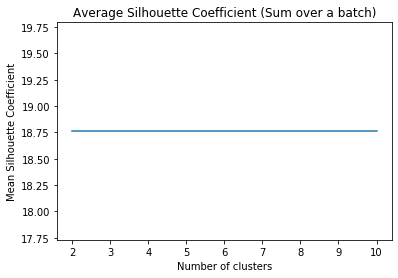

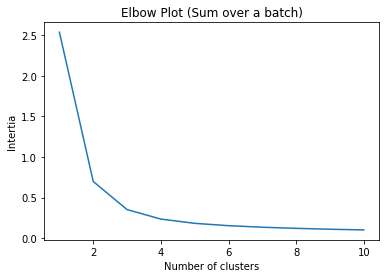

In [32]:
sh_full = np.zeros(9)
inertia_full = np.zeros(10)

for i in range(Z_pre.shape[0]):
    inertia = []
    sh_mean = []
    for n_clusters in range(1, 11):
        X = Z_pre[i, :, :].cpu().numpy()
        model = KMeans(n_clusters).fit(X)
        inertia.append(model.inertia_)

    if n_clusters != 1:
        cluster_labels = KMeans(n_clusters).fit_predict(X)
        sh_mean.append(silhouette_score(X, cluster_labels))

    sh_full += np.array(sh_mean)
    inertia_full += np.array(inertia)

plt.plot(range(2, 11), sh_full)
plt.title('Average Silhouette Coefficient (Sum over a batch)')
plt.xlabel('Number of clusters')
plt.ylabel('Mean Silhouette Coefficient')
plt.show()
plt.plot(range(1, 11), inertia_full)
plt.title('Elbow Plot (Sum over a batch)')
plt.xlabel('Number of clusters')
plt.ylabel('Intertia')
plt.show()

In [12]:
class RNN(nn.Module):

    def __init__(self, embed_size, hidden_size, output_size, embedding_pre_trained):
        
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Pre-trained Word Embedding of all the words is used
        self.embedding = nn.Embedding.from_pretrained(embedding_pre_trained)
        
        # Input to the RNN is word embeddings of a word
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size) 
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)  
        
    def forward(self, input_vec, hidden_vec):
        '''
        Parameters:
        ------------
        input_vec  - tensor of index of word/token. Example: torch.LongTensor([[0]]) for sos_token
        hidden_vec - train_image or output from previous RNN cell
        '''
        embedded_input_vec = self.embedding(input_vec)
        output_vec, hidden_vec = self.rnn(embedded_input_vec, hidden_vec)
        output_vec = self.softmax(self.out(output_vec[0]))
        return output_vec, hidden_vec      


In [111]:
class LSTM(nn.Module):

    def __init__(self, embed_size, hidden_size, output_size, embedding_pre_trained):
        
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # Pre-trained Word Embedding of all the words is used
        self.embedding = nn.Embedding.from_pretrained(embedding_pre_trained)
        
        # Input to the LSTM is word embeddings of a word
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size) 
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)  
        
    def forward(self, input_vec, hidden_vec, cell_state):
        '''
        Parameters:
        ------------
        input_vec  - tensor of index of word/token. Example: torch.LongTensor([[0]]) for sos_token
        hidden_vec - train_image or output from previous RNN cell
        '''
        embedded_input_vec = self.embedding(input_vec)
        output_vec, (hidden_vec, cell_state) = self.lstm(embedded_input_vec, (hidden_vec, cell_state))
        output_vec = self.softmax(self.out(output_vec[0]))
        return output_vec, (hidden_vec, cell_state)     
    
    

In [119]:
def train_one_image(train_image, image_caption, encoder_obj, decoder_obj, encoder_optim, decoder_optim, loss_func, vocab_tokens, is_LSTM=False):
    '''
    Parameters:
    -----------
    train_image     - Images stored in batches using DataLoader
    image_caption   - Caption of the image (in the same word embedding representation used in )

    
    '''
    # Start of sentence and End of Sentence token
    eos_token = np.argwhere(vocab_tokens=='eos').item()
    sos_token = np.argwhere(vocab_tokens=='sos').item()
    
    # Length of the image caption
    caption_length = len(image_caption)

    encoder_optim.zero_grad()
    decoder_optim.zero_grad()

    
    encoder_output = encoder_obj(train_image).view(1, 1, -1)

    decoder_input = torch.tensor([[sos_token]], device=device)  ## This is converted into an embedding withing the decoder class
    decoder_hidden = encoder_output
    decoder_hidden_size = decoder_hidden.shape[-1]
    if is_LSTM:
        decoder_cell_state = torch.zeros(decoder_hidden_size).view(1, 1, -1).to(device) 

    loss = 0
    for i in range(caption_length):
        if is_LSTM:
            decoder_output, (decoder_hidden, decoder_cell_state) = decoder_obj(decoder_input, decoder_hidden, decoder_cell_state)
        else:    
            decoder_output, decoder_hidden = decoder_obj(decoder_input, decoder_hidden) 
        max_val, max_ind = decoder_output.topk(1)  # Choosing the word with maximum probability 
        decoder_input = max_ind  #.squeeze().detach()  
        
        print('Target: ', image_caption[i], '---> Predicted :', vocab_tokens[decoder_input.item()])
        loss += loss_func(decoder_output, torch.tensor([np.argwhere(vocab_tokens == image_caption[i]).item()]).to(device))
        if decoder_input.item() == eos_token:
            break
            
    print(loss)
    loss.backward()
    encoder_optim.step()
    decoder_optim.step()

    return loss.item()/caption_length
    

In [101]:
def train(lr, trainloader_images, train_images_size, encoder_obj, decoder_obj, vocab_tokens, is_LSTM=False):
    
    loss_func = nn.NLLLoss()

    tokenizer = get_tokenizer("basic_english")
    punct = [',','.','?','!',')','(',':',']','[','$','#','&','%','--']
    
    encoder_optim = optim.SGD(encoder_obj.parameters(), lr=lr)
    decoder_optim = optim.SGD(decoder_obj.parameters(), lr=lr)
    
    old_loss = np.inf
    epoch = 0
    losses = []
    while True:
        new_loss = 0
        epoch += 1
        batch = 0 
        for data in trainloader_images:
            batch += 1
            images, captions = data[0].to(device), data[1]
            bs = images.shape[0]

            for i in range(bs):
                train_image = images[i].view(1, images.shape[1], images.shape[2], images.shape[3])
                image_caption = tokenizer(captions[i])
                image_caption = list(filter(lambda x: x not in punct, image_caption))
                image_caption.append('eos')
                new_loss += train_one_image(train_image, image_caption, encoder_obj, decoder_obj, encoder_optim, decoder_optim, loss_func, vocab_tokens, is_LSTM)
                        
        new_loss = new_loss/train_images_size
        
        print('-----------------------------------------------------------------------------------------------')
        print('Epoch {0}: Loss = {1}, Rel loss = {2}'.format(epoch, new_loss, abs(new_loss-old_loss)/new_loss))
        losses.append(new_loss)

        if abs(new_loss-old_loss)/new_loss < 1e-5:
            print('Converged')
            return losses

        old_loss = new_loss

In [122]:
def evaluate_one_image(encoder_obj, decoder_obj, image, image_caption, vocab_tokens, is_LSTM=False):
    with torch.no_grad():

        # Start of sentence and End of Sentence token
        sos_token = np.argwhere(vocab_tokens=='sos').item()
        eos_token = np.argwhere(vocab_tokens=='eos').item()

        # Length of the image caption
        caption_length = len(image_caption)

        encoder_output = encoder_obj(image).view(1, 1, -1)  
        
        decoder_input = torch.tensor([[sos_token]], device=device)
        decoder_hidden = encoder_output
        decoder_hidden_size = decoder_hidden.shape[-1]
        if is_LSTM:
            decoder_cell_state = torch.zeros(decoder_hidden_size).view(1, 1, -1).to(device)
            
        output_caption = []
            
        for i in range(caption_length):
            if is_LSTM:
                decoder_output, (decoder_hidden, decoder_cell_state) = decoder_obj(decoder_input, decoder_hidden, decoder_cell_state)
            else:    
                decoder_output, decoder_hidden = decoder_obj(decoder_input, decoder_hidden)             
            max_val, max_ind = decoder_output.topk(1)  # Choosing the word with maximum probability 
            decoder_input = max_ind 
            if decoder_input.item() == eos_token:
                output_caption.append('eos')
                break
            else:
                output_caption.append(vocab_tokens[decoder_input.item()])
                
        print('\n')
        print('Image caption: ', image_caption)
        print('Predicted caption: ', output_caption)

        return output_caption, [image_caption]
    
def evaluate(trainloader_images, train_images_size, encoder_obj, decoder_obj, is_LSTM = False):

    
    punct = [',','.','?','!',')','(',':',']','[','$','#','&','%','--']
    candidate_corpus = []
    references_corpus = []
    for data in trainloader_images:
        images, captions = data[0].to(device), data[1]
        bs = images.shape[0]
        
        for i in range(bs):
            train_image = images[i].view(1, images.shape[1], images.shape[2], images.shape[3])
            image_caption = tokenizer(captions[i])
            image_caption = list(filter(lambda x: x not in punct, image_caption))
            image_caption.append('eos')
            oc, ic = evaluate_one_image(encoder_obj, decoder_obj, train_image, image_caption, vocab_tokens, is_LSTM)
            candidate_corpus.append(oc)
            references_corpus.append(ic)
                
    return candidate_corpus, references_corpus

### Question 1

In [57]:
# k = 3
# encoder_obj = NetVLAD(k).to(device)

# embed_size = embedding_trained.shape[1]
# decoder_output_size = embedding_trained.shape[0]
# decoder_hidden_size = k*256
# decoder_obj = RNN(embed_size, decoder_hidden_size, decoder_output_size, embedding_trained).to(device)

In [58]:
losses = train(0.001, trainloader, train_size, encoder_obj, decoder_obj, vocab_tokens, is_LSTM = False)

-----------------------------------------------------------------------------------------------
Epoch 1: Loss = 3.6206088395104032, Rel loss = inf
-----------------------------------------------------------------------------------------------
Epoch 2: Loss = 3.600289130343928, Rel loss = 0.005643910372424443
-----------------------------------------------------------------------------------------------
Epoch 3: Loss = 3.5970840179155488, Rel loss = 0.0008910307383469757
-----------------------------------------------------------------------------------------------
Epoch 4: Loss = 3.591294388025744, Rel loss = 0.0016121290165208536
-----------------------------------------------------------------------------------------------
Epoch 5: Loss = 3.568670138136091, Rel loss = 0.0063396864977466215
-----------------------------------------------------------------------------------------------
Epoch 6: Loss = 3.557387663603607, Rel loss = 0.003171561718706509
----------------------------------

-----------------------------------------------------------------------------------------------
Epoch 51: Loss = 3.6224366494000257, Rel loss = 0.000457891233636521
-----------------------------------------------------------------------------------------------
Epoch 52: Loss = 3.6143207202939207, Rel loss = 0.002245492233308238
-----------------------------------------------------------------------------------------------
Epoch 53: Loss = 3.6314265689938177, Rel loss = 0.004710503813006077
-----------------------------------------------------------------------------------------------
Epoch 54: Loss = 3.6061041875059847, Rel loss = 0.0070220881514092195
-----------------------------------------------------------------------------------------------
Epoch 55: Loss = 3.6052233478026046, Rel loss = 0.00024432319953686886
-----------------------------------------------------------------------------------------------
Epoch 56: Loss = 3.6206607859473716, Rel loss = 0.004263707388630095
-------

KeyboardInterrupt: 

In [ ]:
plt.plot(range(1, len(losses)+1),losses)
plt.title('Loss vs Epochs')
plt.show()

In [90]:
candidate_corpus, references_corpus = evaluate(trainloader, train_size, encoder_obj, decoder_obj)



Image caption:  ['two', 'seagulls', 'on', 'water', 'foreground', 'bird', 'has', 'object', 'held', 'in', 'beak', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'older', 'man', 'in', 'a', 'long', 'sleeved', 'black', 'shirt', 'is', 'walking', 'down', 'a', 'cobblestone', 'street', 'alone', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['indians', 'in', 'native', 'dress', 'with', 'instruments', 'under', 'shelter', 'dancing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woman', 'sits', 'on', 'the', 'curb', 'talking', 'on', 'a', 'cellphone', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['there', 'is', 'a', 'group', 'of', 'people', 'in', 'winter', 'coats', 'are', 'gather', 'in', 'front', 'of', 'a', 'large', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image captio



Image caption:  ['the', 'young', 'boy', 'with', 'a', 'silly', 'face', 'is', 'buckled', 'in', 'a', 'car', 'seat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['rugby', 'match', 'eos']
Predicted caption:  ['a', 'man', 'in']


Image caption:  ['a', 'white', 'dog', 'plays', 'with', 'a', 'brown', 'dog', 'on', 'carpet', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'boy', 'in', 'the', 'yellow', 'shirt', 'is', 'riding', 'a', 'skateboard', 'along', 'a', 'red', 'bar', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'purple', 'shirt', 'in', 'front', 'of', 'a', 'woman', 'in', 'a', 'yellow', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'and', 'brown', 'dog', 'with', 'his', 'mouth', 'open', 'and', 'tongue', 'out', 'facing', 'a', 'second', 'almost', 'off-camera', '



Image caption:  ['two', 'men', 'one', 'of', 'which', 'is', 'bald', 'in', 'a', 'bathroom', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'with', 'pierced', 'ears', 'is', 'wearing', 'glasses', 'and', 'an', 'orange', 'hat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lone', 'snowboarder', 'wearing', 'a', 'white', 'jacket', 'jumping', 'into', 'the', 'air', 'on', 'the', 'snowy', 'mountains', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'child', 'is', 'jumping', 'off', 'a', 'yellow', 'stool', 'inside', 'a', 'room', 'in', 'a', 'house', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'brown', 'dog', 'has', 'a', 'hold', 'of', 'the', 'other', 'dogs', 'cheek', 'with', 'its', 'teeth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption: 


Image caption:  ['a', 'yellow', 'and', 'brown', 'dog', 'is', 'going', 'to', 'the', 'bathroom', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['young', 'boy', 'jumping', 'on', 'to', 'his', 'bed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snow', 'skier', 'in', 'a', 'red', 'top', 'and', 'black', 'pants', 'moving', 'down', 'a', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'brown', 'and', 'white', 'dogs', 'play', 'roughly', 'in', 'a', 'clearing', 'of', 'a', 'wooded', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'bee', 'hovers', 'above', 'the', 'flower', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['woman', 'with', 'two', 'children', 'playing', 'in', 'outdoor', 'fountain', 'eos']
Predicted caption:  ['a', 'man', 'in', '



Image caption:  ['a', 'woman', 'singing', 'and', 'playing', 'an', 'acoustic', 'guitar', 'and', 'three', 'people', 'accompanying', 'her', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['cat', 'standing', 'to', 'play', 'with', 'string', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'black', 'dog', 'jumping', 'from', 'a', 'dock', 'into', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'surfing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a']


Image caption:  ['a', 'group', 'of', 'people', 'ride', 'bikes', 'while', 'holding', 'onto', 'large', 'trash', 'bags', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'baseball', 'player', 'is', 'on', 'the', 'field', 'in', 'fronmt', 'of', 'an', 'audience', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption: 

Image caption:  ['the', 'furry', 'brown', 'dog', 'is', 'running', 'through', 'the', 'grassy', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'a', 'hankerchief', 'on', 'his', 'next', 'and', 'pierced', 'ears', 'looks', 'off', 'into', 'the', 'distance', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'is', 'playing', 'with', 'a', 'red', 'toy', 'while', 'another', 'brown', 'dog', 'bounds', 'towards', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['killer', 'whales', 'perform', 'for', 'a', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'child', 'is', 'playing', 'in', 'a', 'water', 'tank', 'with', 'toys', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'men', 'are', 'sitting', 'on', 'a



Image caption:  ['two', 'brown', 'and', 'white', 'dogs', 'are', 'standing', 'on', 'a', 'sidewalk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'in', 'an', 'orange', 'shirt', 'are', 'sitting', 'on', 'a', 'rock', 'and', 'looking', 'at', 'the', 'view', 'of', 'the', 'trees', 'and', 'the', 'hills', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'plays', 'guitar', 'next', 'to', 'a', 'drummer', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girls', 'plays', 'in', 'the', 'surf', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'girl', 'in', 'a', 'pink', 'shirt', 'jumping', 'out', 'of', 'a', 'moving', 'swing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'kite', 'surfing', 'creates', 'a', 'wave', 'eos']
Predi



Image caption:  ['a', 'small', 'dog', 'is', 'standing', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'boys', 'hold', 'toy', 'guns', 'while', 'under', 'a', 'pavillion', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['person', 'doing', 'a', 'trick', 'on', 'a', 'skateboard', 'in', 'a', 'skate', 'park', 'while', 'people', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'woman', 'dressed', 'up', 'dance', 'together', 'outdoors', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'is', 'pulling', 'itself', 'out', 'of', 'the', 'water', 'onto', 'some', 'rocks', 'with', 'a', 'tennis', 'ball', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'wearing', 'a', 're


Image caption:  ['these', 'six', 'people', 'are', 'walking', 'outside', 'a', 'building', 'with', 'columns', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'raises', 'her', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['two', 'dogs', 'are', 'tugging', 'at', 'a', 'piece', 'of', 'white', 'material', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'on', 'a', 'skateboard', 'at', 'a', 'skate', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'dress', 'suit', 'is', 'riding', 'a', 'bike', 'down', 'the', 'paved', 'road', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'shop', 'for', 'fresh', 'produce', 'at', 'an', 'outdoor', 'market', 'in', 'the', 'city', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a'



Image caption:  ['a', 'man', 'with', 'a', 'messenger', 'bag', 'in', 'front', 'of', 'a', 'gray', 'tile', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'pushes', 'a', 'man', 'in', 'a', 'wheelchair', 'in', 'a', 'european', 'courtyard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'mother', 'is', 'holding', 'her', 'child', 'on', 'a', 'train', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'rides', 'a', 'bike', 'down', 'a', 'trail', 'in', 'a', 'pine', 'forest', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'with', 'a', 'purple', 'and', 'white', 'helmet', 'is', 'riding', 'on', 'a', 'scooter', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['several', 'people', 'are', 'running', 'quickly', 'through', 'a', 'parking',


Image caption:  ['a', 'group', 'of', 'dogs', 'standing', 'by', 'a', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'very', 'wet', 'dog', 'coming', 'toward', 'the', 'camera', 'through', 'a', 'mossy', 'pond', 'with', 'a', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'boys', 'play', 'football', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'brown', 'dog', 'is', 'playing', 'on', 'the', 'ice', 'at', 'the', 'edge', 'of', 'a', 'lake', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'wearing', 'a', 'plaid', 'dress', 'standing', 'on', 'the', 'sidewalk', 'next', 'to', 'a', 'white', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'holds', 'a', 'toddler', 'on', 'a', 'boar



Image caption:  ['a', 'dirt', 'biker', 'competes', 'while', 'onlookers', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'jumping', 'off', 'a', 'chair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'woman', 'wearing', 'a', 'fire', 'department', 'uniform', 'is', 'talking', 'to', 'people', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'woman', 'walk', 'on', 'the', 'sidewalk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['water', 'is', 'spraying', 'on', 'the', 'child', 'with', 'its', 'face', 'through', 'a', 'cut', 'out', 'hole', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['girl', 'in', 'red', 'shirt', 'blowing', 'a', 'bubble', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['th


Image caption:  ['a', 'young', 'boy', 'wearing', 'a', 'suit', 'and', 'top', 'hat', 'is', 'holding', 'hands', 'with', 'a', 'girl', 'in', 'a', 'green', 'dress', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'in', 'a', 'blur', 'shirt', 'playing', 'in', 'a', 'flower', 'bed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'woman', 'kissing', 'in', 'front', 'of', 'a', 'crowd', 'of', 'people', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'black', 'with', 'a', 'scarf', 'walks', 'down', 'a', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['childern', 'are', 'playing', 'on', 'a', 'merry', 'go', 'round', 'as', 'adults', 'on', 'a', 'bench', 'watch', 'them', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'gi



Image caption:  ['four', 'people', 'are', 'posing', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['the', 'child', 'is', 'using', 'chopsticks', 'on', 'overturned', 'kitchen', 'items', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'red', 'shorts', 'is', 'holding', 'onto', 'the', 'rocks', 'beside', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'walk', 'on', 'the', 'sidewalk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'wearing', 'very', 'little', 'clothing', 'is', 'doing', 'a', 'jump', 'on', 'a', 'red', 'bicycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'yellow', 'lab', 'drinks', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'toy', '


Image caption:  ['a', 'four', 'wheel', 'drive', 'car', 'is', 'driving', 'through', 'the', 'mud', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'dressed', 'in', 'black', 'suit', 'and', 'tie', 'reads', 'a', 'book', 'while', 'waiting', 'on', 'the', 'subway', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'climbs', 'up', 'a', 'sheer', 'wall', 'of', 'ice', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['shows', 'a', 'crowd', 'of', 'people', 'in', 'front', 'of', 'a', 'glass', 'building', 'with', 'three', 'country', 'flags', 'flying', 'high', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'young', 'naked', 'children', 'showering', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'girl', 'has', 'a', 'black', 'purse',



Image caption:  ['a', 'girl', 'in', 'a', 'lavender', 'shirt', 'looks', 'puzzled', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lone', 'skier', 'skiing', 'down', 'a', 'snowy', 'mountain', 'on', 'one', 'ski', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'african', 'american', 'woman', 'is', 'leaning', 'over', 'while', 'holding', 'a', 'tennis', 'racket', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'orange', 'is', 'holding', 'up', 'a', 'bicycle', 'near', 'a', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woman', 'being', 'lifted', 'by', 'other', 'women', 'play', 'volleyball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'kid', 'running', 'towards', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man'


Image caption:  ['a', 'woman', 'is', 'flinging', 'water', 'with', 'her', 'hair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'red', 'tracksuit', 'is', 'throwing', 'a', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bicycle', 'rider', 'is', 'crossing', 'a', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'swings', 'high', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'determined', 'girl', 'is', 'hitting', 'a', 'volleyball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'playing', 'the', 'guitar', 'for', 'a', 'child', 'in', 'a', 'hospital', 'bed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man



Image caption:  ['a', 'warmly', 'dressed', 'person', 'is', 'shoveling', 'snow', 'outside', 'a', 'house', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['brown', 'and', 'white', 'dog', 'trotting', 'with', 'brown', 'object', 'falling', 'nearby', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'three', 'dogs', 'are', 'running', 'around', 'near', 'the', 'shore', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['guy', 'in', 'black', 'uniform', 'dribbling', 'basketball', 'away', 'from', 'guy', 'in', 'white', 'uniform', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'dressed', 'in', 'light', 'blue', 'with', 'white', 'shoes', 'does', 'a', 'back', 'flip', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['dog', 'chasing', 'after', 'a'



Image caption:  ['two', 'small', 'dogs', 'search', 'the', 'ground', 'for', 'something', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'baby', 'in', 'swim', 'trunks', 'shows', 'off', 'his', 'balancing', 'ability', 'with', 'the', 'help', 'of', 'his', 'father', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'snowboards', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a']


Image caption:  ['a', 'dimly', 'lit', 'room', 'with', 'several', 'individuals', 'including', 'a', 'young', 'man', 'and', 'woman', 'holding', 'hands', 'across', 'a', 'table', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woman', 'in', 'grey', 'shirt', 'and', 'dark', 'skirt', 'sitting', 'in', 'blue', 'chair', 'with', 'white', 'stars', 'in', 'front', 'of', 'a', 'brick', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  [


Image caption:  ['the', 'man', 'with', 'the', 'backpack', 'is', 'sitting', 'in', 'a', 'buildings', 'courtyard', 'in', 'front', 'of', 'an', 'art', 'sculpture', 'reading', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'lays', 'on', 'a', 'mattress', 'on', 'the', 'porch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'small', 'children', 'walk', 'down', 'a', 'sandy', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'wearing', 'a', 'pink', 'hat', 'climbs', 'on', 'the', 'playground', 'equipment', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'dog', 'in', 'front', 'of', 'a', 'yellow', 'tube', 'on', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'engulfed', 'in', 'flames', 'while',



Image caption:  ['the', 'large', 'brown', 'dog', 'is', 'sniffing', 'a', 'small', 'white', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'in', 'a', 'black', 'wetsuit', 'carrying', 'a', 'surfboard', 'into', 'the', 'waves', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'and', 'little', 'girl', 'are', 'sitting', 'on', 'a', 'wooden', 'bench', 'beside', 'a', 'wooden', 'bear', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'standing', 'on', 'a', 'mountaintop', 'looking', 'into', 'the', 'distance', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'boys', 'in', 'blue', 'and', 'yellow', 'uniforms', 'play', 'soccer', 'with', 'a', 'boy', 'in', 'a', 'pink', 'printed', 'uniform', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image c



Image caption:  ['a', 'guy', 'is', 'pointing', 'with', 'a', 'girl', 'sitting', 'beside', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'lizards', 'fighting', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a']


Image caption:  ['two', 'girls', 'dressed', 'in', 'black', 'are', 'sitting', 'in', 'a', 'room', 'making', 'suggestive', 'poses', 'at', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'people', 'and', 'a', 'sled', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'long', 'haired', 'dog', 'walks', 'out', 'of', 'the', 'water', 'and', 'licks', 'his', 'nose', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'is', 'riding', 'on', 'a', 'breaking', 'wave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'skiers', 'a

Image caption:  ['a', 'grey', 'dog', 'plays', 'in', 'the', 'sand', 'at', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lone', 'person', 'in', 'a', 'harness', 'climbing', 'a', 'huge', 'rock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'two', 'dogs', 'are', 'enjoying', 'a', 'run', 'through', 'the', 'surf', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['hands', 'and', 'feet', 'of', 'several', 'people', 'holding', 'cigarettes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'runs', 'uphill', 'towards', 'the', 'camera', 'in', 'near', 'a', 'fenced', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'motorcycle', 'rider', 'turns', 'the', 'motorcycle', 'on', 'its', 'side', 'while', 'racing', 'eos']
Predicted caption:



Image caption:  ['the', 'woman', 'is', 'dressed', 'in', 'all', 'white', 'swinging', 'a', 'tennis', 'racket', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'rides', 'a', 'skateboard', 'up', 'a', 'ramp', 'with', 'his', 'arms', 'holding', 'himself', 'up', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'a', 'blue', 'shirt', 'runs', 'while', 'smiling', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'are', 'facing', 'each', 'other', 'on', 'the', 'grass', 'beside', 'a', 'wooden', 'fence', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boat', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'black', 'dog', 'digs', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']



Image caption:  ['a', 'man', 'in', 'red', 'holds', 'up', 'a', 'cellphone', 'on', 'the', 'sidelines', 'of', 'football', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'red', 'shirt', 'holding', 'a', 'cellphone', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'chases', 'a', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'makes', 'a', 'faithful', 'leap', 'to', 'catch', 'a', 'green', 'and', 'black', 'frisbee', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'cop', 'stands', 'in', 'front', 'of', 'a', 'car', 'on', 'a', 'busy', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'puppies', 'laying', 'on', 'a', 'couch', 'with', 'a', 'bottle', 'of', 'milk', 'one', 



Image caption:  ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning', 'how', 'to', 'climb', 'a', 'cliff', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dogs', 'jump', 'over', 'an', 'obstacle', 'at', 'an', 'event', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'contorts', 'his', 'body', 'as', 'he', 'plays', 'baseball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'little', 'girls', 'and', 'one', 'little', 'boy', 'are', 'running', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'tourists', 'photograph', 'a', 'countryside', 'and', 'ruins', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'boys', 'surrounded', 'by', 'paper', 'pieces', 'hold', 'a', 'third', 'boys', 'shirt', 'to', 'prevent', 'him', 'fr

Image caption:  ['a', 'cold', 'cycler', 'celebrates', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['a', 'dog', 'runs', 'overtop', 'the', 'dry', 'earth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'blond', 'girl', 'wearing', 'a', 'yellow', 'shirt', 'sliding', 'down', 'a', 'yellow', 'slide', 'with', 'her', 'feet', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'in', 'the', 'blue', 'smock', 'and', 'beret', 'holds', 'up', 'a', 'brass', 'rubbing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'miami', 'basketball', 'player', 'looks', 'off', 'in', 'the', 'distance', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'purple', 'top', 'holds', 'a', 'toddler', 'between', 'herself', 'and', 'another', 'girl', 'on'



Image caption:  ['a', 'baby', 'wearing', 'a', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'rock', 'climber', 'with', 'a', 'white', 'helmet', 'is', 'repelling', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'takes', 'out', 'a', 'cigarette', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'gray', 'dog', 'is', 'running', 'on', 'a', 'green', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'white', 'pelican', 'is', 'flying', 'over', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'white', 'dogs', 'wearing', 'muzzles', 'jump', 'over', 'a', 'white', 'board', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'tan', 'shirt', 'holding', 'up', 'a', 'fork',


Image caption:  ['a', 'young', 'boy', 'jumps', 'off', 'a', 'swing', 'set', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'older', 'man', 'skiing', 'down', 'a', 'mountain', 'on', 'a', 'clear', 'day', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'is', 'running', 'around', 'a', 'tumbleweed', 'on', 'a', 'sand', 'dune', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wears', 'a', 'floral', 'bathroom', 'as', 'he', 'stands', 'over', 'a', 'trashcan', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'long', 'haired', 'dogs', 'play', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'biker', 'is', 'racing', 'to', 'keep', 'up', 'with', 'the', 'runners', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a'



Image caption:  ['a', 'dog', 'is', 'biting', 'a', 'mop', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'coach', 'at', 'a', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['little', 'boy', 'with', 'orange', 'shirt', 'jumps', 'off', 'of', 'small', 'yellow', 'foot', 'stool', 'indoors', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'basketball', 'player', 'tries', 'to', 'block', 'another', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dancer', 'on', 'steps', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['bald', 'man', 'two', 'women', 'with', 'beers', 'posing', 'at', 'event', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'young', 'girls', 'are', 'embracing', 'each', 'other', 'and', 'seem', 'happy', 'eos']
Predicted caption



Image caption:  ['a', 'small', 'white', 'dog', 'gets', 'sprayed', 'by', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'white', 'furry', 'dogs', 'play', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'prepares', 'to', 'heard', 'three', 'sheep', 'with', 'horns', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'on', 'a', 'plastic', 'sled', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'is', 'on', 'the', 'grass', 'shaking', 'himself', 'dry', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['small', 'girl', 'in', 'tunnel', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['two', 'men', 'are', 'standing', 'in', 'the', 'street', 'behind', 'a', 'table', 'that', 'has', 'a', 'laptop


Image caption:  ['a', 'leashed', 'dog', 'is', 'in', 'the', 'backyard', 'of', 'someone', "'", 's', 'home', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'play', 'with', 'an', 'orange', 'toy', 'in', 'tall', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['seated', 'man', 'looks', 'out', 'at', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'car', 'is', 'partially', 'submerged', 'in', 'a', 'lake', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'men', 'are', 'posing', 'for', 'a', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'walking', 'on', 'a', 'snowy', 'surface', 'near', 'snow', 'covered', 'trees', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image capt



Image caption:  ['a', 'person', 'in', 'midair', 'doing', 'a', 'back', 'flip', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'drives', 'an', 'old-fashioned', 'red', 'race', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'girls', 'in', 'evening', 'attire', 'pose', 'for', 'a', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'an', 'obama', 't-shirt', 'and', 'holding', 'a', 'coffee', 'cup', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['person', 'in', 'a', '3-wheeler', 'driving', 'on', '2', 'wheels', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'wrestling', 'in', 'an', 'arena', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'girl', 'is', 'in', 'th



Image caption:  ['small', 'dog', 'running', 'in', 'the', 'grass', 'with', 'a', 'toy', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'dressed', 'in', 'pink', 'is', 'falling', 'in', 'water', 'while', 'another', 'girl', 'dressed', 'in', 'red', 'watches', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'woman', 'are', 'sitting', 'on', 'concrete', 'stairs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'boys', 'play', 'on', 'a', 'merry-go-round', 'at', 'a', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'men', 'are', 'climbing', 'a', 'rock', 'face', 'at', 'a', 'waterfall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['african', 'american', 'men', 'receiving', 'plates', 'of', 'foo



Image caption:  ['a', 'black', 'dog', 'and', 'a', 'brindle', 'dog', 'wrestle', 'in', 'the', 'dry', 'grass', 'beside', 'a', 'body', 'of', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['couple', 'kissing', 'in', 'the', 'middle', 'of', 'a', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'carefully', 'crosses', 'over', 'some', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['women', 'in', 'colorful', 'costumes', 'dance', 'in', 'the', 'street', 'in', 'front', 'of', 'a', 'mcdonalds', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'toddler', 'is', 'petting', 'the', 'little', 'white', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'with', 'a', 'ribbon', 'in', 'her', 'hair', 'is', 'picking


Image caption:  ['blonde', 'lady', 'looks', 'at', 'space', 'needle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['there', 'is', 'a', 'boy', 'with', 'a', 'helmet', 'and', 'a', 'stripe', 'down', 'the', 'side', 'of', 'his', 'pants', 'riding', 'on', 'a', 'skateboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'are', 'in', 'the', 'woods', 'playing', 'instruments', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'stands', 'in', 'a', 'driveway', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'large', 'group', 'of', 'people', 'with', 'hands', 'raised', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'in', 'a', 'blue', 'jacket', 'going', 'down', 'a', 'hill', 'on', 'a', 'sled', 'eos']
Predicted captio


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'relaxes', 'on', 'a', 'carpet', 'in', 'sunlight', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'and', 'young', 'woman', 'pose', 'with', 'their', 'arms', 'around', 'each', 'other', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'runs', 'through', 'the', 'grass', 'with', 'its', 'tongue', 'hanging', 'out', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'catcher', 'in', 'a', 'red', 'and', 'white', 'uniform', 'plays', 'at', 'a', 'baseball', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'brown', 'dog', 'is', 'running', 'away', 'with', 'a', 'stick', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'a', 'motorbike', 'riding', 'down',



Image caption:  ['three', 'people', 'gather', 'around', 'the', 'table', 'and', 'have', 'their', 'picture', 'taken', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'grinding', 'the', 'lip', 'of', 'a', 'pool', 'on', 'his', 'rollerblades', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'working', 'on', 'a', 'computer', 'while', 'two', 'people', 'sit', 'and', 'talk', 'in', 'front', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'sitting', 'on', 'a', 'stool', 'wearing', 'a', 'tan', 'leather', 'jacket', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'children', 'play', 'in', 'the', 'grass', 'at', 'a', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'men', 'struggle', 'to', 'catch



Image caption:  ['person', 'is', 'riding', 'a', 'bike', 'with', 'blue', 'tires', 'up', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['children', 'jump', 'in', 'bouncy', 'gym', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'skater', 'does', 'a', 'trick', 'on', 'a', 'yellow', 'handrail', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'and', 'girl', 'are', 'trying', 'to', 'hit', 'a', 'man', 'with', 'balls', 'in', 'a', 'fair', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'helps', 'tie', 'a', 'red', 'ribbon', 'around', 'another', 'man', "'", 's', 'right', 'arm', 'during', 'a', 'street', 'parade', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['men', 'skiing', 'eos']
Predicted caption:  ['a', 'man', 'in']


Image capti



Image caption:  ['a', 'dog', 'on', 'a', 'girder', 'with', 'a', 'river', 'bank', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'red-uniformed', 'hockey', 'player', 'is', 'attempting', 'to', 'control', 'the', 'puck', 'while', 'two', 'white-suited', 'hockey', 'players', 'try', 'to', 'disrupt', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'woman', 'standing', 'in', 'front', 'of', 'a', 'refreshment', 'stand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['player', 'number', '23', 'dunks', 'the', 'basketball', 'into', 'the', 'net', 'with', 'a', 'crowd', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'is', 'shaking', 'off', 'after', 'getting', 'wet', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 



Image caption:  ['a', 'black', 'dog', 'holds', 'a', 'beat', 'up', 'soccer', 'ball', 'in', 'his', 'mouth', 'on', 'the', 'grass', 'in', 'front', 'of', 'a', 'home', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'pose', 'in', 'the', 'snow', 'with', 'four', 'children', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'elderly', 'lady', 'in', 'sunglasses', 'and', 'a', 'denim', 'jacket', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'sliding', 'down', 'a', 'black', 'pole', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'dressed', 'in', 'a', 'pink', 'sweatshirt', 'and', 'pink', 'and', 'white', 'striped', 'skirt', 'plays', 'in', 'the', 'waves', 'at', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Ima



Image caption:  ['a', 'smiling', 'woman', 'punching', 'a', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'person', 'riding', 'a', 'bicycle', 'travels', 'down', 'an', 'overgrown', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'sitting', 'on', 'a', 'snowbank', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'runs', 'across', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'is', 'jumping', 'through', 'the', 'air', 'in', 'an', 'open', 'snow', 'covered', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'golden', 'labrador', 'is', 'swimming', 'through', 'water', 'with', 'a', 'red', 'toy', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image cap



Image caption:  ['an', 'adolescent', 'wearing', 'a', 'blue', 'striped', 'shirt', 'is', 'skateboarding', 'on', 'a', 'rock', 'inside', 'of', 'a', 'large', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'lime', 'green', 'vest', 'directs', 'traffic', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'male', 'attempts', 'skateboard', 'tricks', 'by', 'a', 'bridge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'young', 'asian', 'women', 'are', 'posing', 'in', 'front', 'of', 'a', 'window', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'with', 'a', 'black', 'sweater', 'and', 'white', 'necklace', 'poses', 'for', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'is', 'popping'



Image caption:  ['football', 'players', 'gather', 'around', 'the', 'referees', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'looks', 'out', 'over', 'frozen', 'tundra', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'couple', 'kiss', 'in', 'a', 'subway', 'station', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'tired', 'business', 'man', 'takes', 'a', 'quick', 'nap', 'while', 'riding', 'the', 'train', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['terrier', 'dog', 'playing', 'with', 'toy', 'on', 'blanket', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'is', 'going', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'wearing', 'a', 'red', 'shirt', 'and', 



Image caption:  ['these', 'five', 'people', 'are', 'seated', 'on', 'steps', 'outdoors', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'black', 'dogs', 'are', 'running', 'in', 'the', 'grass', 'one', 'has', 'a', 'green', 'ball', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'climbing', 'a', 'rock', 'climbing', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'rides', 'a', 'game', 'machine', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'performing', 'a', 'trick', 'on', 'a', 'bicycle', 'by', 'standing', 'on', 'the', 'pedals', 'while', 'the', 'bike', 'is', 'upright', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'jumping', 'rope', 'on', 'a', 'sidewalk', 'near', 'a', 'parking', 'ga


Image caption:  ['a', 'brown', 'dog', 'jumping', 'in', 'the', 'air', 'on', 'a', 'brown', 'plain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'motocross', 'rider', 'is', 'traveling', 'along', 'a', 'dirt', 'path', 'with', 'people', 'watching', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'and', 'dog', 'standing', 'on', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'sits', 'on', 'a', 'bench', 'and', 'eats', 'an', 'apple', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'recoils', 'from', 'the', 'impact', 'of', 'sand', 'onto', 'his', 'bare', 'chest', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'soccer', 'players', 'are', 'going', 'after', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a


Image caption:  ['three', 'people', 'are', 'walking', 'in', 'a', 'park', 'with', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'in', 'a', 'blue', 'shirt', 'laying', 'on', 'his', 'side', 'with', 'his', 'mouth', 'open', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'holds', 'a', 'football', 'and', 'runs', 'from', 'other', 'children', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'children', 'jumping', 'into', 'a', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'and', 'woman', 'hug', 'on', 'a', 'couch', 'while', 'another', 'woman', 'smiles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'is', 'waiting', 'for', 'a', 'train', 'at', 'an', 'empty', 'train', 'station', 'eos']
Predicted caption:



Image caption:  ['the', 'child', 'jumps', 'up', 'at', 'bubbles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'black', 'dog', 'jumps', 'over', 'an', 'obstacle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'on', 'a', 'green', 'board', 'is', 'snowboarding', 'in', 'midair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['this', 'skater', 'is', 'jumping', 'over', 'a', 'hydrant', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'laughing', 'boy', 'lies', 'on', 'a', 'pit', 'of', 'blue', 'balls', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'golden', 'dog', 'tries', 'to', 'catch', 'a', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'rides', 'a', 'unicycle', 'while', 'a', 'crow


Image caption:  ['a', 'woman', 'wearing', 'a', 'pink', 'boa', 'rides', 'a', 'bicycle', 'down', 'a', 'pedestrian', 'bridge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'bike', 'is', 'jumping', 'an', 'obstacle', 'with', 'a', 'crowd', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'in', 'a', 'green', 'cap', 'sits', 'at', 'a', 'boats', 'controls', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'ride', 'saucers', 'down', 'a', 'snowy', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'indian', 'woman', 'stands', 'in', 'an', 'outdoor', 'marketplace', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lady', 'walks', 'behind', 'a', 'wheelchair', 'while', 'another', 'lady', 'wal



Image caption:  ['the', 'woman', 'is', 'walking', 'through', 'the', 'snow', 'and', 'trying', 'to', 'light', 'a', 'cigarette', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'is', 'running', 'in', 'and', 'out', 'of', 'a', 'line', 'of', 'posts', 'on', 'an', 'obstacle', 'course', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['brown', 'dog', 'leaps', 'over', 'a', 'chain', 'suspended', 'over', 'a', 'gravel', 'road', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'walking', 'in', 'a', 'river', 'with', 'trees', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'swings', 'on', 'a', 'rope', 'swing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'two', 'young', 'boys', 'play', 'in', 'a', 'puddle

Image caption:  ['a', 'young', 'girl', 'wearing', 'a', 'blue', 'leotard', 'jumps', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'women', 'painting', 'on', 'the', 'sidewalk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['four', 'middle', 'eastern', 'children', 'three', 'girls', 'and', 'one', 'boy', 'climb', 'on', 'a', 'grotto', 'with', 'a', 'pink', 'interior', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'stand', 'in', 'the', 'snow', 'in', 'a', 'mountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'woman', 'in', 'the', 'black', 'shirt', 'is', 'pointing', 'in', 'front', 'of', 'her', 'with', 'a', 'cement', 'wall', 'in', 'front', 'of', 'her', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'cycli



Image caption:  ['three', 'women', 'wearing', 'plenty', 'of', 'green', 'and', 'shamrocks', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'swimming', 'while', 'holding', 'a', 'orange', 'toy', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'the', 'beach', 'in', 'jeans', 'looking', 'at', 'his', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'pink', 'hat', 'holds', 'a', 'camera', 'to', 'her', 'face', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'litle', 'girl', 'stands', 'on', 'a', 'rocky', 'shore', 'at', 'looks', 'out', 'at', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'running', 'through', 'the', 'water', 'eos']
Predicted c



Image caption:  ['a', 'man', 'blowing', 'a', 'large', 'bubble', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'goalie', 'lays', 'on', 'the', 'ground', 'after', 'catching', 'a', 'soccer', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'in', 'a', 'red', 'shirt', 'and', 'hat', 'enjoys', 'a', 'tire-shaped', 'swing', 'at', 'the', 'playground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'little', 'girl', 'walk', 'next', 'to', 'a', 'sign', 'about', 'crime', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'catching', 'a', 'big', 'wave', 'in', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'on', 'top', 'of', 'a', 'ridge', 'looking', 'at', 'a', 'small', 'stone', 'tower', 'eos']
Pred



Image caption:  ['policemen', 'are', 'gathered', 'around', 'a', 'glass', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'little', 'ballerinas', 'are', 'all', 'wearing', 'white', 'bows', 'dresses', 'and', 'leggings', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['there', 'is', 'a', 'man', 'fly', 'fishing', 'in', 'a', 'river', 'with', 'trees', 'behind', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'attempts', 'to', 'squeeze', 'between', 'two', 'gray', 'steps', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'jumps', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'person', 'in', 'red', 'and', 'blue', 'holding', 'a', 'paddle', 'in', 'front', 'of', 'a', 'yellow', 'canoe', 'in', 'the', 'water', 'e


Image caption:  ['a', 'little', 'boy', 'has', 'fallen', 'asleep', 'on', 'a', 'miniature', 'sofa', 'and', 'a', 'pacifier', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'jumping', 'into', 'a', 'body', 'of', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'hang', 'gliding', 'from', 'a', 'red', 'white', 'and', 'black', 'glider', 'with', 'blue', 'cloudy', 'skies', 'behind', 'them', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'doing', 'a', 'jump', 'on', 'a', 'snowboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'a', 'black', 'coat', 'carrying', 'a', 'pro', 'israel', 'protest', 'sign', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'd



Image caption:  ['a', 'person', 'in', 'warm', 'clothing', 'fishes', 'off', 'a', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['kids', 'are', 'standing', 'in', 'the', 'sprinklers', 'getting', 'soaked', 'with', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'player', 'watches', 'the', 'tennis', 'ball', 'he', 'hit', 'go', 'flying', 'as', 'the', 'crowd', 'watches', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'yellow', 'cap', 'is', 'on', 'the', 'beach', 'carrying', 'a', 'fishing', 'pole', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'climbing', 'down', 'from', 'the', 'side', 'of', 'a', 'bright', 'blue', 'truck', 'while', 'others', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and'


Image caption:  ['a', 'football', 'running', 'back', 'getting', 'tackled', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'person', 'stands', 'in', 'a', 'vast', 'field', 'of', 'glacial', 'ice', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'on', 'ski', "'", 's', 'in', 'the', 'air', 'at', 'a', 'ski', 'slope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'rides', 'a', 'motorbike', 'through', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'wearing', 'a', 'bright', 'pink', 'top', 'is', 'spinning', 'a', 'colorful', 'ribbon', 'around', 'her', 'body', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'and', 'an', 'older', 'woman', 'sitting', 'at', 'a', 'brown', 'table', 'in', 'a', 'blue', 'room',


Image caption:  ['people', 'are', 'enjoying', 'a', 'sunny', 'day', 'on', 'a', 'sandy', 'beach', 'by', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'a', 'white', 'dog', 'are', 'running', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'german', 'shepherd', 'is', 'jumping', 'over', 'a', 'fallen', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'brown', 'dog', 'is', 'running', 'through', 'the', 'grass', 'with', 'a', 'yellow', 'toy', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dog', 'walks', 'on', 'the', 'high', 'plank', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'horses', 'are', 'right', 'alongside', 'each', 'other', 'in', 'the', 'race', 'eos']



Image caption:  ['the', 'black', 'and', 'white', 'dog', 'sprints', 'through', 'the', 'red', 'parachute', 'tunnel', 'on', 'the', 'grassy', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'in', 'the', 'water', 'fighting', 'over', 'a', 'stick', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'toddler', 'in', 'a', 'red', 'dress', 'carries', 'two', 'zara', 'shopping', 'bags', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'shirtless', 'child', 'is', 'bent', 'over', 'playing', 'in', 'shallow', 'pool', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'tan', 'dog', 'and', 'a', 'black', 'and', 'white', 'dog', 'are', 'playing', 'ball', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'smil


Image caption:  ['a', 'kid', 'in', 'a', 'black', 'cap', 'and', 'light', 'blue', 'shorts', 'playing', 'tennis', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['some', 'young', 'men', 'stand', 'holding', 'a', 'railing', 'with', 'a', 'lot', 'of', 'other', 'people', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'tan', 'trench', 'coat', 'and', 'blue', 'jeans', 'walks', 'with', 'a', 'black', 'umbrella', 'open', 'over', 'his', 'head', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['eight', 'people', 'pose', 'in', 'a', 'line', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'in', 'a', 'green', 'shirt', 'and', 'sweater', 'looks', 'at', 'his', 'cellphone', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'men', 'walking', 'next', 'to', 'a'



Image caption:  ['small', 'children', 'play', 'inside', 'a', 'small', 'yellow', 'and', 'blue', 'tube', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'animal', 'with', 'horns', 'jumping', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skier', 'goes', 'up', 'a', 'refrigerator', 'in', 'a', 'snowbank', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dog', 'is', 'catching', 'a', 'treat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'people', 'sit', 'on', 'a', 'dock', 'next', 'to', 'each', 'other', 'watching', 'the', 'sunset', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'with', 'purses', 'walk', 'in', 'an', 'urban', 'location', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image c



Image caption:  ['a', 'soccer', 'player', 'hitting', 'the', 'ball', 'with', 'his', 'head', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'hitting', 'a', 'girl', 'on', 'a', 'skateboard', 'with', 'a', 'plushie', 'snake', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'kid', 'cin', 'orange', 'climbs', 'a', 'rock', 'climbing', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'hold', 'up', 'a', 'card', 'reading', 'know', 'what', 'this', 'is', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'is', 'sitting', 'on', 'a', 'crudely', 'made', 'swing', 'above', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'standing', 'beside', 'his', 'bicycle', 'on', 'the', 'street', 'eos']
Predicted ca



Image caption:  ['two', 'dogs', 'are', 'urinating', 'on', 'the', 'red', 'fire', 'hydrant', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'young', 'men', 'wearing', 'colorful', 'swim', 'trunks', 'are', 'diving', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'white', 'tank', 'top', 'blue', 'jeans', 'and', 'glasses', 'sitting', 'on', 'a', 'rock', 'with', 'a', 'woman', 'in', 'a', 'white', 'tank', 'top', 'blue', 'jeans', 'and', 'glasses', 'standing', 'over', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'tattooed', 'man', 'in', 'black', 'playing', 'a', 'white', 'guitar', 'and', 'singing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'is', 'digging', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a',


Image caption:  ['the', 'boy', 'is', 'on', 'the', 'ground', 'next', 'to', 'the', 'football', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'an', 'oxford', 'shirt', 'sunglasses', 'and', 'a', 'hat', 'smirks', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'who', 'has', 'fallen', 'asleep', 'on', 'public', 'transportation', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'asian', 'woman', 'waiting', 'at', 'an', 'underground', 'train', 'stop', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'sit', 'on', 'a', 'car', 'and', 'face', 'the', 'opposite', 'way', 'of', 'the



Image caption:  ['a', 'little', 'boy', 'batting', 'with', 'a', 'red', 'helmet', 'on', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'hiker', 'with', 'a', 'backpack', 'is', 'walking', 'with', 'a', 'snow-covered', 'mountain', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'old', 'man', 'dozes', 'off', 'near', 'a', 'bookshelf', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['someone', 'is', 'kayaking', 'in', 'a', 'yellow', 'kayak', 'over', 'choppy', 'waters', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'in', 'a', 'yellow', 'raincoat', 'seating', 'on', 'a', 'cliff', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'with', 'brooms', 'standing', 'in', 'the', 'snow', 'with', 'a', 'dog',

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'are', 'hugging', 'each', 'other', 'indoors', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'motocross', 'rider', 'is', 'jumping', 'his', 'dirt', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'line', 'of', 'people', 'are', 'seen', 'in', 'silhouette', 'on', 'a', 'snowy', 'ridge', 'when', 'the', 'sun', 'is', 'low', 'in', 'the', 'sky', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'motorbike', 'jumping', 'a', 'pole', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'girl', 'in', 'a', 'pink', 'jacket', 'is', 'walking', 'through', 'a', 'large', 'puddle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'two', 'dogs', 'are', 'rolling', 'on', 'a'



Image caption:  ['people', 'are', 'waiting', 'outside', 'a', 'lawn', 'and', 'garden', 'seller', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'wearing', 'a', 'straw', 'hat', 'and', 'floral', 'skirt', 'is', 'sitting', 'on', 'cement', 'stairs', 'with', 'her', 'head', 'in', 'her', 'hands', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'is', 'doing', 'a', 'trick', 'on', 'his', 'skateboard', 'in', 'a', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'chasing', 'a', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['someone', 'on', 'a', 'rooftop', 'jumping', 'on', 'some', 'sort', 'of', 'a', 'board', 'caught', 'in', 'midair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'steps', 'onto', 'a', 'sidewalk', 'eos']
Predic


Image caption:  ['a', 'gi', 'relaxes', 'and', 'waits', 'at', 'an', 'airport', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'wearing', 'a', 'collar', 'running', 'across', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'equestrian', 'and', 'a', 'horse', 'are', 'jumping', 'over', 'an', 'obstacle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'and', 'a', 'child', 'play', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'men', 'are', 'standing', 'outside', 'a', 'restaurant', 'at', 'dusk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'are', 'on', 'top', 'of', 'a', 'cannon', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  [



Image caption:  ['two', 'young', 'girls', 'eating', 'corn', 'on', 'the', 'cob', 'on', 'a', 'sidewalk', 'without', 'shoes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'eats', 'chips', 'while', 'another', 'little', 'boy', 'follows', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'young', 'people', 'are', 'walking', 'through', 'a', 'park', 'under', 'blossoming', 'trees', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dark', 'brown', 'dog', 'is', 'playing', 'with', 'the', 'light', 'brown', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'running', 'down', 'a', 'paved', 'road', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'eats', 'noodles', 'with', 'large', 'utensils', 'eos']


Image caption:  ['a', 'woman', 'points', 'at', 'somthing', 'while', 'antoher', 'woman', 'touches', 'her', 'hand', 'at', 'a', 'bar', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'and', 'girl', 'are', 'placing', 'a', 'red', 'blindfold', 'over', 'a', 'woman', "'", 's', 'eyes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'large', 'group', 'of', 'people', 'rasing', 'their', 'hands', 'in', 'the', 'air', 'all', 'at', 'once', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'children', 'on', 'skates', 'in', 'an', 'arena', 'two', 'girls', 'and', 'one', 'boy', 'boy', 'is', 'wearing', 'orange', 'wheeled', 'skates', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'red', 'shirt', 'climbs', 'a', 'rock', 'in', 'the', 'background', 'a', 'tree', 'in', 'the', 'foreground', 'e



Image caption:  ['two', 'players', 'hustle', 'during', 'a', 'soccer', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'is', 'standing', 'on', 'one', 'leg', 'in', 'the', 'middle', 'of', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'girl', 'with', 'the', 'black', 't-shirt', 'is', 'out', 'with', 'a', 'large', 'brown', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'swing', 'laughs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'jumping', 'high', 'to', 'clear', 'the', 'bars', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['children', 'and', 'adults', 'in', 'bright', 'colored', 'clothes', 'are', 'dancing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a'



Image caption:  ['a', 'young', 'boy', 'casting', 'his', 'fishing', 'line', 'off', 'a', 'pier', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'on', 'a', 'bicycle', 'goes', 'down', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'sleeping', 'on', 'the', 'ground', 'in', 'a', 'subway', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'red', 'top', 'and', 'a', 'small', 'dog', 'talks', 'to', 'a', 'young', 'girl', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'and', 'black', 'dog', 'on', 'a', 'leash', 'is', 'sniffed', 'by', 'a', 'black', 'and', 'white', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'girls', 'are', 'playing', 'volleyball', 'on', 'a', 'sandy', 'beach', 'near'



Image caption:  ['two', 'dogs', 'lay', 'on', 'their', 'backs', 'on', 'a', 'purple', 'bedspread', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'wrestlers', 'and', 'a', 'referee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'skateboarder', 'doing', 'tricks', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'boys', 'rides', 'his', 'skateboard', 'up', 'the', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'black', 'and', 'white', 'dog', 'jumps', 'with', 'an', 'object', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'big', 'black', 'dog', 'is', 'walking', 'along', 'the', 'water', "'", 's', 'edge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image capti


Image caption:  ['a', 'man', 'doing', 'a', 'trick', 'on', 'skis', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['energetic', 'brown', 'dog', 'running', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['a', 'brown', 'dog', 'chewing', 'at', 'his', 'own', 'tail', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'football', 'team', 'doing', 'their', 'stretches', 'before', 'the', 'game', 'starts', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'jack', 'russell', 'terrier', 'jumps', 'into', 'a', 'stream', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'look', 'at', 'pictures', 'on', 'a', 'machine', 'marked', 'other', 'people', "'", 's', 'photographs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 



Image caption:  ['a', 'young', 'surfer', 'surfs', 'the', 'large', 'blue', 'wave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'congregate', 'on', 'a', 'platform', 'in', 'a', 'river', 'among', 'decorated', 'boats', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['surfer', 'leaning', 'back', 'on', 'surfboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'boy', 'jumps', 'for', 'joy', 'in', 'front', 'of', 'a', 'rock', 'formation', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'having', 'a', 'picnic', 'by', 'the', 'shore', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'does', 'technical', 'rock', 'climbing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'person', 'standing', 'i

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'two', 'light', 'colored', 'dogs', 'are', 'pulling', 'on', 'a', 'blue', 'object', 'that', 'is', 'in', 'their', 'mouths', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'runs', 'in', 'a', 'field', 'of', 'brown', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'dressed', 'in', 'all', 'black', 'is', 'climbing', 'down', 'a', 'mountain', 'supported', 'by', 'cords', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'hiker', 'is', 'walking', 'a', 'treeless', 'path', 'up', 'a', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'are', 'facing', 'away', 'from', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image cap


Image caption:  ['three', 'women', 'standing', 'next', 'to', 'each', 'other', 'are', 'smiling', 'in', 'front', 'of', 'a', 'christmas', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'in', 'a', 'yellow', 'shirt', 'is', 'riding', 'a', 'wave', 'that', 'is', 'reflecting', 'sunlight', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'a', 'city', 'street', 'in', 'a', 'santa', 'suit', 'and', 'wrestilng', 'mask', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'in', 'uniform', 'stands', 'near', 'woman', 'with', 'purple', 'hair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'large', 'black', 'dog', 'is', 'digging', 'in', 'the', 'deep', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'slumped', 'in', 'front',



Image caption:  ['big', 'black', 'dog', 'and', 'kitten', 'curiously', 'looking', 'at', 'the', 'wooden', 'weave', 'basket', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'in', 'dark', 'clothing', 'with', 'a', 'smile', 'sprints', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'pulling', 'tricks', 'on', 'his', 'rollerblades', 'in', 'a', 'indoor', 'skate', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'jogger', 'in', 'red', 'shorts', 'is', 'in', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['one', 'child', 'pushes', 'another', 'on', 'a', 'swing', 'in', 'a', 'playground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'skateboarding', 'in', 'an', 'urban', 'area', 'eos']
Predicted capti



Image caption:  ['a', 'man', 'wearing', 'red', 'climbs', 'a', 'large', 'rock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'brown', 'dog', 'in', 'the', 'grass', 'trying', 'to', 'catch', 'bubbles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['boy', 'is', 'lying', 'face', 'down', 'in', 'the', 'grass', 'with', 'his', 'foot', 'on', 'a', 'football', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'players', 'take', 'down', 'the', 'player', 'with', 'the', 'ball', 'in', 'a', 'football', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'is', 'in', 'the', 'field', 'with', 'four', 'dogs', 'who', 'are', 'running', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brightly', 'colored', 'bird', 'and', 'a', 'small', 'dog', 'eos'



Image caption:  ['two', 'dogs', 'are', 'standing', 'together', 'on', 'a', 'patio', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['girls', 'in', 'swimsuits', 'holding', 'hands', 'and', 'leaping', 'into', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'cold', 'men', 'set', 'down', 'their', 'supplies', 'in', 'a', 'ditch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'a', 'ball', 'in', 'a', 'grassy', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'is', 'jumping', 'rope', 'in', 'a', 'parking', 'lot', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'kids', 'are', 'playing', 'in', 'a', 'field', 'of', 'red', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']





Image caption:  ['a', 'girl', 'in', 'a', 'green', 'shirt', 'is', 'playing', 'on', 'a', 'swing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'is', 'upside', 'down', 'in', 'midair', 'near', 'a', 'lake', 'at', 'sunset', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'rests', 'against', 'a', 'cement', 'pillar', 'with', 'his', 'hands', 'on', 'metal', 'equipment', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'big', 'dog', 'drinks', 'as', 'a', 'little', 'dog', 'gets', 'down', 'off', 'a', 'deck', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'cleans', 'the', 'bubbles', 'off', 'his', 'face', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['several', 'dogs', 'are', 'running', 'through', 'the', 'dirt', 'eos']
Predicted caption:  



Image caption:  ['a', 'boy', 'wearing', 'a', 'red', 'shirt', 'runs', 'along', 'a', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'runs', 'with', 'a', 'toy', 'in', 'his', 'mouth', 'through', 'long', 'green', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'skis', 'with', 'their', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'people', 'riding', 'their', 'bikes', 'down', 'a', 'street', 'together', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skier', 'is', 'throwing', 'up', 'snow', 'as', 'he', 'skis', 'off', 'piste', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'is', 'smiling', 'while', 'running', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a',


Image caption:  ['a', 'teenage', 'boy', 'does', 'tricks', 'jumping', 'across', 'a', 'railing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'a', 'brwon', 'jacket', 'on', 'his', 'shoulders', 'lying', 'on', 'the', 'sidewalk', 'near', 'two', 'atm', 'machines', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'plaid', 'shirt', 'uses', 'a', 'tool', 'by', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'goes', 'skiing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['two', 'dogs', 'leap', 'toward', 'each', 'other', 'on', 'a', 'grassy', 'lawn', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'red', 'headband', 'and', 'a', 'leather', 'outfit', 'standing', 'outside', 'eos']
Predicted caption:  [


Image caption:  ['a', 'boy', 'is', 'grinding', 'a', 'skateboard', 'down', 'a', 'concrete', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'dress', 'jumping', 'in', 'a', 'backyard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'are', 'sitting', 'in', 'front', 'of', 'tents', 'while', 'one', 'collects', 'belongings', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['several', 'people', 'waiting', 'outside', 'a', 'train', 'station', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'rock', 'climbing', 'and', 'another', 'man', 'on', 'the', 'ground', 'holding', 'the', 'rope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'sumo', 'wrestler', 'accepting', 'an', 'award', 'eos']
Predic


Image caption:  ['two', 'people', 'in', 'black', 'leather', 'ride', 'motorcycles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'and', 'a', 'grey', 'dog', 'play', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['little', 'girl', 'feeds', 'the', 'ducks', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['the', 'lady', 'is', 'dressed', 'for', 'cold', 'weather', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'men', 'play', 'soccer', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'smiling', 'young', 'boy', 'wearing', 'a', 'bathing', 'suit', 'is', 'holding', 'a', 'surfboard', 'and', 'laying', 'down', 'in', 'the', 'ocean', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['



Image caption:  ['two', 'women', 'pose', 'for', 'a', 'picture', 'in', 'a', 'bedroom', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'having', 'her', 'picture', 'taken', 'in', 'front', 'of', 'a', 'large', 'carving', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'jumps', 'in', 'the', 'air', 'to', 'catch', 'a', 'tennis', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'kneeling', 'in', 'the', 'top', 'step', 'while', 'many', 'people', 'are', 'behind', 'him', 'sitting', 'in', 'chairs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['child', 'is', 'splashing', 'around', 'in', 'a', 'green', 'and', 'blue', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'glasses', 'smokes', 'a', 'cigarette', 


Image caption:  ['four', 'bridesmaids', 'posing', 'dramatically', 'with', 'the', 'groom', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'twirling', 'a', 'flaming', 'baton', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'person', 'wearing', 'a', 'hat', 'takes', 'a', 'picture', 'while', 'its', 'snowing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'wearing', 'glasses', 'sits', 'and', 'looks', 'to', 'the', 'right', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['rocks', 'surround', 'the', 'feet', 'of', 'an', 'adventurer', 'burrowing', 'into', 'an', 'underground', 'cave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'soccer', 'player', 'in', 'blue', 'is', 'chasing', 'after', 'the', 'player', 'in', 'black', 'and', 'white', 'eos']
Pre

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'is', 'performing', 'a', 'jumping', 'stunt', 'in', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'with', 'a', 'black', 'collar', 'runs', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['little', 'boy', 'in', 'red', 'shirt', 'and', 'gray', 'shorts', 'with', 'messy', 'face', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'rather', 'large', 'blonde', 'dog', 'with', 'a', 'black', 'collar', 'chases', 'a', 'blue', 'and', 'yellow', 'toy', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'in', 'a', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['five', 'people', 'are', 'sitting', 'on', 'benches', 'waiting', 



Image caption:  ['a', 'boy', 'in', 'a', 'green', 'shirt', 'is', 'riding', 'his', 'skateboard', 'in', 'a', 'park', 'while', 'three', 'boys', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['there', 'is', 'a', 'child', 'in', 'a', 'red', 'and', 'yellow', 'toy', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'playing', 'near', 'the', 'woods', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'basketball', 'player', 'looks', 'upward', 'as', 'a', 'hand', 'reaches', 'for', 'her', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'football', 'player', 'in', 'orange', 'being', 'tackled', 'by', 'a', 'player', 'in', 'blue', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'filiming', 'a', 'man', 'with', 'sunglasses', 'at', 'the', 'bea


Image caption:  ['small', 'boy', 'looking', 'at', 'a', 'display', 'of', 'yellow', 'rubber', 'ducks', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'drink', 'from', 'green', 'bottles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'young', 'girls', 'are', 'sitting', 'on', 'the', 'street', 'eating', 'corn', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'boat', 'with', 'passengers', 'gets', 'lifted', 'out', 'of', 'the', 'water', 'by', 'a', 'large', 'cable', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'a', 'pitbull', 'and', 'a', 'black', 'labrador', 'run', 'side', 'by', 'side', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'in', 'the', 'desert', 'a', 'few', 'feet', 'off', 'the', 'ground', 'holding', 'onto'



Image caption:  ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'with', 'light', 'brown', 'markings', 'has', 'a', 'stick', 'in', 'his', 'mouth', 'and', 'his', 'paws', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'wearing', 'a', 'pink', 'hat', 'is', 'running', 'near', 'some', 'garden', 'tools', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['five', 'children', 'dressed', 'in', 'black', 'cloaks', 'and', 'hats', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'little', 'girl', 'holds', 'up', 'a', 'yellow', 'balloon', 'animal', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'wearing', 'red', 'swim', 'trunks', 'is', 's

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'in', 'a', 'white', 'coat', 'and', 'pink', 'pants', 'snowboards', 'at', 'the', 'snow', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'teenage', 'boy', 'wearing', 'a', 'striped', 'shirt', 'walks', 'on', 'a', 'street', 'paved', 'with', 'stars', 'carrying', 'a', 'skateboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'young', 'children', 'sitting', 'in', 'the', 'trunk', 'of', 'a', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['six', 'girls', 'hold', 'a', 'rope', 'in', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'is', 'lowering', 'his', 'head', 'near', 'a', 'smaller', 'white', 'dog', 'outdoors', 'eos']
Predicted caption:  ['a', 'man', 'in', '



Image caption:  ['men', 'one', 'walking', 'and', 'one', 'sitting', 'balanced', 'on', 'a', 'shaft', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'are', 'running', 'in', 'a', 'grassy', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'black', 'top', 'and', 'white', 'cap', 'is', 'stretching', 'backwards', 'in', 'a', 'sports', 'stadium', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'flowered', 'dress', 'peaking', 'through', 'some', 'leaves', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'in', 'skeleton-printed', 'leather', 'outfit', 'sitting', 'astride', 'a', 'red', 'motorcycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'wearing', 'orange', 'arm', 'floats', '


Image caption:  ['a', 'wiener', 'dog', 'bites', 'at', 'bubbles', 'made', 'by', 'a', 'bubble', 'blowing', 'machine', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'walking', 'down', 'street', 'lined', 'with', 'chinese', 'lanterns', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'is', 'chasing', 'a', 'tan', 'and', 'white', 'dog', 'on', 'a', 'sunny', 'day', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'are', 'standing', 'in', 'linet', 'at', 'a', 'fruit', 'stand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'child', 'and', 'a', 'small', 'white', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'japanese', 'people', 'wait', 'for', 'the', 'train', 'eos']
Predicted caption:  ['


Image caption:  ['a', 'young', 'girl', 'wearing', 'a', 'pink', 'tutu', 'dancing', 'with', 'another', 'young', 'boy', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lady', 'sitting', 'down', 'and', 'someone', 'with', 'black', 'shorts', 'and', 'shoes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'children', 'look', 'down', 'at', 'a', 'sparkler', 'firework', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'is', 'trying', 'to', 'blow', 'a', 'huge', 'bubble', 'using', 'a', 'giant', 'metal', 'ring', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'large', 'group', 'of', 'bicycles', 'racing', 'on', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['behind', 'a', '3rd', 'st', 'sign', 'and', 'traffic


Image caption:  ['a', 'young', 'girl', 'wearing', 'pink', 'rides', 'a', 'swing', 'and', 'smiles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'goes', 'sideways', 'in', 'the', 'air', 'to', 'hit', 'a', 'beach', 'volleyball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'white', 't-shirt', 'eating', 'candy', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'is', 'carrying', 'a', 'toy', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'german', 'shepherd', 'is', 'jumping', 'over', 'three', 'striped', 'bars', 'in', 'a', 'competition', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'pack', 'of', 'dogs', 'roughhousing', 'by', 'a', 'car', 'on', 'a', 'dirty', 'street', 'eos']
Predicted 


Image caption:  ['a', 'dog', 'drinks', 'water', 'out', 'of', 'a', 'water', 'fountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'takes', 'a', 'nap', 'on', 'the', 'sidewalk', 'in', 'a', 'busy', 'city', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'wearing', 'a', 'white', 'helmet', 'races', 'in', 'a', 'black', 'race', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'runs', 'down', 'the', 'sandy', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'skiers', 'walking', 'up', 'a', 'snow', 'covered', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'are', 'watching', 'a', 'race', 'car', 'speed', 'thorugh', 'the', 'dirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a',

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['somebody', 'in', 'the', 'air', 'on', 'a', 'board', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'blue', 'uniform', 'kicking', 'the', 'soccer', 'ball', 'down', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'is', 'jumping', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'people', 'in', 'jackets', 'standing', 'at', 'the', 'bottom', 'of', 'a', 'large', 'rock', 'formation', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'poodles', 'are', 'running', 'through', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'girls', 'are', 'jumping', 'next', 'to', 'each', 'other', 'on', 

Image caption:  ['a', 'young', 'boy', 'laying', 'face', 'down', 'in', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'standing', 'in', 'front', 'of', 'an', 'interior', 'brick', 'wall', 'with', 'pictures', 'along', 'the', 'top', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'black', 'and', 'white', 'spotted', 'dog', 'is', 'running', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'basketball', 'player', 'from', 'one', 'team', 'making', 'a', 'rebound', 'while', 'three', 'players', 'oppose', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'pink', 'jacket', 'throws', 'leaves', 'over', 'her', 'head', 'in', 'front', 'of', 'a', 'fence', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  [



Image caption:  ['a', 'group', 'of', 'people', 'stand', 'together', 'holding', 'papers', 'and', 'flags', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'children', 'played', 'on', 'the', 'four', 'wheeler', 'in', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'jumps', 'in', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['basketball', 'player', 'holding', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['two', 'women', 'standing', 'in', 'front', 'of', 'a', 'fence', 'looking', 'at', 'mountains', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'horse', 'with', 'a', 'white', 'nose', 'is', 'running', 'in', 'some', 'sand', 'with', 'a', 'fence', 'around', 'it', 'eos']
Predicted caption:  ['a', 'man


Image caption:  ['a', 'man', 'is', 'standing', 'in', 'front', 'of', 'a', 'motor-scooter', 'holding', 'up', 'a', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'swings', 'on', 'his', 'stomach', 'on', 'a', 'tire', 'swing', 'amidst', 'trees', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dog', 'with', 'trees', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'works', 'in', 'a', 'bike', 'shop', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'guy', 'on', 'a', 'skateboard', 'performs', 'a', 'trick', 'in', 'front', 'of', 'a', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'shorts', 'walks', 'a', 'big', 'brown', 'dog', 'and', 'a', 'woman', 'pushing', 'a', 'baby', 'carria



Image caption:  ['many', 'young', 'men', 'with', 'backpacks', 'are', 'clinging', 'to', 'and', 'riding', 'on', 'a', 'vehicle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'intense', 'looking', 'dog', 'is', 'about', 'to', 'grab', 'a', 'ball', 'in', 'mid', 'bounce', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'football', 'player', 'is', 'running', 'with', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['children', 'sled', 'and', 'a', 'dog', 'plays', 'on', 'a', 'snowy', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'couple', 'kiss', 'while', 'a', 'crowd', 'mills', 'in', 'the', 'background', 'on', 'a', 'sunny', 'day', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['sports', 'team', 'poses', 'on', 'field', 'with', 'c



Image caption:  ['a', 'man', 'on', 'a', 'race', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'boy', 'in', 'blue', 'runs', 'with', 'the', 'ball', 'whilst', 'being', 'chased', 'by', 'two', 'boys', 'in', 'red', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'brown', 'dog', 'sniffs', 'the', 'back', 'of', 'a', 'smaller', 'black', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'puppies', 'on', 'a', 'couch', 'next', 'to', 'a', 'bottle', 'of', 'milk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['there', 'is', 'a', 'group', 'of', 'children', 'getting', 'their', 'picture', 'taken', 'with', 'presents', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'are', 'standing', 'and', 'one', 'of', 'them', 'is', 'smoking', 'eos']
Pred


Image caption:  ['a', 'bmx', 'biker', 'attempts', 'a', 'trick', 'off', 'his', 'dirt', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dark-colored', 'dog', 'walking', 'across', 'snow', 'with', 'something', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'in', 'yellow', 'is', 'riding', 'a', 'dirt', 'bike', 'on', 'a', 'dirt', 'path', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'in', 'black', 'practising', 'throwing', 'rifles', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'couple', 'sit', 'on', 'the', 'hood', 'of', 'a', 'car', 'with', 'their', 'backs', 'to', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'plays', 'on', 'the', 'beach', '



Image caption:  ['the', 'group', 'of', 'adults', 'take', 'a', 'picture', 'under', 'the', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'person', 'is', 'standing', 'by', 'the', 'water', 'in', 'front', 'of', 'the', 'snow', 'topped', 'mountains', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'dogs', 'run', 'on', 'beach', 'two', 'playing', 'with', 'unknown', 'object', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'dogs', 'are', 'playing', 'around', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['rear', 'end', 'view', 'of', 'a', 'galloping', 'horse', 'out', 'in', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'little', 'girls', 'make', 'silly', 'faces', 'on', 'a', 'wooden', 'swing', 'in'



Image caption:  ['a', 'parachute', 'skier', 'lifting', 'off', 'from', 'the', 'ground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'look', 'out', 'at', 'many', 'houses', 'below', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['blond', 'child', 'with', 'dirty', 'face', 'holding', 'yellow', 'bottle', 'with', 'red', 'cap', 'plants', 'in', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'runs', 'along', 'a', 'rocky', 'shoreline', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'fluffy', 'white', 'dog', 'and', 'two', 'white', 'sheep', 'smell', 'each', 'other', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'running', 'through', 'snow', 'with', 'trees', 'in', 'the', 'background', 'eos']
Predicted capt


Image caption:  ['a', 'man', 'in', 'a', 'blue', 'helmet', 'and', 'sunglasses', 'bikes', 'through', 'wooded', 'terrain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'wearing', 'a', 'white', 'hat', 'and', 'shirt', 'is', 'jogging', 'down', 'a', 'street', 'with', 'a', 'plant', 'store', 'on', 'the', 'corner', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'running', 'away', 'from', 'a', 'charging', 'bull', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['while', 'at', 'a', 'party', 'drinking', 'a', 'woman', 'points', 'at', 'someone', 'while', 'her', 'friend', 'tries', 'to', 'put', 'her', 'hand', 'down', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'drinking', 'a', 'beverage', 'and', 'holding', 'a', 'plastic', 'bag', 'far', 'away', 'from', 'the', 'other', 'people', 'eos']




Image caption:  ['three', 'girls', 'are', 'riding', 'a', 'ride', 'with', 'shoulder', 'harnesses', 'as', 'the', 'girl', 'in', 'green', 'poses', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'white', 'puffy', 'jacket', 'takes', 'a', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'view', 'from', 'behind', 'of', 'a', 'girl', 'with', 'a', 'blonde', 'ponytail', 'riding', 'a', 'dark', 'brown', 'horse', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'in', 'boats', 'racing', 'towards', 'the', 'shore', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'black', 'man', 'in', 'sunglasses', 'is', 'smiling', 'broadly', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'with', 'camping',



Image caption:  ['white', 'dog', 'with', 'black', 'markings', 'and', 'red', 'collar', 'leaping', 'over', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'pulled', 'behind', 'a', 'boat', 'on', 'a', 'knee', 'board', 'while', 'another', 'doing', 'the', 'same', 'begins', 'to', 'fall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'on', 'a', 'walkway', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'splashes', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['busy', 'marketplace', 'in', 'an', 'arabian', 'country', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'people', 'kiss', 'near', 'a', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']




Image caption:  ['the', 'man', 'in', 'the', 'white', 'jersey', 'is', 'trying', 'to', 'score', 'and', 'his', 'opponent', 'is', 'trying', 'to', 'catch', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'border', 'collie', 'is', 'outside', 'jumping', 'over', 'an', 'obstacle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'are', 'in', 'a', 'swimming', 'pool', 'being', 'splashed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'men', 'in', 'caps', 'sit', 'at', 'fireside', 'near', 'cabin', 'reading', 'at', 'night', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'baby', 'in', 'a', 'white', 'and', 'pink', 'dress', 'walks', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['its', 'a', 'distorted', 'len



Image caption:  ['two', 'dogs', 'bark', 'at', 'a', 'man', 'in', 'a', 'chair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snowboarder', 'is', 'in', 'the', 'middle', 'of', 'a', 'jump', 'with', 'one', 'hand', 'raised', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'limo', 'is', 'parked', 'next', 'to', 'a', 'crowded', 'staircase', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'female', 'wearing', 'yellow', 'and', 'a', 'man', 'eating', 'a', 'corn', 'with', 'a', 'big', 'crowd', 'of', 'people', 'behind', 'them', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'fighting', 'over', 'a', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'group', 'of', 'people', 'standing', 'in', 'front', 'of', 'a', 'graffitied', 'wall', 'eo

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'is', 'looking', 'away', 'from', 'two', 'small', 'children', 'playing', 'in', 'a', 'fountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'plays', 'guitar', 'by', 'pink', 'walls', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dirt', 'bike', 'racer', 'takes', 'offf', 'as', 'others', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'red', 'uniform', 'rides', 'his', 'bicycle', 'up', 'a', 'rocky', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'runs', 'near', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'batsman', 'is', 'about', 'to', 'swing', 'for', 'a'



Image caption:  ['a', 'woman', 'in', 'hiking', 'gear', 'on', 'the', 'top', 'of', 'a', 'mountain', 'looking', 'down', 'at', 'the', 'valley', 'below', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'woman', 'in', 'the', 'black', 'coat', 'is', 'standing', 'with', 'a', 'cigarette', 'in', 'her', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['person', 'listening', 'to', 'mp3', 'player', 'sitting', 'on', 'curb', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'pink', 'bikini', 'is', 'laying', 'on', 'a', 'deck', 'lounge', 'chair', 'that', 'is', 'covered', 'with', 'a', 'pink', 'towel', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'white', 'dog', 'walks', 'through', 'a', 'yellow', 'tube', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']




Image caption:  ['two', 'dogs', 'run', 'along', 'a', 'grassy', 'field', 'while', 'one', 'bites', 'the', 'other', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'multiracial', 'couple', 'posing', 'for', 'a', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'family', 'poses', 'seated', 'on', 'concrete', 'steps', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'runs', 'down', 'a', 'cement', 'stairway', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['wet', 'dog', 'shaking', 'off', 'water', 'on', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'girl', 'is', 'wearing', 'a', 'pink', 'cowgirl', 'hat', 'and', 'pink', 'boots', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a'


Image caption:  ['a', 'man', 'wearing', 'a', 'black', 'shirt', 'and', 'carrying', 'a', 'messenger', 'bag', 'is', 'walking', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'flying', 'a', 'red', 'and', 'white', 'kite', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'children', 'eos']
Predicted caption:  ['a', 'man', 'in']


Image caption:  ['a', 'little', 'boy', 'stands', 'in', 'the', 'surf', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dalmatian', 'is', 'playing', 'near', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'standing', 'in', 'some', 'grass', 'holding', 'a', 'white', 'plastic', 'item', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'running', 'on', 'a'



Image caption:  ['the', 'boy', 'and', 'girl', 'are', 'playing', 'with', 'arm', 'floats', 'on', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['someone', 'casts', 'a', 'fishing', 'line', 'into', 'a', 'body', 'of', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'girl', 'stand', 'in', 'front', 'of', 'a', 'large', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'doing', 'a', 'back', 'bend', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'boy', 'with', 'a', 'blue', 'body', 'board', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'at', 'bat', 'playing', 'a', 'baseball', 'game', 'falls', 'to', 'the', 'ground', 'while', 'onlookers', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a'



Image caption:  ['two', 'dogs', 'play', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'tan', 'dog', 'running', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['two', 'people', 'are', 'driving', 'a', 'blue', 'jet', 'ski', 'leaving', 'a', 'trail', 'of', 'water', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snowboarder', 'is', 'jumping', 'in', 'the', 'air', 'over', 'a', 'snow', 'slope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'frolics', 'in', 'a', 'field', 'carrying', 'a', 'plush', 'toy', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'sits', 'in', 'a', 'car', 'wearing', 'sunglasses', 'and', 'a', 'hat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['


Image caption:  ['a', 'group', 'of', 'people', 'sit', 'on', 'both', 'sides', 'of', 'a', 'red', 'stone', 'structure', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'veteran', 'in', 'a', 'brown', 'uniform', 'at', 'a', 'parade', 'with', 'children', 'and', 'american', 'flags', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['someone', 'is', 'at', 'the', 'water', "'", 's', 'edge', 'with', 'two', 'dogs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'is', 'posing', 'in', 'front', 'of', 'a', 'small', 'child', 'near', 'a', 'light', 'post', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'is', 'jumping', 'in', 'natural', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'crowd', 'gathers', 'behind', 'an', 'older', 'man', '



Image caption:  ['two', 'young', 'boys', 'are', 'wrestling', 'in', 'a', 'sand', 'pit', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skateboarder', 'high', 'in', 'the', 'air', 'at', 'indoor', 'ramp', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'in', 'a', 'red', 'race', 'car', 'while', 'another', 'man', 'is', 'at', 'the', 'back', 'of', 'it', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'is', 'running', 'with', 'a', 'muzzle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'black', 'and', 'white', 'dog', 'jumps', 'with', 'red', 'plastic', 'fence', 'in', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'with', 'a', 'paddle', 'eos']
Predicted caption:  ['a', 'man


Image caption:  ['some', 'children', 'are', 'playing', 'in', 'a', 'woodland', 'stream', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'black', 'dogs', 'are', 'chasing', 'each', 'other', 'through', 'shallow', 'grass', 'toward', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'and', 'girl', 'riding', 'a', 'roller', 'coaster', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'and', 'a', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['six', 'girls', 'sit', 'on', 'painted', 'pavement', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'driver', 'is', 'at', 'the', 'wheel', 'of', 'a', 'race', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'on', 'the', 'side', 'of', 'a', 



Image caption:  ['a', 'big', 'sister', 'in', 'pink', 'is', 'giving', 'her', 'little', 'sister', 'a', 'piggy', 'back', 'ride', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'well-dressed', 'man', 'in', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['some', 'chicken', 'dogs', 'and', 'a', 'turkey', 'are', 'trying', 'to', 'get', 'some', 'food', 'out', 'of', 'a', 'white', 'bucket', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'biker', 'is', 'racing', 'downhill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'is', 'running', 'through', 'the', 'water', 'chasing', 'after', 'a', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'jumping', 'in', 'the', 'air', 'to', 'catch', 'a', 'white', 'frisbee', 'eos']
Pr



Image caption:  ['a', 'woman', 'is', 'sitting', 'at', 'the', 'beach', 'covered', 'by', 'a', 'lot', 'of', 'seaweed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'fluffy', 'little', 'dog', 'running', 'through', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'barks', 'at', 'a', 'grey', 'dog', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'travels', 'along', 'a', 'narrow', 'path', 'in', 'a', 'park', 'setting', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'spotted', 'dog', 'runs', 'along', 'the', 'seaweed', 'and', 'sand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'is', 'holding', 'a', 'pink', 'and', 'brown', 'umbrella', 'for', 'a',



Image caption:  ['woman', 'in', 'black', 'dress', 'with', 'red', 'accessories', 'is', 'walking', 'down', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'with', 'headphones', 'is', 'running', 'next', 'to', 'some', 'street', 'signs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'men', 'one', 'dressed', 'as', 'an', 'islamic', 'holy', 'man', 'sit', 'in', 'a', 'room', 'with', 'green', 'walls', 'doing', 'paperwork', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'newlywed', 'couple', 'speak', 'with', 'guests', 'at', 'their', 'wedding', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'chasing', 'a', 'toy', 'in', 'the', 'air', 'at', 'the', 'playground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group'



Image caption:  ['a', 'man', 'in', 'a', 'white', 'hardhat', 'is', 'standing', 'in', 'front', 'of', 'a', 'green', 'truck', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'are', 'playing', 'with', 'a', 'toy', 'outdoors', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'brown', 'dog', 'with', 'the', 'red', 'collar', 'is', 'staring', 'at', 'the', 'plate', 'of', 'food', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'young', 'black', 'men', 'lean', 'againest', 'a', 'white', 'jeep', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'toddler', 'sits', 'with', 'diapers', 'spread', 'around', 'the', 'floor', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'parachute', 'over', 'some', 'sand', 'eos']
Predicted caption:  ['a', 'man', 'in', 


Image caption:  ['trucks', 'race', 'around', 'a', 'racetrack', 'the', 'yellow', 'truck', 'with', 'the', 'number', 'five', 'leads', 'followed', 'by', 'number', '22', 'and', 'number', '29', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'riding', 'an', 'atv', 'over', 'a', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'police', 'officer', 'is', 'lighting', 'a', 'cigarette', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'gathers', 'kite', 'string', 'on', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'crossing', 'a', 'suspension', 'bridge', 'in', 'a', 'tropical', 'setting', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['asian', 'boys', 'on', 'basketball', 'court', 'eos']
Pre



Image caption:  ['two', 'gray', 'dogs', 'jump', 'at', 'each', 'other', 'over', 'the', 'tall', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'dogs', 'run', 'on', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'on', 'a', 'motorcycle', 'is', 'racing', 'on', 'a', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'climbing', 'a', 'rock', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skateboard', 'teenager', 'wearing', 'a', 'dark', 'shirt', 'and', 'blue', 'jeans', 'rides', 'his', 'board', 'on', 'top', 'of', 'a', 'red', 'fireplug', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a'

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'african', 'american', 'woman', 'dressed', 'in', 'orange', 'is', 'hitting', 'a', 'tennis', 'ball', 'with', 'a', 'racquet', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'in', 'black', 'embrace', 'at', 'crowded', 'outdoor', 'event', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['several', 'beachgoers', 'are', 'reclining', 'near', 'upside-down', 'boats', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'riding', 'a', 'snow', 'machine', 'topples', 'over', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'outside', 'cleaning', 'windows', 'while', 'on', 'a', 'ledge', 'of', 'a', 'boat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', '


Image caption:  ['two', 'kids', 'are', 'dressed', 'up', 'and', 'playing', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'boy', 'on', 'bike', 'wearing', 'dragon', 'costume', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['boy', 'in', 'black', 'shirt', 'on', 'one', 'foot', 'standing', 'on', 'metal', 'rail', 'above', 'green', 'grass', 'on', 'right', 'and', 'black', 'pavement', 'on', 'left', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'a', 'party', 'hat', 'splashes', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['dog', 'shaking', 'off', 'water', 'by', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'beagle', 'is', 'playing', 'with', 'a', 'tennis', 'ball', 'eos']
Predi



Image caption:  ['a', 'man', 'dressed', 'in', 'black', 'is', 'surfing', 'on', 'a', 'large', 'blue', 'wave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'black', 'cap', 'and', 'outfit', 'sits', 'in', 'the', 'sand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'bites', 'a', 'big', 'orange', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'woman', 'are', 'riding', 'bicycles', 'across', 'a', 'junction', 'in', 'the', 'city', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'blue', 'cowboy', 'hat', 'is', 'riding', 'a', 'white', 'horse', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'hockey', 'player', 'tries', 'to', 'block', 'the', 'puck', 'from', 'the', 'goal', 'eos']
Predic


Image caption:  ['a', 'large', 'bird', 'flaps', 'its', 'wings', 'above', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['tan', 'dog', 'on', 'lead', 'standing', 'on', 'surface', 'covered', 'with', 'white', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['big', 'brown', 'dog', 'chews', 'on', 'bone', 'lying', 'down', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'wearing', 'the', 'cap', 'is', 'handing', 'a', 'freshly', 'caught', 'fish', 'to', 'the', 'boy', 'in', 'the', 'purple', 'hat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['brown', 'dog', 'with', 'tennis', 'ball', 'in', 'mouth', 'in', 'water', 'and', 'bushes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['there', 'is', 'a', 'cowboy', 'in', 'a', 'rodeo', 'trying', 'to',



Image caption:  ['a', 'dog', 'on', 'snow', 'has', 'something', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'primping', 'a', 'third', 'girl', 'in', 'village', 'setting', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'boys', 'with', 'long', 'blond', 'hair', 'are', 'climbing', 'on', 'a', 'hillside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'couple', 'of', 'rugby', 'players', 'jumping', 'in', 'the', 'air', 'to', 'get', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['men', 'riding', 'horses', 'carrying', 'flags', 'in', 'a', 'jousting', 'tournament', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'playing', 'with', 'a', 'purple', 'toy', 'eos']
Predicted caption:  ['a', 'man', 'in', '



Image caption:  ['a', 'boy', 'on', 'a', 'bike', 'is', 'jumping', 'above', 'some', 'sand', 'mounds', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'brownish', 'dogs', 'are', 'fighting', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'large', 'person', 'in', 'shorts', 'and', 'a', 'white', 'shirt', 'sitting', 'at', 'a', 'table', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'is', 'rock', 'climbing', 'underneath', 'of', 'a', 'rock', 'overhang', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snowboarder', 'jumps', 'over', 'a', 'shed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'longeared', 'dog', 'running', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skier', 'is', 'per


Image caption:  ['a', 'little', 'girl', 'in', 'white', 'leaves', 'her', 'boots', 'behind', 'as', 'she', 'walks', 'in', 'the', 'sand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['girl', 'running', 'next', 'to', 'a', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'boy', 'is', 'wearing', 'a', 'cardboard', 'scuba', 'mask', 'at', 'the', 'restaurant', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'men', 'converse', 'in', 'a', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['five', 'people', 'are', 'standing', 'in', 'front', 'of', 'an', 'industrial', 'style', 'building', 'posing', 'for', 'a', 'photograph', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'on', 'the', 'beach', 'has', 'a', 'ball', 'in', 'its', 'mouth', 'eos']
Predicted capt


Image caption:  ['two', 'hockey', 'players', 'slide', 'into', 'each', 'other', 'on', 'the', 'ice', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'dog', 'tussle', 'over', 'a', 'toy', 'in', 'a', 'grassy', 'yard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'jumps', 'off', 'the', 'hands', 'of', 'a', 'man', 'in', 'a', 'pool', 'near', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'sitting', 'against', 'a', 'pillar', 'selling', 'hats', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bearded', 'man', 'reads', 'while', 'sitting', 'on', 'a', 'wall', 'in', 'a', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['girl', 'in', 'pink', 'shirt', 'and', 'blue', 'flowered', 'shorts', 'swinging



Image caption:  ['an', 'antelope', 'runs', 'through', 'tall', 'brown', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['several', 'people', 'sit', 'at', 'a', 'table', 'in', 'formal', 'clothing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'on', 'a', 'boat', 'by', 'the', 'shore', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'riding', 'a', 'motorcycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'beaver', 'on', 'the', 'shore', 'of', 'a', 'stream', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['someone', 'in', 'a', 'red', 'and', 'white', 'uniform', 'is', 'driving', 'a', 'red', 'and', 'white', 'motorcycle', 'down', 'a', 'track', 'with', 'the', 'front', 'wheel', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in'



Image caption:  ['a', 'soccer', 'player', 'in', 'black', 'shorts', 'is', 'jumping', 'into', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'extreme', 'cyclist', 'in', 'red', 'shirt', 'and', 'helmet', 'jumping', 'his', 'bike', 'over', 'a', 'guidewire', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'makes', 'a', 'jumping', 'dive', 'toward', 'another', 'boy', 'with', 'a', 'soccer', 'ball', 'near', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'runs', 'with', 'a', 'very', 'small', 'football', 'down', 'a', 'paved', 'walkway', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'laying', 'down', 'on', 'grass', 'near', 'trees', 'and', 'a', 'hose', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skateboarder


Image caption:  ['a', 'child', 'hidden', 'by', 'balls', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'child', 'playing', 'in', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'smiling', 'child', 'wearing', 'a', 'hat', 'and', 'sunglasses', 'sits', 'in', 'a', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'in', 'pink', 'shirts', 'looking', 'at', 'a', 'fountain', 'from', 'behind', 'a', 'red', 'velvet', 'rope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'waterskis', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a']


Image caption:  ['a', 'boy', 'plays', 'with', 'a', 'dog', 'and', 'a', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['child', 'in', 'a', 'restaurant', 'posing', 'with', 'a', 'paper', 'mask', 'eos']
Predicted 



Image caption:  ['dogs', 'are', 'pulling', 'a', 'person', 'on', 'a', 'sled', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'jumps', 'over', 'the', 'pole', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['there', 'are', 'women', 'in', 'st', 'patrick', "'", 's', 'day', 'costumes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'chases', 'another', 'by', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'white', 'flees', 'men', 'dressed', 'as', 'law', 'enforcement', 'agents', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'skirt', 'walks', 'down', 'a', 'path', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'child', 'in



Image caption:  ['black', 'dog', 'holding', 'an', 'old', 'soccer', 'ball', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'with', 'brown', 'hair', 'and', 'green', 'eyes', 'looks', 'at', 'the', 'camera', 'and', 'sticks', 'his', 'tongue', 'out', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'kayakers', 'one', 'paddling', 'and', 'one', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'running', 'in', 'a', 'grassy', 'fenced', 'in', 'yard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'heads', 'into', 'the', 'pool', 'while', 'others', 'chat', 'at', 'the', 'side', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['soccer', 'players', 'in', 'blue', 'before', 'a', 'gam

Image caption:  ['the', 'woman', 'is', 'leading', 'a', 'dog', 'through', 'an', 'obstacle', 'course', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'wearing', 'life', 'jackets', 'riding', 'a', 'raft', 'through', 'rough', 'waters', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'boys', 'wearing', 'yellow', 'lifevests', 'on', 'a', 'raft', 'on', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'stand', 'in', 'the', 'grass', 'while', 'a', 'white', 'dog', 'bites', 'one', 'of', 'their', 'sweaters', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['girls', 'sit', 'in', 'costumes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['the', 'man', 'in', 'the', 'read', 'sweatshirt', 'has', 'his', 'hair', 'in', 'dreadlocks', 'eo



Image caption:  ['two', 'furry', 'tri-colored', 'dogs', 'playing', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'sumo', 'wrestlers', 'fight', 'in', 'the', 'ring', 'as', 'people', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'older', 'man', 'playing', 'wearing', 'a', 'quilt', 'the', 'bagpipes', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'rides', 'his', 'dirt', 'bike', 'down', 'a', 'rocky', 'trail', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['some', 'people', 'are', 'mingling', 'in', 'a', 'room', 'that', 'has', 'photographs', 'all', 'over', 'the', 'walls', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'female', 'tennis', 'player', 'hitting', 'the', 'ball', 'eos']
Predicted caption:


Image caption:  ['several', 'young', 'people', 'sitting', 'on', 'a', 'rail', 'above', 'a', 'crowded', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'men', 'are', 'playing', 'basketball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'skier', 'receives', 'a', 'lesson', 'in', 'the', 'snow', 'from', 'an', 'adult', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'running', 'with', 'a', 'ball', 'as', 'his', 'opponent', 'tries', 'to', 'grab', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['bigg', 'playing', 'with', 'little', 'dog', 'in', 'dirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'walks', 'on', 'the', 'sand', 'along', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


I


Image caption:  ['a', 'woman', 'and', 'man', 'are', 'posing', 'on', 'a', 'beach', 'in', 'front', 'of', 'a', 'landmark', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'swims', 'toward', 'a', 'stick', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['many', 'people', 'work', 'on', 'a', 'brightly-colored', 'street', 'mural', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['black', 'dog', 'in', 'the', 'water', 'shaking', 'the', 'water', 'off', 'of', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'stands', 'alone', 'in', 'the', 'restaurant', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'white', 'and', 'brown', 'tri-colored', 'mid-sized', 'dog', 'jumps', 'over', 'a', 'red', 'and', 'white', 'jump', 'in', 'a', 'field', 'with', 'tent


Image caption:  ['a', 'man', 'standing', 'on', 'the', 'street', 'looking', 'at', 'a', 'woman', 'across', 'on', 'the', 'road', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'is', 'falling', 'off', 'their', 'surfboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'plane', 'doing', 'tricks', 'in', 'the', 'air', 'leaving', 'a', 'smoke', 'trail', 'behind', 'the', 'plane', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'run', 'through', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'dog', 'walks', 'on', 'top', 'of', 'a', 'felled', 'tree', 'trunk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['skateboarding', 'on', 'stairs', 'with', 'open', 'air', 'trick', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', '


Image caption:  ['a', 'woman', 'in', 'a', 'green', 'jacket', 'and', 'black', 'sunglasses', 'outside', 'in', 'a', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'mean', 'wearing', 'a', 'black', 'hooded', 'sweatshirt', 'smokes', 'a', 'cigarette', 'at', 'the', 'side', 'of', 'a', 'road', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'wrestling', 'on', 'a', 'green', 'lawn', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'on', 'a', 'blue', 'slide', 'at', 'a', 'playground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'jeans', 'black', 't-shirt', 'and', 'blue', 'cap', 'on', 'a', 'bike', 'leaps', 'over', 'steps', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dark', 'dog', 'is', 'competing', 'i



Image caption:  ['a', 'man', 'rides', 'his', 'bicycle', 'through', 'some', 'grass', 'in', 'a', 'wooded', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'with', 'head', 'garb', 'looking', 'at', 'each', 'other', 'in', 'a', 'public', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'cyclist', 'jumping', 'into', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'boy', 'in', 'a', 'red', 'suit', 'jumps', 'into', 'a', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'baby', 'sits', 'on', 'an', 'empty', 'beach', 'under', 'a', 'big', 'blue', 'sky', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'blonde', 'girl', 'with', 'a', 'pink', 'shirt', 'on', 'jumps', 'high', 'into', 'the', 'air', 'while', 'kicking'



Image caption:  ['the', 'small', 'golden', 'dog', 'is', 'attempting', 'to', 'take', 'a', 'furry', 'object', 'from', 'a', 'larger', 'look-alike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'opposing', 'hockey', 'players', 'make', 'a', 'play', 'for', 'the', 'puck', 'with', 'opposing', 'fans', 'and', 'team', 'members', 'watching', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['dog', 'running', 'in', 'yard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['a', 'horse', 'running', 'through', 'a', 'dirt', 'pen', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'playing', 'on', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['two', 'women', 'outside', 'and', 'one', 'is', 'smoking', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image capti



Image caption:  ['a', 'goalie', 'is', 'crouching', 'in', 'a', 'defensive', 'position', 'in', 'front', 'of', 'the', 'goal', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['some', 'hikers', 'are', 'walking', 'past', 'a', 'stream', 'that', 'runs', 'between', 'an', 'interesting', 'rock', 'formation', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'boys', 'in', 'sports', 'casual', 'clothing', 'are', 'posing', 'in', 'front', 'of', 'a', 'blue', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['quarterback', 'for', 'university', 'of', 'florida', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'childing', 'hiding', 'in', 'a', 'snow', 'fort', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'a', 'frisbie', 'in', 'his', 'mouth', 'is', 'running',



Image caption:  ['a', 'man', 'in', 'a', 'purple', 'shirt', 'attempts', 'tricks', 'with', 'a', 'skateboard', 'inside', 'a', 'heavily', 'graffiti', 'painted', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'couple', 'sitting', 'in', 'front', 'of', 'a', 'computer', 'screen', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['firefighters', 'putting', 'out', 'a', 'big', 'fire', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['three', 'dogs', 'running', 'through', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'couple', 'quietly', 'kisses', 'in', 'the', 'dark', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'point', 'to', 'a', 'round', 'silver', 'mirror', 'on', 'the', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']




Image caption:  ['two', 'people', 'in', 'shorts', 'hike', 'on', 'the', 'snow', 'in', 'the', 'mountains', 'with', 'a', 'lake', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'closeup', 'of', 'two', 'boys', 'playing', 'soccer', 'in', 'their', 'team', 'uniforms', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'vehicle', 'climbs', 'on', 'rocks', 'near', 'a', 'forest', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'play', 'on', 'a', 'long', 'skateboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'smiling', 'girl', 'in', 'orange', 'hold', 'a', 'furry', 'animal', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'play', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a


Image caption:  ['a', 'man', 'in', 'a', 'white', 'shirt', 'is', 'climbing', 'a', 'wall', 'while', 'another', 'man', 'watches', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'boys', 'are', 'playing', 'with', 'two', 'dogs', 'on', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'stands', 'on', 'one', 'leg', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['person', 'snowboarding', 'down', 'a', 'snow', 'covered', 'slope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['women', 'walk', 'down', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'large', 'bird', 'is', 'in', 'mid', 'flight', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'grabs', 'the', 'spokes', 'of'


Image caption:  ['a', 'flock', 'of', 'seagulls', 'flying', 'at', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'who', 'is', 'wearing', 'red', 'lipstick', 'and', 'has', 'curly', 'hair', 'sits', 'at', 'a', 'table', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['men', 'walk', 'down', 'a', 'street', 'with', 'skyscrapers', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'oklahoma', 'sooners', 'football', 'player', 'wearing', 'his', 'jersey', 'number', '28', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'has', 'run', 'into', 'the', 'water', 'to', 'catch', 'a', 'ball', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'dressed', 'in', 'blue', 'enjoys', 'a', 'blue',



Image caption:  ['lone', 'red', 'team', 'player', 'breaks', 'through', 'two', 'black', 'team', 'players', 'to', 'hit', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'bicyclists', 'stand', 'by', 'a', 'silver', 'car', 'with', 'three', 'bikes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'run', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'person', 'sitting', 'on', 'the', 'edge', 'of', 'a', 'rock', 'outcropping', 'looking', 'down', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'standing', 'in', 'front', 'of', 'a', 'garage', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'standing', 'next', 'to', 'a', 'huge', 'rock', 'formation', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 


Image caption:  ['the', 'brown', 'and', 'white', 'dog', 'is', 'running', 'through', 'a', 'field', 'of', 'grass', 'and', 'pink', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'looking', 'at', 'a', 'rock', 'formation', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'sheepdog', 'barks', 'at', 'a', 'cow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'white', 'haired', 'man', 'lays', 'down', 'his', 'cane', 'and', 'hat', 'and', 'rests', 'next', 'to', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'female', 'hockey', 'player', 'in', 'blue', 'is', 'challenging', 'the', 'player', 'in', 'white', 'for', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'whales', 'are', 'jumping', 'in', 'the', 'air', 'while',


Image caption:  ['a', 'young', 'girl', 'stands', 'under', 'three', 'large', 'rings', 'that', 'shoot', 'water', 'in', 'a', 'water', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'with', 'the', 'red', 'and', 'grey', 'shirt', 'and', 'glasses', 'is', 'pointing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['ruggers', 'are', 'competing', 'in', 'a', 'fierce', 'game', 'of', 'rugby', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['skier', 'skiing', 'downhill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'with', 'feathers', 'on', 'her', 'head', 'dance', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dog', 'runs', 'through', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a'



Image caption:  ['a', 'boy', 'performs', 'a', 'trick', 'on', 'his', 'skateboard', 'on', 'a', 'rail', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['many', 'women', 'in', 'colorful', 'saris', 'are', 'entering', 'a', 'stone', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'catches', 'a', 'gnarly', 'wave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'black', 'dog', 'walks', 'through', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'football', 'game', 'is', 'played', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'boy', 'is', 'jumping', 'on', 'yellow', 'spots', 'that', 'are', 'painted', 'on', 'the', 'floor', 'of', 'a', 'water', 'fountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image capti


Image caption:  ['a', 'costumes', 'woman', 'applies', 'makeup', 'while', 'looking', 'in', 'a', 'mirror', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['dogs', 'racing', 'in', 'dirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['a', 'child', 'in', 'pink', 'holds', 'an', 'object', 'that', 'appears', 'to', 'be', 'on', 'fire', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'with', 'pink', 'bags', 'rides', 'her', 'bike', 'over', 'a', 'bridge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['this', 'family', 'is', 'walking', 'on', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'is', 'waiting', 'alone', 'outside', 'while', 'a', 'bird', 'walks', 'behind', 'her', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image


Image caption:  ['a', 'woman', 'standing', 'by', 'a', 'car', 'in', 'a', 'garage', 'dressed', 'for', 'winter', 'weather', 'in', 'a', 'red', 'knit', 'scarf', 'black', 'gloves', 'and', 'hat', 'and', 'red', 'handbag', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'on', 'a', 'motorcycle', 'performing', 'a', 'trick', 'high', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'smiling', 'while', 'participating', 'in', 'a', 'parade', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'gather', 'for', 'a', 'picture', 'while', 'a', 'woman', 'stands', 'on', 'a', 'post', 'and', 'takes', 'the', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'black', 'is', 'throwing', 'a', 'stick', 'for', 'a', 'brown', 'dog', 'to', 'run', 'a



Image caption:  ['a', 'dark', 'haired', 'woman', 'in', 'black', 'and', 'gold', 'walking', 'through', 'a', 'street', 'festival', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'holding', 'onto', 'the', 'tail', 'of', 'a', 'fake', 'alligator', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'boys', 'and', 'girls', 'sit', 'and', 'talk', 'together', 'under', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown-haired', 'child', 'in', 'green', 'shoes', 'swings', 'on', 'a', 'swing', 'in', 'a', 'park', 'near', 'the', 'woods', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['young', 'boy', 'in', 'a', 'dark', 'green', 'shirt', 'behind', 'a', 'black', 'fence', 'near', 'a', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption


Image caption:  ['two', 'young', 'kids', 'wakeboarding', 'with', 'one', 'hand', 'each', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'jumping', 'over', 'a', 'steeple', 'vault', 'at', 'a', 'competition', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'red', 'shorts', 'takes', 'a', 'dive', 'while', 'playing', 'ball', 'with', 'another', 'boy', 'on', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'child', 'is', 'carrying', 'a', 'large', 'hoop', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'little', 'girl', 'with', 'the', 'tiara', 'is', 'putting', 'on', 'eyeshadow', 'in', 'front', 'of', 'a', 'mirror', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'b


Image caption:  ['the', 'dog', 'sits', 'by', 'a', 'snowdrift', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'little', 'girl', 'at', 'a', 'wedding', 'holds', 'a', 'bouquet', 'of', 'orange', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'stands', 'with', 'two', 'children', 'near', 'a', 'decorated', 'bull', 'statue', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'is', 'making', 'a', 'huge', 'splash', 'in', 'a', 'paddling', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'sit', 'on', 'benches', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['a', 'girl', 'wearing', 'a', 'green', 'and', 'orange', 'dress', 'walks', 'on', 'the', 'street', 'with', 'a', 'balloon', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']



Image caption:  ['a', 'person', 'is', 'standing', 'in', 'the', 'ocean', 'fully', 'clothed', 'holding', 'a', 'fishing', 'pole', 'in', 'one', 'hand', 'and', 'a', 'tackle', 'box', 'in', 'the', 'other', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'tennis', 'player', 'in', 'an', 'orange', 'outfit', 'hits', 'a', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'standing', 'at', 'the', 'top', 'of', 'a', 'mountain', 'at', 'dusk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'beige', 'dogs', 'play', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'swan', 'preparing', 'for', 'flight', 'across', 'the', 'pond', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'is', 'hanging', 'upside', 'down', 'from', 'an', 



Image caption:  ['two', 'girls', 'in', 'swimsuits', 'are', 'playing', 'in', 'the', 'water', 'near', 'the', 'seashore', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'upset', 'woman', 'with', 'her', 'makeup', 'streaming', 'down', 'her', 'face', 'from', 'her', 'tears', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'is', 'jumping', 'over', 'an', 'obstacle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'is', 'digging', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'bathing', 'suit', 'poses', 'with', 'two', 'little', 'girls', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'parents', 'with', 'two', 'children', 'and', 'others', 'dressed', 'up', 'like


Image caption:  ['a', 'toddler', 'is', 'sitting', 'on', 'a', 'wooden', 'horse', 'and', 'smiling', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'running', 'crazily', 'through', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'play', 'with', 'a', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'cross-country', 'skier', 'going', 'through', 'the', 'woods', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'wedding', 'party', 'poses', 'for', 'a', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'smiles', 'while', 'a', 'boy', 'makes', 'a', 'v', 'sign', 'behind', 'her', 'head', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a'


Image caption:  ['a', 'man', 'dances', 'on', 'a', 'colorful', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'helping', 'a', 'boy', 'ride', 'a', 'bicycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'are', 'walking', 'on', 'a', 'street', 'outside', 'of', 'a', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'large', 'brown', 'dog', 'is', 'paddling', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'boys', 'in', 'blue', 'shirts', 'fighting', 'in', 'a', 'parking', 'lot', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'headphones', 'has', 'his', 'mouth', 'wide', 'open', 'while', 'a', 'woman', 'stands', 'next', 'to', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a



Image caption:  ['two', 'girls', 'giving', 'the', 'peace', 'sign', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'white', 'and', 'brown', 'shaggy', 'dog', 'is', 'running', 'down', 'a', 'dirt', 'path', 'in', 'a', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'kneeling', 'on', 'a', 'dock', 'throws', 'a', 'ball', 'to', 'a', 'dog', 'that', 'is', 'jumping', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'sumo', 'wrestlers', 'competing', 'in', 'a', 'match', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'with', 'older', 'woman', 'seated', 'at', 'table', 'in', 'sunny', 'crowded', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'soccer', 'teams', 'converge', 'at', 'the', 'goal', 'and', 'the', 'goalie


Image caption:  ['the', 'three', 'dogs', 'are', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'playing', 'a', 'guitar', 'next', 'to', 'another', 'man', 'who', 'is', 'sitting', 'behind', 'a', 'green', 'cart', 'wearing', 'a', 'mask', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['person', 'riding', 'bike', 'on', 'dirt', 'track', 'in', 'wooded', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'mother', 'and', 'daughter', 'pose', 'in', 'front', 'of', 'a', 'waterfall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'stands', 'against', 'a', 'wall', 'near', 'a', 'video', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'dark', 'glasses', 'a', 'black', 'jacket', 'and', 'a', 'whi



Image caption:  ['people', 'mill', 'about', 'a', 'large', 'are', 'with', 'a', 'round', 'desk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'dogs', 'walk', 'around', 'outdoors', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'a', 'bandage', 'on', 'his', 'finger', 'is', 'rock', 'climbing', 'as', 'others', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'walking', 'on', 'a', 'platform', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'black', 'dogs', 'fetching', 'toys', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'is', 'standing', 'by', 'a', 'river', 'shaking', 'himself', 'dry', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


I



Image caption:  ['two', 'men', 'jump', 'up', 'for', 'the', 'ball', 'near', 'the', 'hoop', 'in', 'a', 'basketball', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'swimming', 'trunks', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'jumping', 'a', 'dirt', 'ramp', 'on', 'a', 'bmx', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'with', 'a', 'rag', 'in', 'their', 'mouths', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'fan', 'sitting', 'on', 'someone', "'", 's', 'shoulders', 'is', 'waving', 'to', 'a', 'woman', 'on', 'a', 'stage', 'that', 'says', 'amnesty', 'international', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'men', 'wearing', 'nametags', 'having', 'a', 'drink', 'and', 'smiling', 'eos']
Predicte

Image caption:  ['a', 'man', 'with', 'a', 'tattoo', 'on', 'one', 'arm', 'and', 'an', 'ear', 'of', 'corn', 'in', 'the', 'other', 'looks', 'at', 'a', 'woman', 'in', 'a', 'yellow', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'girl', 'in', 'sunglasses', 'holds', 'up', 'her', 'phone', 'to', 'take', 'a', 'picture', 'of', 'something', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'holding', 'a', 'boogie', 'board', 'at', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'on', 'a', 'lawn', 'play', 'with', 'a', 'plastic', 'toy', 'in', 'a', 'distorted', 'photograph', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'running', 'through', 'an', 'obstacle', 'course', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a


Image caption:  ['a', 'brown', 'dog', 'is', 'digging', 'in', 'the', 'dirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'repelling', 'on', 'the', 'side', 'of', 'a', 'cliff', 'face', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'helmeted', 'man', 'jumping', 'off', 'a', 'rock', 'on', 'a', 'mountain', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'climb', 'up', 'a', 'snowy', 'mountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'little', 'girls', 'are', 'laying', 'on', 'the', 'grass', 'smiling', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'is', 'playing', 'with', 'a', 'plastic', 'bag', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'came


Image caption:  ['a', 'dark', 'dog', 'jumps', 'out', 'of', 'the', 'water', 'and', 'onto', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'in', 'purple', 'and', 'gold', 'dance', 'outfits', 'are', 'posing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'and', 'a', 'dog', 'play', 'with', 'a', 'stick', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'is', 'standing', 'at', 'a', 'counter', 'that', 'is', 'holding', 'buckets', 'of', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'boy', 'is', 'playing', 'with', 'a', 'colorful', 'ribbon', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'brown', 'dog', 'playing', 'with', 'bubbles', 'in', 'grass', 'eos']
Predicted caption:  ['a', 'man', 


Image caption:  ['a', 'man', 'adolescent', 'and', 'two', 'boys', 'are', 'mixing', 'a', 'bucket', 'with', 'liquid', 'on', 'a', 'farm', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'light', 'brown', 'dog', 'jumps', 'through', 'a', 'ring', 'of', 'fire', 'while', 'two', 'people', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'skis', 'across', 'the', 'snowy', 'ground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'going', 'down', 'a', 'water', 'slide', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'white', 'sports', 'uniform', 'tries', 'to', 'fend', 'off', 'another', 'player', 'in', 'a', 'black', 'and', 'yellow', 'uniform', 'while', 'the', 'ball', 'floats', 'in', 'midair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']




Image caption:  ['a', 'black', 'and', 'brown', 'dog', 'with', 'a', 'red', 'ball', 'overhead', 'plays', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'leaping', 'to', 'catch', 'a', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'little', 'boy', 'runs', 'into', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snowboarder', 'wearing', 'a', 'red', 'jacket', 'is', 'going', 'down', 'a', 'mountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'in', 'a', 'tie', 'dye', 'shirt', 'and', 'one', 'in', 'a', 'white', 'shirt', 'are', 'on', 'a', 'climbing', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'large', 'dogs', 'running', 'while', 'a', 'third', 'watches', 'eos']


Image caption:  ['a', 'bunch', 'of', 'children', 'in', 'white', 'are', 'doing', 'a', 'dance', 'routine', 'while', 'another', 'person', 'jumps', 'rope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'individual', 'is', 'floating', 'in', 'the', 'air', 'with', 'a', 'parachute', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'with', 'a', 'backpack', 'carrying', 'bags', 'of', 'groceries', 'down', 'a', 'sidewalk', 'between', 'houses', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'a', 'white', 'shirt', 'and', 'blue', 'shirts', 'is', 'playing', 'tennis', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'young', 'people', 'taking', 'pictures', 'of', 'themselves', 'while', 'laying', 'atop', 'each', 'other', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a',



Image caption:  ['a', 'rock', 'climber', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a']


Image caption:  ['a', 'black', 'and', 'brown', 'dog', 'running', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bearded', 'man', 'sits', 'at', 'a', 'bus', 'window', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'are', 'running', 'in', 'a', 'grassy', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'dressed', 'in', 'a', 'white', 'suit', 'with', 'a', 'red', 'cowboy', 'hat', 'riding', 'a', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'looking', 'away', 'from', 'the', 'camera', 'and', 'another', 'woman', 'standing', 'next', 'to', 'a', 'wall', 'and', 'by', 'a', 'fence', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', '


Image caption:  ['there', 'are', '2', 'shirtless', 'boys', 'jumping', 'up', 'from', 'some', 'water', 'looking', 'at', 'a', 'soccer', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'girl', 'runs', 'near', 'a', 'pond', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'little', 'boy', 'in', 'green', 'goggles', 'and', 'a', 'white', 'life', 'jacket', 'jumps', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'jumping', 'off', 'of', 'a', 'dock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'women', 'wearing', 'saris', 'are', 'dancing', 'in', 'front', 'of', 'a', 'flag', 'that', 'is', 'hanging', 'on', 'a', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'is', 'performing', 'a', 'trick', '



Image caption:  ['a', 'surfer', 'catching', 'a', 'wave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'girl', 'sitting', 'on', 'a', 'trampoline', 'tosses', 'an', 'empty', 'water', 'bottle', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['horses', 'jumping', 'a', 'hurdle', 'in', 'a', 'race', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dirt', 'biker', 'rounding', 'a', 'bend', 'on', 'a', 'downhill', 'course', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skier', 'is', 'going', 'down', 'a', 'huge', 'snow', 'covered', 'slope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['highschoolers', 'smile', 'for', 'the', 'camera', 'at', 'a', 'dance', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['old'



Image caption:  ['two', 'people', 'are', 'rock', 'climbing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['soccer', 'players', 'get', 'in', 'a', 'scuffle', 'as', 'one', 'puts', 'the', 'other', 'in', 'a', 'head', 'lock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'baby', 'hangs', 'off', 'an', 'adult', "'", 's', 'back', 'while', 'laughing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'stands', 'in', 'the', 'ocean', 'lifting', 'up', 'his', 'shorts', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'its', 'mouth', 'open', 'is', 'walking', 'on', 'a', 'path', 'on', 'a', 'garden', 'which', 'is', 'next', 'to', 'a', 'lake', 'or', 'a', 'stream', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'child', 'pushes', 'a', 'stroller', 


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'bounds', 'through', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'kid', 'is', 'jumping', 'on', 'a', 'structure', 'covered', 'with', 'soft', 'material', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'wedding', 'party', 'stands', 'in', 'the', 'church', 'getting', 'their', 'picture', 'taken', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['biker', 'in', 'colorful', 'clothes', 'riding', 'a', 'trail', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'small', 'dogs', 'light', 'and', 'dark', 'colored', 'fighting', 'on', 'leaves', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'playing', 'in', 'the', 'grass', 'with', 'an', 'adult', 'nearby', 'eos']
Predicted caption:  ['a



Image caption:  ['an', 'american', 'footballer', 'in', 'a', 'white', 'strip', 'is', 'making', 'a', 'run', 'with', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'race', 'across', 'a', 'snowy', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'is', 'sitting', 'under', 'a', 'purple', 'umbrella', 'on', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'dressed', 'in', 'winter', 'clothes', 'is', 'on', 'the', 'beach', 'wiht', 'a', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['men', 'play', 'in', 'a', 'soccer', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['someone', 'is', 'crawling', 'under', 'a', 'large', 'rock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'e


Image caption:  ['a', 'tan', 'long-haired', 'dog', 'is', 'running', 'in', 'the', 'forest', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'black', 'dog', 'chases', 'a', 'large', 'animal', 'in', 'a', 'fenced', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'stands', 'near', 'a', 'wall', 'and', 'smokes', 'a', 'cigarette', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'brown', 'shorts', 'and', 'green', 'striped', 'shirt', 'stands', 'with', 'a', 'small', 'bag', 'on', 'her', 'back', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'mountain', 'biker', 'in', 'red', 'is', 'riding', 'on', 'a', 'woodland', 'path', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'child', 'with', 'curly', 'hair', 'is', 'b



Image caption:  ['a', 'referee', 'breaking', 'up', 'a', 'fight', 'during', 'a', 'hockey', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'red', 'costume', 'to', 'the', 'left', 'of', 'a', 'man', 'and', 'woman', 'standing', 'together', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'stands', 'on', 'its', 'hind', 'legs', 'in', 'a', 'wooded', 'area', 'while', 'another', 'dog', 'watches', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'women', 'are', 'dressed', 'in', 'african', 'clothes', 'and', 'two', 'of', 'them', 'are', 'putting', 'on', 'make-up', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'shirtless', 'man', 'climbs', 'a', 'wall', 'in', 'nature', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man


Image caption:  ['a', 'black', 'dog', 'pulling', 'a', 'green', 'rope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['group', 'of', 'kids', 'outside', 'a', 'building', 'reaching', 'for', 'a', 'bubble', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'people', 'and', 'a', 'baby', 'carriage', 'in', 'front', 'of', 'a', 'store', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'hula', 'dances', 'in', 'front', 'of', 'a', 'colorful', 'backdrop', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'stands', 'in', 'a', 'snowy', 'area', 'looking', 'down', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'in', 'a', 'rocky', 'field', 'face', 'to', 'face', 'with', 'a', 'stick', 'between', 'them', 'eos']
Predicted caption:  [



Image caption:  ['a', 'dog', 'walks', 'through', 'the', 'water', 'with', 'an', 'object', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dog', 'is', 'sitting', 'on', 'the', 'side', 'of', 'the', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'catches', 'a', 'wave', 'as', 'a', 'man', 'on', 'a', 'jet', 'ski', 'looks', 'on', 'in', 'case', 'of', 'an', 'accident', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'running', 'on', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['some', 'young', 'boys', 'pose', 'with', 'a', 'man', 'and', 'woman', 'by', 'some', 'graffiti', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'dressed', 'in', 'black', 'standing', 'at', 'a', 'green', 'counter', 


Image caption:  ['the', 'man', 'in', 'a', 'blue', 'shirt', 'wearing', 'a', 'helmet', 'is', 'readying', 'to', 'climb', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'holding', 'a', 'bottle', 'of', 'wine', 'with', 'a', 'box', 'on', 'his', 'head', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'young', 'boy', 'is', 'walking', 'wearing', 'a', 'blue', 'jacket', 'a', 'black', 'sweater', 'and', 'white', 'collared', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'is', 'running', 'and', 'looking', 'up', 'at', 'the', 'sky', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snowboarder', 'high', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'is', 'standing', 'next', 'to', 'a', 'bench', 'drinking',



Image caption:  ['dog', 'running', 'on', 'narrow', 'dirt', 'path', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'boy', 'teaches', 'a', 'smaller', 'boy', 'wearing', 'a', 'helmet', 'how', 'to', 'ride', 'a', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bunch', 'of', 'people', 'on', 'the', 'beach', 'at', 'sunset', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'greyhound', 'is', 'active', 'in', 'a', 'grassy', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'jumps', 'rope', 'on', 'a', 'sidewalk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'runs', 'in', 'the', 'sand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'child', 'at', 'the', 'bottom',

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'is', 'swimming', 'underwater', 'and', 'bubbles', 'are', 'coming', 'out', 'of', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'is', 'holding', 'out', 'a', 'peace', 'sign', 'during', 'a', 'parade', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'dogs', 'playing', 'in', 'a', 'yard', 'together', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'african', 'clothing', 'runs', 'across', 'a', 'concrete', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'jumping', 'through', 'the', 'air', 'on', 'a', 'playground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'young', 'middle



Image caption:  ['a', 'girl', 'trying', 'to', 'hit', 'a', 'ball', 'in', 'the', 'air', 'with', 'a', 'tennis', 'racket', 'on', 'the', 'tennis', 'court', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['sand', 'is', 'kicked', 'up', 'as', 'two', 'animals', 'run', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lone', 'climber', 'wearing', 'a', 'white', 'helmet', 'climbing', 'a', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'climbs', 'out', 'of', 'the', 'ocean', 'onto', 'a', 'rock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'is', 'following', 'a', 'black', 'dog', 'along', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'his', 'boxers', 'strikes', 'a', 'powerful', 'pose', 'eos']
Predic

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'little', 'boy', 'in', 'black', 'and', 'orange', 'walks', 'through', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['mountain', 'climbing', 'gear', 'on', 'a', 'mountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'with', 'a', 'muzzle', 'is', 'leading', 'several', 'other', 'dogs', 'in', 'a', 'race', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'rock', 'climbing', 'on', 'a', 'natural', 'rock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'gather', 'to', 'hear', 'a', 'speech', 'related', 'to', 'the', 'armenian', 'genocide', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'throws', 'a', 'baby', 'up', 'in', 't



Image caption:  ['a', 'man', 'with', 'four', 'running', 'dogs', 'in', 'nature', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'puppies', 'are', 'in', 'a', 'bathtub', 'getting', 'sprayed', 'with', 'water', 'from', 'a', 'showerhead', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['softball', 'pitcher', 'pitching', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a']


Image caption:  ['two', 'girls', 'talk', 'at', 'an', 'ice', 'skating', 'rink', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woman', 'walking', 'on', 'a', 'dirt', 'path', 'near', 'a', 'large', 'copper', 'boulder', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'walks', 'on', 'a', 'low', 'tightrope', 'under', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'street



Image caption:  ['black', 'dogs', 'jump', 'in', 'pool', 'to', 'a', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'men', 'with', 'football', 'in', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['three', 'dogs', 'run', 'away', 'from', 'a', 'patch', 'of', 'non-grassy', 'surface', 'leaving', 'one', 'another', 'dog', 'behind', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'boy', 'is', 'looking', 'up', 'at', 'the', 'girl', 'as', 'another', 'girl', 'ignores', 'them', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'kids', 'fishing', 'near', 'a', 'river', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'boy', 'is', 'surfing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['a', 'young', 'woman', 'laughing', 'eos']
P



Image caption:  ['four', 'young', 'man', 'performing', 'on', 'a', 'stage', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'sits', 'on', 'a', 'seat', 'and', 'looks', 'at', 'a', 'train', 'pamphlet', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'is', 'rock', 'climbing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'walks', 'three', 'white', 'dogs', 'with', 'spots', 'down', 'a', 'street', 'with', 'palm', 'trees', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'blows', 'into', 'an', 'electrical', 'instrument', 'by', 'a', 'microphone', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'business', 'suit', 'holds', 'up', 'a', 'drink', 'as', 'the', 'other', 'laughs', 'eos']
Predicted caption:  ['a'


Image caption:  ['man', 'in', 'a', 'wetsuit', 'catching', 'a', 'wave', 'on', 'a', 'surfboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'brown', 'and', 'black', 'dog', 'playing', 'with', 'a', 'toy', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['someone', 'fires', 'a', 'gun', 'at', 'a', 'indoor', 'shooting', 'range', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'is', 'jumping', 'over', 'a', 'red', 'and', 'white', 'bar', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bird', 'swooping', 'over', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'on', 'a', 'surfboard', 'jumping', 'off', 'the', 'top', 'of', 'a', 'wave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 


Image caption:  ['four', 'soccer', 'players', 'play', 'on', 'the', 'pavement', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'dressed', 'in', 'a', 'tan', 'jacket', 'jumps', 'a', 'quad', 'over', 'a', 'harvested', 'cornfield', 'in', 'front', 'of', 'a', 'small', 'out', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'elderly', 'woman', 'pushing', 'a', 'stroller', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'children', 'on', 'a', 'ride', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'with', 'glasses', 'and', 'a', 'woman', 'wearing', 'a', 'hat', 'that', 'looks', 'like', 'a', 'dog', 'are', 'outside', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['child', 'slides', 'down', 'green', 'plastic', 'tubular', 'slide', 



Image caption:  ['two', 'woman', 'wearing', 'skirts', 'walking', 'down', 'the', 'street', 'together', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'are', 'partying', 'at', 'a', 'masquerade', 'party', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'kids', 'are', 'resting', 'after', 'playing', 'football', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'child', 'is', 'wearing', 'a', 'blue', 'hat', 'and', 'green', 'jacket', 'while', 'walking', 'through', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skier', 'in', 'electric', 'green', 'on', 'the', 'edge', 'of', 'a', 'ramp', 'made', 'of', 'metal', 'bars', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'drawing', 'portrait', 'while', 'a', 'man'


Image caption:  ['wrecked', 'ambulance', 'is', 'being', 'towed', 'by', 'a', 'large', 'truck', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woman', 'with', 'red', 'headwrap', 'at', 'a', 'market', 'with', 'a', 'woman', 'with', 'a', 'brown', 'headwrap', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'boys', 'playing', 'on', 'the', 'inertia', 'wheel', 'at', 'a', 'park', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skateboarder', 'ollies', 'off', 'a', 'ramp', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'biker', 'patiently', 'waits', 'as', 'his', 'friend', 'bikes', 'ahead', 'of', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'white', 'blouse', 'and', 'blue', 'pants', 'frolics', 'on', 'the', 'grass', 'eos']
Pr



Image caption:  ['an', 'old', 'man', 'is', 'hugging', 'the', 'young', 'girl', 'wearing', 'a', 'red', 'striped', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'is', 'playing', 'a', 'video', 'game', 'on', 'a', 'life', 'sized', 'screen', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'running', 'through', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'puppy', 'is', 'biting', 'a', 'tree', 'limb', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'footballers', 'in', 'a', 'tackle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['the', 'man', 'tossed', 'a', 'child', 'into', 'the', 'swimming', 'pool', 'near', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Imag


Image caption:  ['one', 'woman', 'and', 'four', 'men', 'wearing', 'black', 'shirts', 'standing', 'on', 'the', 'grass', 'in', 'the', 'shade', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'women', 'in', 'bright', 'colors', 'and', 'headdresses', 'are', 'holding', 'love', 'message', 'cards', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['skateboarder', 'performing', 'a', 'trick', 'high', 'in', 'the', 'air', 'on', 'a', 'ramp', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'run', 'two', 'a', 'pond', 'on', 'a', 'winter', 'day', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'off-white', 'dog', 'has', 'his', 'mouth', 'open', 'as', 'he', 'bounds', 'through', 'the', 'fenced-in', 'snowy', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption: 



Image caption:  ['a', 'red', 'shirted', 'bike', 'rider', 'rounds', 'a', 'corner', 'on', 'a', 'trail', 'in', 'the', 'woods', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'child', 'plows', 'snow', 'manually', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'male', 'tennis', 'player', 'pumps', 'his', 'fist', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bee', 'hovering', 'over', 'white', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'kid', 'walks', 'on', 'a', 'snowy', 'hill', 'with', 'their', 'arms', 'out', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'motorcyclist', 'on', 'a', 'number', '52', 'bike', 'leans', 'in', 'for', 'a', 'sharp', 'turn', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image capti



Image caption:  ['a', 'person', 'snowboarding', 'over', 'a', 'large', 'hump', 'with', 'onlookers', 'in', 'front', 'of', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'landscape', 'picture', 'of', 'a', 'motorcyclist', 'and', 'a', 'person', 'flying', 'kites', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'bathrobe', 'with', 'its', 'arms', 'tied', 'together', 'crosses', 'a', 'threshold', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'girls', 'in', 'hats', 'and', 'dresses', 'dance', 'to', 'music', 'played', 'by', 'boys', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'red', 'and', 'white', 'costume', 'standing', 'on', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image 



Image caption:  ['a', 'large', 'black', 'dog', 'is', 'practicing', 'attacking', 'a', 'culprit', 'on', 'a', 'uniformed', 'man', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'boy', 'in', 'red', 'shorts', 'jumps', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'in', 'a', 'green', 'bathing', 'suit', 'getting', 'splashed', 'with', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'with', 'a', 'newspaper', 'in', 'a', 'cafe', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'medium', 'dogs', 'and', 'a', 'small', 'dog', 'are', 'playing', 'in', 'shallow', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'family', 'poses', 'in', 'a', 'snowy', 'forest', 'eos']
Predicted captio


Image caption:  ['a', 'teammate', 'helps', 'another', 'teammate', 'off', 'of', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'runs', 'in', 'the', 'grss', 'with', 'a', 'green', 'toy', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'boys', 'play', 'in', 'a', 'puddle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'woman', 'in', 'a', 'yellow', 'jacket', 'and', 'brown', 'hat', 'stands', 'on', 'a', 'path', 'by', 'a', 'lake', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'close-up', 'picture', 'of', 'a', 'man', 'and', 'a', 'woman', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['marching', 'band', 'dressed', 'in', 'yellow', 'and', 'green', 'march', 'on', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man'



Image caption:  ['the', 'dog', 'awaits', 'some', 'to', 'kick', 'the', 'soccer', 'ball', 'so', 'he', 'can', 'retrieve', 'it', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'attached', 'to', 'a', 'harness', 'is', 'being', 'dragged', 'through', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'small', 'child', 'wades', 'ankle', 'deep', 'in', 'the', 'water', 'on', 'the', 'shoreline', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'hops', 'over', 'a', 'fallen', 'tree', 'branch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'falls', 'through', 'the', 'air', 'in', 'a', 'room', 'with', 'a', 'step', 'ladder', 'in', 'it', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'tennis', 'player', 'focus



Image caption:  ['a', 'black', 'lab', 'jumps', 'off', 'a', 'dock', 'into', 'a', 'pond', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'muddy', 'dog', 'prances', 'through', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'in', 'red', 'rock', 'climbing', 'a', 'mountain', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'sits', 'on', 'the', 'edge', 'of', 'a', 'cliff', 'overlooking', 'a', 'deep', 'valley', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['dog', 'hiding', 'under', 'the', 'stairs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['little', 'girl', 'coloring', 'pictures', 'indoors', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'tackles', 'another', 'm


Image caption:  ['man', 'in', 'white', 'shirt', 'talking', 'on', 'phone', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'possessively', 'grabs', 'a', 'purple', 'frisbee', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'older', 'man', 'examines', 'produce', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'boy', 'wearing', 'white', 'shoes', 'chasing', 'after', 'several', 'chickens', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['group', 'of', 'young', 'men', 'posing', 'and', 'holding', 'cans', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'large', 'dogs', 'bound', 'through', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'two', 'black', 'dogs',


Image caption:  ['a', 'black', 'dog', 'is', 'running', 'through', 'the', 'shallow', 'edge', 'of', 'a', 'large', 'body', 'of', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'and', 'a', 'brown', 'dog', 'with', 'a', 'stick', 'in', 'his', 'mouth', 'are', 'running', 'in', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'ducks', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'border', 'collie', 'catches', 'a', 'frisbee', 'in', 'front', 'of', 'an', 'audience', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'is', 'performing', 'a', 'rollerblading', 'trick', 'as', 'other', 'people', 'skate', 'and', 'run', 'nearby', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']




Image caption:  ['a', 'man', 'standing', 'next', 'to', 'a', 'bird', 'cage', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'play', 'on', 'a', 'jungle', 'gym', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'throw', 'dead', 'leaves', 'into', 'the', 'air', 'around', 'them', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'teenage', 'girls', 'dance', 'in', 'pajama', 'bottoms', 'one', 'holding', 'a', 'paper', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'and', 'boy', 'pose', 'for', 'a', 'photo', 'near', 'a', 'waterfall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'boy', 'in', 'a', 'red', 'jacket', 'plays', 'on', 'a', 'jungle', 'gym', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', '


Image caption:  ['a', 'brown', 'dog', 'plays', 'with', 'a', 'toy', 'bat', 'hanging', 'out', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'man', 'is', 'dunking', 'a', 'basketball', 'while', 'another', 'man', 'jostles', 'him', 'on', 'the', 'court', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'three', 'person', 'sky', 'dive', 'team', 'in', 'the', 'air', 'performing', 'a', 'stunt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['someone', 'doing', 'a', 'flipping', 'trick', 'on', 'a', 'red', 'bicycle', 'in', 'front', 'of', 'a', 'lot', 'of', 'people', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'asian', 'father', 'and', 'child', 'stand', 'in', 'front', 'of', 'a', 'large', 'waterfall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image c


Image caption:  ['a', 'little', 'girl', 'has', 'dunked', 'her', 'head', 'in', 'a', 'bowl', 'of', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'singing', 'in', 'front', 'of', 'a', 'dj', 'at', 'his', 'station', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['children', 'playing', 'in', 'a', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'with', 'a', 'beard', 'dressed', 'in', 'black', 'is', 'smoking', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'runners', 'are', 'at', 'the', 'starting', 'line', 'getting', 'ready', 'to', 'race', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'on', 'a', 'large', 'wheeled', 'vehicle', 'drives', 'through', 'an', 'orange', 'desert', 'landscape', 'eos']
Predicted cap


Image caption:  ['a', 'man', 'on', 'the', 'street', 'surrounded', 'by', 'cats', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'a', 'tie', 'dyed', 'shirt', 'is', 'riding', 'a', 'skateboard', 'down', 'a', 'railing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'standing', 'in', 'a', 'rocky', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'jumps', 'to', 'catch', 'a', 'ball', 'in', 'the', 'surf', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'boy', 'in', 'the', 'black', 'swim', 'trunks', 'dives', 'into', 'the', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'standing', 'in', 'a', 'yard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Im


Image caption:  ['border', 'collie', 'jumps', 'in', 'the', 'air', 'and', 'catches', 'a', 'tennis', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'people', 'playing', 'ball', 'on', 'a', 'court', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'helps', 'a', 'little', 'girl', 'ride', 'a', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['person', 'walking', 'down', 'the', 'street', 'in', 'the', 'city', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'shirtless', 'boy', 'jumps', 'onto', 'the', 'couch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'homeless', 'person', 'asking', 'for', 'help', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['rollerblader', 'in', 'green', 'shirt', 'and', '



Image caption:  ['a', 'man', 'in', 'a', 'red', 'shirt', 'climbs', 'a', 'rock', 'while', 'another', 'man', 'stands', 'behind', 'to', 'help', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'jumping', 'from', 'another', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'is', 'jumping', 'over', 'some', 'logs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'red', 'race', 'car', 'marked', 'with', 'the', 'number', 'seven', 'is', 'driven', 'by', 'a', 'man', 'in', 'a', 'blue', 'and', 'beige', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'fluffy', 'white', 'dog', 'on', 'a', 'leash', 'with', 'its', 'owner', 'riding', 'a', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'steps', 'off', 'of', 'a', 'boulder',



Image caption:  ['the', 'walls', 'are', 'covered', 'in', 'gold', 'and', 'patterns', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'kayaking', 'in', 'rough', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'dances', 'on', 'a', 'rock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'girls', 'and', 'two', 'guys', 'walking', 'down', 'the', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'no', 'shirt', 'is', 'standing', 'in', 'a', 'parade', 'wearing', 'a', 'plastic', 'flower', 'necklace', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'woman', 'stands', 'singing', 'at', 'a', 'microphone', 'while', 'a', 'man', 'behind', 'her', 'holds', 'a', 'guitar', 'eos']
Predicted caption:  ['a', 'm



Image caption:  ['a', 'small', 'kid', 'swinging', 'on', 'a', 'tire', 'swing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'nicely', 'dressed', 'woman', 'and', 'bearded', 'man', 'in', 'a', 'small', 'room', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'standing', 'near', 'a', 'wheelbarrow', 'are', 'looking', 'at', 'the', 'lake', 'in', 'front', 'of', 'them', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'woman', 'in', 'the', 'white', 'shirt', 'and', 'black', 'backpack', 'is', 'walking', 'with', 'the', 'man', 'in', 'the', 'blue', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'with', 'a', 'yellow', 'jacket', 'and', 'matching', 'hat', 'watching', 'as', 'people', 'walk', 'by', 'her', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos'


Image caption:  ['three', 'women', 'are', 'standing', 'among', 'a', 'group', 'of', 'brown', 'dogs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'opposing', 'players', 'are', 'in', 'the', 'air', 'during', 'a', 'rugby', 'match', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'play', 'in', 'a', 'sandy', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'woman', 'wearing', 'a', 'red', 'bow', 'walks', 'past', 'a', 'bicycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'is', 'walking', 'on', 'a', 'woodland', 'path', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dart', 'throwing', 'game', 'to', 'bust', 'the', 'balloons', 'for', 'prizes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a',



Image caption:  ['a', 'woman', 'holds', 'something', 'for', 'a', 'professional', 'photograph', 'while', 'the', 'photographer', 'takes', 'the', 'shot', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'guy', 'does', 'a', 'trick', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['group', 'of', 'cyclists', 'in', 'riding', 'gear', 'with', 'helmets', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'old', 'man', 'in', 'a', 'black', 'trench', 'coat', 'standing', 'in', 'a', 'marketplace', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'blays', 'with', 'a', 'black', 'dog', 'and', 'a', 'yellow', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'girls', 'are', 'dancing', 'in', 'a', 'large', 'room', 'eos']
Predicted captio



Image caption:  ['a', 'man', 'in', 'a', 'brown', 'jacket', 'is', 'running', 'on', 'a', 'sandy', 'bay', 'towards', 'a', 'dog', 'that', 'is', 'in', 'turn', 'running', 'towards', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'in', 'pink', 'dresses', 'dance', 'and', 'clap', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'hiker', 'walks', 'on', 'a', 'mountainside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'lady', 'in', 'red', 'gloves', 'on', 'ski', "'", 's', 'has', 'four', 'people', 'behind', 'her', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'blonde', 'woman', 'wearing', 'a', 'green', 'shirt', 'and', 'blue', 'jeans', 'walks', 'away', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'is', 'shaking', 'itself', 'dry', '



Image caption:  ['a', 'orange', 'white', 'and', 'black', 'motorcyclist', 'racing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'boy', 'is', 'jumping', 'in', 'the', 'woods', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'being', 'held', 'by', 'an', 'adult', 'smiles', 'at', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'men', 'and', 'a', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['kids', 'running', 'in', 'the', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'bride', 'throws', 'her', 'flowers', 'over', 'her', 'head', 'to', 'a', 'waiting', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'wearing', 'a', 'purple', 'outfit', 'walking', 'down', 'the',


Image caption:  ['a', 'young', 'boy', 'in', 'a', 'blue', 'shirt', 'and', 'cap', 'is', 'jumping', 'into', 'a', 'man', "'", 's', 'arms', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'child', 'partially', 'concealed', 'by', 'a', 'pile', 'of', 'colored', 'balls', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'jumps', 'a', 'bicycle', 'off', 'a', 'ramp', 'in', 'a', 'barren', 'forest', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woman', 'pointing', 'while', 'others', 'take', 'pictures', 'of', 'something', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'and', 'a', 'girl', 'splashing', 'in', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'is', 'walking', 'through', 'some', 'gravel', 'beside', 'a', 'rive



Image caption:  ['a', 'person', 'riding', 'the', 'number', '157', 'dirt', 'bike', 'on', 'a', 'sandy', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'at', 'a', 'skate', 'park', 'doing', 'a', 'stunt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'walks', 'and', 'a', 'little', 'boy', 'walks', 'to', 'the', 'side', 'of', 'her', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'children', 'play', 'in', 'the', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['some', 'young', 'adults', 'hike', 'by', 'boulders', 'and', 'a', 'stream', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'are', 'playing', 'out', 'in', 'a', 'yard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a


Image caption:  ['a', 'small', 'dog', 'jumping', 'some', 'hurdles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'posing', 'for', 'his', 'photo', 'on', 'a', 'rocky', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'baseball', 'cap', 'leaning', 'against', 'a', 'post', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'being', 'held', 'by', 'an', 'older', 'woman', 'wearing', 'bluejeans', 'sitting', 'on', 'the', 'lap', 'of', 'a', 'bear', 'statue', 'near', 'the', 'entrance', 'to', 'a', 'wooden', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'in', 'mid-run', 'in', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'boy', 'is', 'watching', 'a', 'merry-go-r


Image caption:  ['a', 'blonde', 'woman', 'with', 'a', 'red', 'backpack', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'little', 'boy', 'is', 'wading', 'through', 'the', 'pool', 'with', 'red', 'arm', 'floaties', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'playing', 'the', 'piano', 'with', 'a', 'singer', 'nearby', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'is', 'walking', 'down', 'steps', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'leaning', 'against', 'a', 'wall', 'with', 'an', 'umbrella', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['jockeys', 'ride', 'their', 'horses', 'down', 'the', 'track', 'during', 'a', 'horse', 'race', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a'



Image caption:  ['boys', 'soccer', 'teams', 'playing', 'a', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['three', 'little', 'boys', 'sit', 'together', 'making', 'faces', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skier', 'in', 'red', 'is', 'high', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'duck', 'is', 'spreading', 'its', 'wings', 'while', 'sitting', 'on', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'young', 'boy', 'in', 'waders', 'stand', 'in', 'very', 'shallow', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['skateboard', 'rider', 'balancing', 'on', 'a', 'rock', 'on', 'his', 'skateboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


I



Image caption:  ['a', 'white', 'dog', 'walking', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'shaking', 'off', 'after', 'coming', 'out', 'of', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'yellow', 'hi-viz', 'jacket', 'is', 'standing', 'beside', 'and', 'orange', 'sign', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'speckled', 'dog', 'runs', 'through', 'the', 'marsh', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'yellow', 'dog', 'with', 'a', 'collar', 'running', 'in', 'a', 'wooded', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skateboarder', 'riding', 'inside', 'a', 'swimming', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['older', 'woman', 'wearing', 'glassses', 'riding', 'a', 'bicycle', 'with', 'a', 'shopping', 'bag', 'on', 'the', 'handle', 'yellow', 'car', 'is', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'colors', 'with', 'markers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'dog', 'chases', 'a', 'tattered', 'ball', 'around', 'the', 'yard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'is', 'playing', 'soccer', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'climber', 'is', 'hanging', 'on', 'a', 'rocky', 'ledge', 'high', 'over', 'a', 'bridge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['six', 'spectators', 'watching', 'a', 'dirt', 'racing', 'car', 'pass', 'by', 'in', 'a', 'cloud', 'of', 'd



Image caption:  ['green', 'bay', 'packer', 'player', 'cooling', 'off', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'jumping', 'on', 'a', 'sandy', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'in', 'pigtails', 'plays', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'a', 'dirt', 'road', 'in', 'a', 'small', 'town', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dog', 'has', 'his', 'tongue', 'sticking', 'out', 'and', 'walking', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'and', 'guy', 'holding', 'signs', 'and', 'hugging', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woma


Image caption:  ['three', 'men', 'in', 'white', 'shirts', 'one', 'with', 'a', 'blue', 'cap', 'glasses', 'and', 'holding', 'a', 'book', 'amongst', 'a', 'crowd', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'play', 'in', 'the', 'snow', 'on', 'the', 'ground', 'near', 'a', 'tree', 'with', 'one', 'on', 'top', 'of', 'the', 'other', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'blue', 'shirt', 'looking', 'to', 'his', 'right', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'woman', 'sit', 'on', 'a', 'park', 'bench', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'gorup', 'of', 'boys', 'are', 'playing', 'with', 'a', 'ball', 'in', 'front', 'of', 'a', 'large', 'wooden', 'door', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:



Image caption:  ['boy', 'in', 'blue', 'helmet', 'riding', 'bike', 'with', 'feet', 'on', 'handlebars', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'kid', 'is', 'starring', 'into', 'a', 'body', 'of', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'motorcycles', 'and', 'their', 'riders', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'dog', 'jumping', 'into', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['five', 'girls', 'in', 'swimsuits', 'are', 'seen', 'from', 'the', 'back', 'jumping', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'a', 'bike', 'in', 'midair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'kiss-costume


Image caption:  ['a', 'crowd', 'of', 'people', 'in', 'knit', 'hats', 'standing', 'near', 'a', 'van', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'shorthaired', 'dog', 'runs', 'through', 'high', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'is', 'jumping', 'over', 'a', 'series', 'of', 'colored', 'gates', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'walks', 'along', 'a', 'marsh', "'", 's', 'edge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'nearly', 'identical', 'dogs', 'try', 'to', 'paw', 'a', 'ball', 'out', 'of', 'muddy', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'is', 'throwing', 'her', 'wet', 'hair', 'back', 'creating', 'a', 'pattern', 'with', 'the', 'dripping'



Image caption:  ['a', 'girl', 'cringes', 'when', 'drops', 'of', 'water', 'come', 'her', 'way', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'crouches', 'down', 'to', 'take', 'a', 'picture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'owner', 'is', 'running', 'alongside', 'his', 'pet', 'while', 'the', 'pet', 'avoids', 'obstacles', 'on', 'a', 'course', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'hat', 'is', 'dancing', 'around', 'an', 'area', 'filled', 'with', 'light', 'and', 'graffiti', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['person', 'sitting', 'and', 'leaning', 'back', 'against', 'white', 'house', 'while', 'dog', 'sits', 'in', 'front', 'of', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  


Image caption:  ['three', 'kids', 'play', 'one', 'is', 'blindfolded', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'group', 'of', 'people', 'play', 'a', 'game', 'in', 'the', 'road', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['guy', 'in', 'santa', 'suit', 'wearing', 'ninja', 'mask', 'and', 'horns', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'rides', 'a', 'bike', 'on', 'a', 'dirt', 'path', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['women', 'pointing', 'at', 'a', 'geyser', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['four', 'people', 'stand', 'in', 'front', 'of', 'trees', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'with', 'a', 'stick', 'in', 'its', 'mouth', 'is', 'walking', 'out',


Image caption:  ['the', 'fellow', 'in', 'the', 'black', 'suit', 'at', 'a', 'formal', 'occasion', 'has', 'a', 'salmon', 'rose', 'in', 'his', 'lapel', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['kids', 'playing', 'at', 'a', 'park', 'jungle', 'gym', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'baby', 'sitting', 'next', 'to', 'a', 'very', 'old', 'woman', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'skiing', 'down', 'a', 'very', 'large', 'snow', 'covered', 'mountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'youth', 'rides', 'a', 'scooter', 'on', 'a', 'sidewalk', 'near', 'a', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'fighting', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', '



Image caption:  ['the', 'dog', 'is', 'shaking', 'water', 'off', 'of', 'his', 'body', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'swims', 'through', 'clear', 'blue', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'guy', 'doing', 'tricks', 'on', 'a', 'motorcycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'cooking', 'on', 'a', 'fire', 'while', 'a', 'small', 'child', 'watches', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'people', 'dressed', 'in', 'black', 'clothing', 'stand', 'together', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'football', 'player', 'runs', 'with', 'a', 'ball', 'chased', 'by', 'the', 'opposing', 'team', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a


Image caption:  ['a', 'man', 'wearing', 'a', 'bowler', 'cap', 'and', 'scarf', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'large', 'dogs', 'and', 'a', 'small', 'dog', 'play', 'in', 'a', 'lake', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'skateboarder', 'does', 'a', 'trick', 'on', 'a', 'ramp', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'climber', 'a', 'large', 'rock', 'without', 'any', 'gear', 'while', 'his', 'friends', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['dog', 'in', 'plants', 'crouches', 'to', 'look', 'at', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'jumps', 'a', 'hurdle', 'in', 'a', 'grassy', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'on', 'a', 'motorcycle', 'is', 'turning', 'on', 'a', 'dirt', 'track', 'behind', 'some', 'bushes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'lies', 'in', 'the', 'grass', 'next', 'to', 'a', 'mansion', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'a', '4-wheeler', 'is', 'in', 'midair', 'in', 'a', 'dry', 'dusty', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'green', 'dress', 'plays', 'with', 'a', 'hello', 'kitty', 'balloon', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'is', 'posing', 'next', 'to', 'his', 'scooter', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'boys', 'on', 'a', 'balance', 'beam', 'holding', 'a', 'rope', 'eos']
Predicted capti



Image caption:  ['a', 'boy', 'is', 'flying', 'a', 'kite', 'and', 'smiling', 'at', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'walking', 'along', 'a', 'frosty', 'path', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'teams', 'stand', 'in', 'a', 'line', 'on', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'husky', 'dog', 'running', 'through', 'a', 'yellow', 'tunnel', 'at', 'an', 'obstacle', 'course', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'is', 'holding', 'an', 'orange', 'toy', 'in', 'its', 'mouth', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'sunglasses', 'standing', 'by', 'a', 'white', 'and', 'red', 'building', 'with', 'a', 'very', 



Image caption:  ['a', 'black', 'dog', 'playing', 'with', 'a', 'green', 'toy', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['many', 'villages', 'in', 'jeeps', 'fill', 'a', 'rural', 'roadway', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'lie', 'on', 'puffy', 'benches', 'at', 'a', 'museum', 'while', 'four', 'adults', 'look', 'on', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'child', 'runs', 'through', 'a', 'large', 'field', 'of', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'blue', 'leotard', 'hula', 'hoops', 'on', 'a', 'stage', 'with', 'balloon', 'shapes', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'glasses', 'climbing', 'a', 'rock', 'wall'


Image caption:  ['a', 'child', 'in', 'blue', 'shorts', 'is', 'standing', 'ankle', 'deep', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'skier', 'races', 'down', 'the', 'mountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'men', 'in', 'bowler', 'hats', 'and', 'union', 'jack', 'underwear', 'perform', 'acrobatics', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'kid', 'turns', 'around', 'with', 'an', 'object', 'in', 'hand', 'while', 'someone', 'passes', 'behind', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'wearing', 'a', 'blue', 'hat', 'rides', 'a', 'skateboard', 'off', 'of', 'a', 'cement', 'bench', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'swims', 'in', 'a', 'shallow', 'turquoise'


Image caption:  ['a', 'little', 'boy', 'wipes', 'his', 'nose', 'with', 'his', 'blue', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'dressed', 'in', 'light', 'brown', 'wearing', 'black', 'neckties', 'hold', 'foil', 'pom', 'poms', 'while', 'doing', 'a', 'routine', 'with', 'others', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'large', 'brown', 'dog', 'trying', 'to', 'catch', 'a', 'small', 'white', 'puppy', 'from', 'behind', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'with', 'a', 'nose', 'ring', 'earring', 'and', 'mohawk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['woman', 'in', 'dark', 'shirt', 'standing', 'alone', 'in', 'front', 'of', 'a', 'yellow', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 



Image caption:  ['an', 'asian', 'boy', 'in', 'a', 'red', 'shirt', 'holds', 'onto', 'an', 'aqua', 'balloon', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['young', 'people', 'pose', 'for', 'their', 'picture', 'in', 'the', 'countryside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'with', 'a', 'red', 'collar', 'is', 'jumping', 'out', 'of', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'with', 'a', 'mohawk', 'is', 'wearing', 'a', 'navy', 'blue', 'sweatshirt', 'in', 'a', 'crowd', 'of', 'people', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'soccer', 'players', 'rush', 'to', 'kick', 'the', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'pink', 'shirt', 'and', 'a', 


Image caption:  ['some', 'young', 'boys', 'hang', 'out', 'around', 'their', 'car', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'with', 'camping', 'equipment', 'on', 'rocky', 'ground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'and', 'woman', 'are', 'sitting', 'in', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'lonely', 'fans', 'in', 'green', 'ponchos', 'sit', 'in', 'a', 'stadium', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'kids', 'playing', 'on', 'the', 'beach', 'close', 'to', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'dressed', 'in', 'soccer', 'attire', 'and', 'holding', 'his', 'shoes', 'getting', 'out', 'of', 'a', 'car', 'eos']
Predicted caption:  ['a', 'man', '


Image caption:  ['the', 'man', 'is', 'wearing', 'a', 'blue', 'hat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'asian', 'cheerleaders', 'are', 'facing', 'forward', 'waving', 'silver', 'pom-poms', 'whilst', 'other', 'cheerleaders', 'are', 'performing', 'facing', 'the', 'other', 'way', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'dressed', 'like', 'late', '80', "'", 's', 'movie', 'batman', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'jumps', 'across', 'the', 'snowy', 'ground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'racer', 'in', 'full', 'gear', 'and', 'helmet', 'with', 'sponsors', 'logos', 'is', '



Image caption:  ['a', 'woman', 'on', 'a', 'horse', 'jumps', 'an', 'obstacle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['dog', 'leaps', 'high', 'for', 'yellow', 'ball', 'as', 'another', 'dog', 'waits', 'below', 'on', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'with', 'a', 'bow-tie', 'looks', 'at', 'the', 'camera', 'with', 'no', 'expression', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'runs', 'for', 'a', 'white', 'and', 'black', 'dog', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'men', 'jump', 'up', 'for', 'the', 'ball', 'in', 'a', 'sporting', 'event', 'as', 'a', 'crowd', 'watches', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'black', 'and', 'white', 'dog', 'trots', 


Image caption:  ['a', 'yellow', 'robot', 'high-fiving', 'a', 'small', 'child', 'with', 'short', 'hair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'crowded', 'street', 'in', 'europe', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['the', 'man', 'has', 'a', 'black', 'and', 'white', 'scarf', 'around', 'his', 'neck', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'looks', 'at', 'a', 'yellow', 'and', 'red', 'stuffed', 'soccer', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['special', 'olympics', 'woman', 'runner', 'on', 'the', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bicyclist', 'getting', 'ready', 'to', 'cross', 'a', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['t


Image caption:  ['a', 'girl', 'in', 'green', 'is', 'running', 'behind', 'a', 'boy', 'in', 'red', 'in', 'a', 'sports', 'arena', 'whilst', 'a', 'girl', 'in', 'pink', 'is', 'running', 'in', 'the', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'reaches', 'for', 'playground', 'rings', 'with', 'determination', 'in', 'her', 'eyes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'sumo', 'wrestlers', 'are', 'fighting', 'in', 'a', 'ring', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'wearing', 'a', 'birthday', 'hat', 'plays', 'in', 'a', 'puddle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'brown', 'jacket', 'standing', 'in', 'front', 'of', 'an', 'open', 'porch', 'door', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a',



Image caption:  ['a', 'white', 'and', 'black', 'dog', 'is', 'running', 'out', 'of', 'a', 'yellow', 'and', 'orange', 'tube', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['young', 'girl', 'in', 'orange', 'dress', 'holding', 'orange', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'is', 'swinging', 'over', 'waves', 'on', 'a', 'rope', 'swing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'reads', 'a', 'book', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'woman', 'wearing', 'a', 'blue', 'and', 'white', 'uniform', 'with', 'a', 'white', 'and', 'blue', 'hat', 'on', 'with', 'her', 'mouth', 'open', 'near', 'others', 'dressed', 'the', 'same', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bicyclist', 'is', 'doing', 'a', 'trick', 'in'


Image caption:  ['a', 'windsurfer', 'in', 'the', 'waves', 'of', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'surfer', 'jumps', 'out', 'of', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'is', 'skijoring', 'with', 'a', 'dog', 'in', 'the', 'mountains', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'men', 'in', 'brown', 'shorts', 'are', 'walking', 'on', 'rocks', 'beside', 'a', 'river', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'man', 'with', 'no', 'shirt', 'and', 'flip', 'flops', 'looks', 'at', 'the', 'women', 'in', 'white', 'shorts', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'person', 'doing', 'a', 'bike', 'trick', 'on', 'a', 'trunk', 'of', 'a', 'tree', 'eos']
Predicted 



Image caption:  ['young', 'boy', 'wearing', 'denim', 'shorts', 'holding', 'a', 'window', 'screen', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bride', 'and', 'groom', 'stand', 'in', 'front', 'of', 'a', 'church', 'display', 'while', 'looking', 'at', 'one', 'another', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'take', 'in', 'the', 'view', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'black', 'dogs', 'run', 'through', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'yellow', 'sits', 'on', 'a', 'rock', 'ledge', 'overlooking', 'a', 'forest', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'younger', 'dogs', 'biting', 'a', 'frisbee', 'playfully', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 



Image caption:  ['a', 'boy', 'in', 'red', 'is', 'jumping', 'in', 'a', 'playground', 'sand', 'pit', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['child', 'in', 'blue', 'dress', 'holding', 'sandal', 'in', 'one', 'hand', 'and', 'eating', 'blue', 'cotton', 'candy', 'with', 'other', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['six', 'soccer', 'players', 'on', 'field', 'with', 'player', 'in', 'red', 'uniform', 'in', 'the', 'air', 'and', 'ball', 'airborne', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'jumps', 'off', 'her', 'swing', 'in', 'front', 'of', 'building', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'athletic', 'girl', 'in', 'an', 'orange', 'uniform', 'is', 'on', 'a', 'playing', 'field', 'of', 'green', 'grass', 'and', 'swinging', 'at', 'a', 'ball', 'eos']
Pred



Image caption:  ['spectators', 'are', 'taking', 'pictures', 'of', 'a', 'blue', 'rally', 'car', 'that', 'is', 'driving', 'around', 'a', 'bend', 'in', 'the', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'large', 'brown', 'dog', 'is', 'running', 'through', 'a', 'field', 'of', 'flowers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'girl', 'in', 'the', 'purple', 'jacket', 'is', 'laying', 'in', 'a', 'hole', 'that', 'has', 'been', 'dug', 'out', 'of', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'runs', 'through', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'riding', 'a', 'bicycle', 'down', 'a', 'mountainside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', '



Image caption:  ['two', 'bicyclists', 'ride', 'on', 'a', 'road', 'near', 'a', 'green', 'hilly', 'area', 'one', 'is', 'blurry', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['girl', 'playing', 'in', 'a', 'puddle', 'with', 'her', 'bare', 'feet', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'chases', 'a', 'ball', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'holding', 'a', 'wine', 'bottle', 'and', 'wearing', 'a', 'box', 'on', 'his', 'head', 'is', 'standing', 'next', 'to', 'a', 'man', 'wearing', 'a', 'black', 'hoodie', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'kids', 'in', 'red', 'and', 'white', 'playing', 'soccer', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'tutu


Image caption:  ['a', 'snowboarder', 'takes', 'a', 'ramp', 'made', 'of', 'snow', 'while', 'others', 'watch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'women', 'are', 'wearing', 'lavender', 'scarves', 'an', 'their', 'heads', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'grey', 'shirt', 'waving', 'in', 'the', 'middle', 'of', 'a', 'plant', 'nursery', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'jumps', 'on', 'the', 'brown', 'couch', 'in', 'his', 'gray', 'and', 'blue', 'spiderman', 'outfit', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'small', 'pink', 'bikini', 'chats', 'on', 'a', 'cellphone', 'while', 'a', 'man', 'looks', 'on', 'outside', 'a', 'city', 'shop', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a'


Image caption:  ['two', 'brown', 'dogs', 'playing', 'some', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'black', 'dog', 'in', 'front', 'of', 'a', 'tree', 'jumping', 'towards', 'a', 'red', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'children', 'at', 'a', 'medieval', 'picture', 'with', 'face', 'cutouts', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'in', 'a', 'tie', 'dye', 'hat', 'has', 'a', 'butterfly', 'on', 'her', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'is', 'about', 'to', 'attempt', 'to', 'hit', 'a', 'tennis', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'playing', 'with', 'her', 'large', 'black', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a',


Image caption:  ['five', 'white', 'dogs', 'with', 'muzzles', 'are', 'running', 'towards', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bird', 'with', 'its', 'wings', 'spread', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'is', 'taking', 'a', 'look', 'at', 'the', 'food', 'products', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'black', 'girl', 'emerges', 'from', 'the', 'bathroom', 'wrapped', 'in', 'a', 'bathrobe', 'and', 'towel', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'a', 'rope', 'toy', 'in', 'its', 'mouth', 'runs', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'view', 'from', 'the', 'top', 'of', 'a', 'skateboarder', 'at', 'the', 'top', 'of', 'a', 'ramp', 'eos']


Image caption:  ['two', 'girls', 'pose', 'for', 'a', 'picture', 'at', 'christmastime', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'tan', 'dog', 'runs', 'through', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'brown', 'dog', 'is', 'about', 'to', 'bite', 'a', 'paw', 'printed', 'ball', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'kid', 'in', 'a', 'yellow', 'shirt', 'wrestles', 'with', 'a', 'denim', 'wearing', 'kid', 'on', 'the', 'white', 'couch', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'standing', 'on', 'a', 'tricycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'toddlers', 'in', 'a', 'brightly', 'colored', 'play', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']



Image caption:  ['a', 'child', 'jumps', 'into', 'a', 'pool', 'as', 'a', 'man', 'looks', 'on', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['four', 'children', 'are', 'standing', 'to', 'pose', 'for', 'a', 'photo', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'blue', 'helmet', 'rides', 'a', 'mountain', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'plays', 'outside', 'by', 'a', 'garden', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'gnaws', 'on', 'the', 'strap', 'of', 'a', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'people', 'are', 'making', 'hand', 'gestures', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'in', 'a', 'yellow', 'jack

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'climbing', 'a', 'rock', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a']


Image caption:  ['two', 'little', 'girls', 'sitting', 'on', 'the', 'edge', 'of', 'a', 'street', 'eating', 'corn', 'on', 'the', 'cob', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'is', 'playing', 'soccer', 'with', 'a', 'blue', 'and', 'white', 'soccer', 'ball', 'nearby', 'onlookers', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'white', 'dog', 'is', 'jumping', 'over', 'a', 'fallen', 'tree', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bmx', 'bike', 'rider', 'in', 'a', 'black', 'and', 'red', 'uniform', 'on', 'a', 'dirt', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'blue', '


Image caption:  ['a', 'brown', 'dog', 'is', 'jumping', 'over', 'a', 'pole', 'with', 'fire', 'on', 'the', 'ends', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'in', 'backless', 'dresses', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a']


Image caption:  ['a', 'woman', 'is', 'riding', 'a', 'blue', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'stands', 'by', 'their', 'dogs', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'runs', 'with', 'a', 'ball', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'stand', 'together', 'on', 'the', 'edge', 'of', 'the', 'water', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image cap



Image caption:  ['a', 'dog', 'is', 'running', 'along', 'a', 'beach', 'with', 'a', 'red', 'object', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'people', 'in', 'complete', 'love', 'are', 'kissing', 'in', 'the', 'most', 'beautiful', 'embrace', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['this', 'person', 'is', 'jumping', 'off', 'of', 'a', 'hill', 'while', 'skiing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'african', 'american', 'runs', 'with', 'a', 'basketball', 'as', 'a', 'caucasion', 'tries', 'to', 'take', 'the', 'ball', 'from', 'him', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'on', 'a', 'bench', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'black', 'dog', 'in', 'front',



Image caption:  ['a', 'woman', 'is', 'running', 'a', 'race', 'carrying', 'a', 'plastic', 'bottle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'tuxedo', 'and', 'a', 'woman', 'in', 'a', 'white', 'dress', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'children', 'in', 'blue', 'uniforms', 'walk', 'to', 'class', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['someone', 'dressed', 'like', 'santa', 'claus', 'is', 'climbing', 'a', 'rock', 'wall', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'kid', 'riding', 'a', 'bike', 'jumps', 'up', 'and', 'does', 'a', 'trick', 'in', 'midair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'running', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in



Image caption:  ['the', 'young', 'girl', 'standing', 'on', 'the', 'grass', 'is', 'wearing', 'a', 'pink', 'dress', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['seated', 'man', 'with', 'red', 'hat', 'and', 'green', 'shirt', 'is', 'talking', 'on', 'the', 'phone', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'couple', 'walking', 'a', 'dog', 'and', 'a', 'child', 'in', 'a', 'stroller', 'in', 'front', 'of', 'a', 'store', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'are', 'sniffing', 'at', 'the', 'ground', 'with', 'their', 'tails', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['group', 'of', 'people', 'standing', 'on', 'a', 'snow', 'covered', 'ground', 'some', 'are', 'holding', 'brooms', 'there', 'is', 'a', 'dog', 'with', 'the', 'group', 'eos']
Predicted caption:  ['


Image caption:  ['a', 'driver', 'gets', 'high', 'in', 'the', 'air', 'with', 'his', 'motorbike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'trying', 'to', 'photograph', 'a', 'rocky', 'outcropping', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'holding', 'a', 'white', 'and', 'black', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'pink', 'cowgirl', 'hat', 'and', 'blue', 'cast', 'over', 'her', 'arm', 'is', 'walking', 'a', 'sheep', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'child', 'is', 'sledding', 'down', 'a', 'snowy', 'hill', 'on', 'a', 'red', 'sled', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'person', 'wearing', 'orange', 'and', 'black', 'ripped', 'up', '


Image caption:  ['a', 'man', 'in', 'an', 'orange', 'shirt', 'and', 'blue', 'helmet', 'races', 'his', 'bike', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snowboarder', 'vaulting', 'over', 'a', 'rock', 'ridge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'woman', 'are', 'at', 'a', 'catered', 'dinner', 'getting', 'food', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['bright', 'kites', 'are', 'being', 'flown', 'with', 'a', 'mountain', 'background', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'standing', 'in', 'front', 'of', 'a', 'woman', 'while', 'eating', 'something', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'carrying', 'a', 'backpack', 'stands', 'on', 'a', 'snowy', 'area', 'eos']
Predicted captio


Image caption:  ['a', 'young', 'man', 'sits', 'on', 'a', 'cliff', 'watching', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'are', 'camping', 'out', 'on', 'some', 'rocks', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['boys', 'jump', 'off', 'a', 'bridge', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['some', 'children', 'watching', 'fish', 'in', 'a', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'dressed', 'in', 'green', 'is', 'playing', 'with', 'her', 'tan', 'dog', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'bmx', 'riders', 'racing', 'on', 'a', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'black'



Image caption:  ['a', 'person', 'uses', 'a', 'long-handled', 'net', 'to', 'catch', 'something', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'boy', 'in', 'a', 'red', 'sled', 'is', 'riding', 'down', 'the', 'hill', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'leans', 'against', 'the', 'wall', 'while', 'a', 'camera', 'operates', 'next', 'to', 'her', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'people', 'walking', 'along', 'a', 'stream', 'in', 'a', 'jungle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'suspenders', 'and', 'sunglasses', 'leaps', 'up', 'in', 'the', 'air', 'with', 'his', 'arms', 'and', 'legs', 'spread', 'out', 'to', 'the', 'side', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image captio



Image caption:  ['a', 'group', 'is', 'sitting', 'around', 'a', 'snowy', 'crevasse', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'grey', 'dog', 'in', 'a', 'white', 'collar', 'yawning', 'with', 'its', 'eyes', 'closed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'men', 'are', 'fishing', 'in', 'a', 'river', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'man', 'is', 'wakeboarding', 'on', 'a', 'body', 'of', 'water', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'asian', 'girl', 'with', 'a', 'finger', 'up', 'her', 'nose', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'a', 'bike', 'throws', 'up', 'dirt', 'during', 'a', 'motor', 'cross', 'event', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', '



Image caption:  ['a', 'man', 'in', 'black', 'on', 'a', 'surfboard', 'riding', 'a', 'wave', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'with', 'glowing', 'shoes', 'at', 'an', 'outdoor', 'event', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'a', 'colorful', 'sari', 'walks', 'with', 'a', 'small', 'boy', 'who', 'is', 'carrying', 'an', 'umbrella', 'through', 'a', 'busy', 'city', 'in', 'the', 'pouring', 'rain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'soccer', 'ball', 'is', 'above', 'the', 'head', 'of', 'a', 'man', 'wearing', 'black', 'shorts', 'and', 'red', 'and', 'black', 'striped', 'shirt', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'playing', 'in', 'a', 'fountain', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image cap



Image caption:  ['two', 'young', 'women', 'wearing', 'black', 'head', 'scarves', 'and', 'colorful', 'skirts', 'stand', 'near', 'a', 'red', 'door', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'stands', 'on', 'top', 'of', 'a', 'brown', 'dog', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'is', 'jumping', 'to', 'catch', 'a', 'frisbee', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'wearing', 'orange', 'is', 'running', 'with', 'the', 'football', 'as', 'the', 'boy', 'in', 'blue', 'tries', 'to', 'wrestle', 'him', 'to', 'the', 'ground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'holding', 'signs', 'and', 'marching', 'through', 'the', 'streets', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 



Image caption:  ['a', 'dog', 'jumps', 'a', 'man', "'", 's', 'leg', 'to', 'take', 'a', 'frisbee', 'from', 'his', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'jumps', 'and', 'catches', 'a', 'blue', 'ball', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'boy', 'is', 'running', 'towards', 'a', 'group', 'of', 'people', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'in', 'an', 'orange', 'athletic', 'outfit', 'playing', 'tennis', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'old', 'man', 'in', 'a', 'straw', 'hat', 'sits', 'on', 'a', 'park', 'bench', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'brown', 'dog', 'with', 'pointy', 'ears', 'is', 'holding', 'a', 'ball', 'in', 'its', 'm



Image caption:  ['a', 'woman', 'leads', 'three', 'little', 'boys', 'in', 'soccer', 'uniforms', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'white', 't-shirt', 'with', 'a', 'red', 'logo', 'is', 'wearing', 'colored', 'beads', 'whilst', 'carrying', 'a', 'flag', 'past', 'a', 'row', 'of', 'spectators', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'creepy', 'old', 'man', 'stars', 'at', 'a', 'young', 'couple', 'as', 'they', 'smoke', 'a', 'cigarette', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'skier', 'is', 'jumping', 'high', 'above', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'his', 'dog', 'watch', 'the', 'sunset', 'from', 'a', 'bench', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 


Image caption:  ['a', 'crowd', 'watching', 'air', 'balloons', 'at', 'night', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'sumo', 'wrestler', 'in', 'black', 'begins', 'to', 'push', 'another', 'in', 'blue', 'out', 'of', 'the', 'ring', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'girl', 'jumps', 'in', 'a', 'puddle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'runs', 'over', 'the', 'green', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'a', 'reflective', 'harness', 'looks', 'at', 'the', 'camera', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'tan', 'dog', 'climbing', 'over', 'a', 'bare', 'tree', 'trunk', 'with', 'a', 'man', 'standing', 'in', 'the', 'background', 'eos'


Image caption:  ['two', 'men', 'with', 'a', 'lot', 'of', 'electrical', 'equpiment', 'on', 'a', 'table', 'in', 'front', 'of', 'them', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'cyclist', 'is', 'being', 'photographed', 'whilst', 'doing', 'a', 'jump', 'off', 'a', 'ramp', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'young', 'girls', 'make', 'faces', 'from', 'below', 'a', 'sculpture', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['there', 'are', 'many', 'men', 'racing', 'on', 'their', 'bicycles', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'white', 'dogs', 'run', 'along', 'a', 'light', 'colored', 'field', 'and', 'one', 'has', 'a', 'blue', 'toy', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'is', 'lea



Image caption:  ['fat', 'man', 'on', 'the', 'beach', 'with', 'a', 'stroller', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'a', 'harness', 'and', 'a', 'toy', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['people', 'standing', 'in', 'water', 'spouts', 'in', 'the', 'city', 'on', 'a', 'sunny', 'day', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'smiling', 'at', 'the', 'camera', 'from', 'a', 'rope', 'swing', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'child', 'runs', 'through', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['four', 'multicolored', 'dog', 'like', 'animals', 'in', 'a', 'dryed', 'grass', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:



Image caption:  ['two', 'tan', 'dogs', 'one', 'larger', 'than', 'the', 'other', 'interact', 'in', 'a', 'grassy', 'yard', 'enclosed', 'by', 'a', 'wooded', 'fence', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'dog', 'with', 'brown', 'ears', 'is', 'running', 'on', 'the', 'sidewalk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'brown', 'dog', 'attempts', 'to', 'catch', 'a', 'red', 'ball', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'scuba', 'divers', 'are', 'diving', 'underwater', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['four', 'children', 'are', 'playing', 'together', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['man', 'fishes', 'in', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in',


Image caption:  ['a', 'woman', 'on', 'a', 'trike', 'and', 'a', 'team', 'of', 'dogs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'a', 'boy', 'posing', 'together', 'behind', 'a', 'fence', 'and', 'a', 'gorgeous', 'waterfall', 'view', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'on', 'a', 'red', 'bicycle', 'rides', 'past', 'several', 'pedestrians', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'woman', 'in', 'the', 'blue', 'shirt', 'sits', 'on', 'a', 'bench', 'in', 'a', 'museum', 'as', 'others', 'pass', 'her', 'by', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'security', 'guard', 'standing', 'beside', 'a', 'bright', 'orange', 'advertisement', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'boy', 'read



Image caption:  ['two', 'children', 'ride', 'their', 'bikes', 'on', 'the', 'asphalt', 'street', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'holding', 'a', 'small', 'child', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'wearing', 'a', 'yellow', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'cement', 'wall', 'with', 'drawings', 'on', 'it', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'with', 'long', 'hair', 'emerging', 'from', 'a', 'pool', 'of', 'water', 'their', 'hair', 'whipping', 'around', 'and', 'water', 'cascading', 'from', 'the', 'hair', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'suit', 'scratches', 'the', 'back', 'of', 'his', 'head', 'at', 'a', 'meeting', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', '



Image caption:  ['two', 'people', 'in', 'white', 'with', 'black', 'belts', 'are', 'having', 'a', 'karate', 'match', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'playing', 'inside', 'a', 'jumper', 'house', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'onstage', 'points', 'to', 'a', 'man', 'holding', 'up', 'his', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'male', 'child', 'running', 'through', 'the', 'grass', 'with', 'a', 'smile', 'on', 'his', 'face', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'is', 'wearing', 'a', 'red', 'collar', 'whilst', 'walking', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'snowboarder', 'in', 'green', 'is', 'bal


Image caption:  ['during', 'a', 'martial', 'arts', 'match', 'a', 'man', 'attempts', 'to', 'kick', 'the', 'other', 'in', 'the', 'face', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'beagle', 'is', 'on', 'a', 'beach', 'walking', 'along', 'the', 'shoreline', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lean', 'dog', 'runs', 'through', 'a', 'wooded', 'area', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'baby', 'with', 'food', 'smeared', 'on', 'its', 'face', 'and', 'two', 'fingers', 'up', 'its', 'nose', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'runs', 'through', 'a', 'field', 'with', 'a', 'stick', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'a', 'white', 'uniform', 'is', 'trying',



Image caption:  ['two', 'children', 'are', 'playing', 'ice', 'hockey', 'on', 'frozen', 'ground', 'outside', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'is', 'playing', 'with', 'a', 'blue', 'doll', 'on', 'a', 'white', 'carpet', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'is', 'jumping', 'from', 'a', 'rock', 'into', 'the', 'ocean', 'while', 'others', 'are', 'watching', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'boy', 'jumps', 'on', 'a', 'toy', 'air', 'gun', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['men', 'in', 'uniform', 'run', 'along', 'a', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'sitting', 'in', 'a', 'blue', 'metal', 'chair', 'eos']
Predicted caption:  ['a', 'man', 'in'



Image caption:  ['a', 'man', 'wearing', 'red', 'plays', 'his', 'guitar', 'on', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'and', 'person', 'doing', 'an', 'agility', 'course', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'child', 'with', 'a', 'dirty', 'shirt', 'is', 'standing', 'on', 'a', 'playground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['an', 'elderly', 'woman', 'in', 'burgundy', 'scratches', 'her', 'face', 'as', 'she', 'observes', 'a', 'young', 'man', 'in', 'a', 'blue', 'jacket', 'and', 'white', 'baseball', 'cap', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'guy', 'making', 'a', 'snowboarding', 'move', 'on', 'a', 'slope', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'dog', 'and', 

Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'white', 'bird', 'is', 'flying', 'off', 'the', 'water', 'surface', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'pink', 'bathing', 'suit', 'swimming', 'in', 'a', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'soldier', 'looks', 'out', 'the', 'window', 'as', 'he', 'sits', 'with', 'his', 'legs', 'crossed', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'are', 'running', 'together', 'down', 'a', 'with', 'path', 'covered', 'in', 'dead', 'leaves', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'man', 'wearing', 'swimming', 'goggles', 'jumping', 'up', 'oout', 'of', 'the', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'e


Image caption:  ['a', 'child', 'in', 'jeans', 'and', 'a', 't-shirt', 'hangs', 'from', 'monkey-bars', 'at', 'a', 'playground', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'boy', 'smiles', 'and', 'points', 'while', 'a', 'man', 'looks', 'in', 'the', 'direction', 'of', 'the', 'child', "'", 's', 'gaze', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['little', 'brown', 'dog', 'sticking', 'head', 'in', 'a', 'coloful', 'bag', 'filled', 'with', 'cloth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'identical', 'dogs', 'bound', 'across', 'a', 'lush', 'green', 'meadow', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'small', 'boy', 'wearing', 'a', 'red', 'shirt', 'swinging', 'a', 'baseball', 'bat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption: 



Image caption:  ['a', 'view', 'of', 'some', 'large', 'snowcapped', 'mountains', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['white', 'bird', 'sitting', 'in', 'water', 'spreading', 'its', 'wings', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'on', 'a', 'dirt', 'bike', 'is', 'in', 'midair', 'making', 'a', 'jump', 'on', 'a', 'dirt', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'young', 'girl', 'throwing', 'her', 'pink', 'chalk', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'lady', 'with', 'red', 'hair', 'is', 'standing', 'in', 'front', 'of', 'a', 'mixing', 'table', 'with', 'another', 'person', 'behind', 'her', 'holding', 'up', 'their', 'hands', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['women', 'wearing', 'black', 'sta


Image caption:  ['a', 'man', 'drives', 'a', 'green', 'jeep', 'over', 'a', 'few', 'jagged', 'rocks', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['some', 'people', 'on', 'a', 'pier', 'at', 'night', 'with', 'one', 'girl', 'fishing', 'off', 'it', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'musicians', 'are', 'recording', 'music', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['kids', 'play', 'soccer', 'on', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'and', 'a', 'woman', 'in', 'extravagent', 'winter', 'costumes', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'brown', 'dog', 'is', 'rolling', 'on', 'its', 'back', 'on', 'a', 'carpet', 'with', 'several', 'green', 'toys', 'nearby', 'eos']
Predicted caption:  ['a', 'man



Image caption:  ['a', 'young', 'child', 'leans', 'against', 'a', 'rail', 'on', 'a', 'crowded', 'wooden', 'bridge', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['the', 'dog', 'jumps', 'over', 'the', 'log', 'with', 'a', 'stick', 'in', 'its', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'and', 'woman', 'walk', 'side', 'by', 'side', 'down', 'the', 'road', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['one', 'person', 'kayaks', 'as', 'another', 'kayer', 'sinks', 'their', 'boat', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'dogs', 'race', 'across', 'the', 'track', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['several', 'people', 'in', 'front', 'of', 'stores', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image captio


Image caption:  ['the', 'man', 'in', 'the', 'green', 'jacket', 'is', 'playing', 'the', 'piano', 'next', 'to', 'a', 'woman', 'who', 'is', 'by', 'a', 'music', 'stand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['two', 'girls', 'play', 'in', 'the', 'surf', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'laying', 'down', 'in', 'middle', 'of', 'street', 'during', 'heavy', 'traffic', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'sits', 'in', 'a', 'cafe', 'looking', 'out', 'a', 'window', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'group', 'of', 'people', 'pose', 'in', 'a', 'grassy', 'field', 'with', 'their', 'dogs', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'in', 'a', 'hat', 'is', 'displaying', 'pictures', 'next', 'to', 



Image caption:  ['a', 'young', 'boy', 'wearing', 'a', 'light', 'blue', 'jacket', 'walks', 'across', 'the', 'brick', 'patio', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['black', 'and', 'brown', 'dog', 'runs', 'through', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'and', 'a', 'man', 'are', 'amused', 'by', 'headphones', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'walking', 'on', 'the', 'street', 'with', 'a', 'child', 'on', 'her', 'back', 'and', 'bags', 'under', 'one', 'arm', 'and', 'in', 'her', 'other', 'hand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'closeup', 'picture', 'of', 'a', 'girl', 'with', 'long', 'black', 'hair', 'and', 'one', 'hand', 'raised', 'in', 'the', 'air', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Ima

Image caption:  ['a', 'man', 'in', 'a', 'security', 'vest', 'stands', 'by', 'a', 'sign', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'is', 'being', 'soaked', 'with', 'a', 'jet', 'of', 'water', 'in', 'a', 'blue', 'paddling', 'pool', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['hockey', 'player', 'in', 'red', 'hockey', 'shirt', 'with', 'white', 'and', 'blue', 'accents', 'wearing', 'a', 'blue', 'helmet', 'on', 'the', 'ice', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'all', 'fours', 'up', 'in', 'the', 'air', 'above', 'the', 'clover-filled', 'grass', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'dog', 'with', 'an', 'orange', 'ball', 'in', 'its', 'mouth', 'swimming', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


I



Image caption:  ['soccer', 'player', 'in', 'red', 'dives', 'toward', 'ball', 'blocking', 'player', 'in', 'blue', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'man', 'wearing', 'sandals', 'sits', 'on', 'the', 'sidewalk', 'near', 'some', 'bags', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'little', 'girl', 'in', 'a', 'red', 'dress', 'is', 'carrying', 'shopping', 'bags', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['man', 'standing', 'on', 'top', 'of', 'jagged', 'rocks', 'near', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['three', 'people', 'playing', 'jump', 'rope', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['brown', 'dog', 'holding', 'stick', 'in', 'mouth', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a



Image caption:  ['a', 'man', 'in', 'a', 'leather', 'outfit', 'prepares', 'to', 'ride', 'a', 'motorcycle', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'girl', 'poses', 'with', 'her', 'head', 'upside', 'down', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'bird', 'flying', 'over', 'some', 'sand', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a']


Image caption:  ['hockey', 'player', 'playing', 'hockey', 'during', 'a', 'game', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'woman', 'and', 'a', 'man', 'standing', 'on', 'a', 'busy', 'city', 'street', 'smiling', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'eos']


Image caption:  ['a', 'person', 'in', 'an', 'orange', 'parka', 'soaring', 'through', 'the', 'air', 'on', 'a', 'snowboard', 'eos']
Predicted caption:  ['a', 'man', 'in', 'a', 'a', 'a', 'a', 

In [92]:
bleu_score(candidate_corpus, references_corpus, weights=(1.0, 0, 0, 0))

0.23353536785057527

In [93]:
bleu_score(candidate_corpus, references_corpus, weights=(0.5, 0.5, 0, 0))

0.0803789883854278

In [94]:
bleu_score(candidate_corpus, references_corpus, weights=(1/3, 1/3, 1/3, 0))

0.031830806517505805

In [95]:
bleu_score(candidate_corpus, references_corpus)

0.016359138155063832

### Question 2

In [120]:
k = 3
encoder_obj = NetVLAD(k).to(device)

embed_size = embedding_trained.shape[1]
decoder_output_size = embedding_trained.shape[0]
decoder_hidden_size = k*256
decoder_obj = LSTM(embed_size, decoder_hidden_size, decoder_output_size, embedding_trained).to(device)

In [121]:
losses = train(0.001, trainloader, train_size, encoder_obj, decoder_obj, vocab_tokens, is_LSTM = True)

Target:  a ---> Predicted : navigates
Target:  military ---> Predicted : stand
Target:  guard ---> Predicted : mercury
Target:  is ---> Predicted : mercury
Target:  wearing ---> Predicted : hairclips
Target:  a ---> Predicted : hairclips
Target:  ceremonial ---> Predicted : arm
Target:  gold ---> Predicted : 3rd
Target:  helmet ---> Predicted : puma
Target:  and ---> Predicted : spare
Target:  is ---> Predicted : intended
Target:  holding ---> Predicted : mercury
Target:  a ---> Predicted : hairclips
Target:  sword ---> Predicted : arm
Target:  eos ---> Predicted : 3rd
tensor(136.2480, device='cuda:0', grad_fn=<AddBackward0>)
Target:  a ---> Predicted : navigates
Target:  boy ---> Predicted : stand
Target:  on ---> Predicted : mercury
Target:  a ---> Predicted : mercury
Target:  skateboard ---> Predicted : hairclips
Target:  at ---> Predicted : hairclips
Target:  a ---> Predicted : arm
Target:  skate ---> Predicted : 3rd
Target:  park ---> Predicted : puma
Target:  eos ---> Predicted :

Target:  a ---> Predicted : a
Target:  young ---> Predicted : a
Target:  boy ---> Predicted : poorly-lit
Target:  wearing ---> Predicted : poorly-lit
Target:  costume ---> Predicted : puma
Target:  hands ---> Predicted : enthusiastically
Target:  raises ---> Predicted : breaching
Target:  his ---> Predicted : mercury
Target:  arms ---> Predicted : squirrel
Target:  eos ---> Predicted : outfield
tensor(90.6512, device='cuda:0', grad_fn=<AddBackward0>)
Target:  a ---> Predicted : a
Target:  dog ---> Predicted : a
Target:  coming ---> Predicted : poorly-lit
Target:  out ---> Predicted : poorly-lit
Target:  of ---> Predicted : puma
Target:  a ---> Predicted : enthusiastically
Target:  large ---> Predicted : breaching
Target:  yellow ---> Predicted : mercury
Target:  tube ---> Predicted : squirrel
Target:  eos ---> Predicted : outfield
tensor(90.4876, device='cuda:0', grad_fn=<AddBackward0>)
Target:  a ---> Predicted : a
Target:  girl ---> Predicted : a
Target:  underwater ---> Predicted : 

Target:  a ---> Predicted : a
Target:  little ---> Predicted : a
Target:  kid ---> Predicted : a
Target:  is ---> Predicted : poorly-lit
Target:  starring ---> Predicted : a
Target:  into ---> Predicted : poorly-lit
Target:  a ---> Predicted : a
Target:  body ---> Predicted : poorly-lit
Target:  of ---> Predicted : a
Target:  water ---> Predicted : poorly-lit
Target:  eos ---> Predicted : a
tensor(99.3831, device='cuda:0', grad_fn=<AddBackward0>)
Target:  a ---> Predicted : a
Target:  child ---> Predicted : a
Target:  wearing ---> Predicted : a
Target:  a ---> Predicted : poorly-lit
Target:  blue ---> Predicted : a
Target:  coat ---> Predicted : poorly-lit
Target:  runs ---> Predicted : a
Target:  along ---> Predicted : poorly-lit
Target:  the ---> Predicted : a
Target:  snow ---> Predicted : poorly-lit
Target:  while ---> Predicted : a
Target:  a ---> Predicted : poorly-lit
Target:  small ---> Predicted : a
Target:  dog ---> Predicted : poorly-lit
Target:  follows ---> Predicted : a
T

Target:  a ---> Predicted : a
Target:  man ---> Predicted : a
Target:  and ---> Predicted : a
Target:  a ---> Predicted : a
Target:  little ---> Predicted : a
Target:  girl ---> Predicted : a
Target:  walking ---> Predicted : a
Target:  down ---> Predicted : a
Target:  the ---> Predicted : a
Target:  street ---> Predicted : a
Target:  eos ---> Predicted : a
tensor(98.4695, device='cuda:0', grad_fn=<AddBackward0>)
Target:  a ---> Predicted : a
Target:  man ---> Predicted : a
Target:  gives ---> Predicted : a
Target:  another ---> Predicted : a
Target:  man ---> Predicted : a
Target:  a ---> Predicted : a
Target:  piggy ---> Predicted : a
Target:  back ---> Predicted : a
Target:  ride ---> Predicted : a
Target:  eos ---> Predicted : a
tensor(89.4942, device='cuda:0', grad_fn=<AddBackward0>)
Target:  two ---> Predicted : a
Target:  children ---> Predicted : a
Target:  jumping ---> Predicted : a
Target:  int ---> Predicted : a
Target:  the ---> Predicted : a
Target:  sand ---> Predicted : 

Target:  two ---> Predicted : a
Target:  dogs ---> Predicted : a
Target:  are ---> Predicted : a
Target:  waiting ---> Predicted : a
Target:  with ---> Predicted : a
Target:  their ---> Predicted : a
Target:  mouths ---> Predicted : a
Target:  open ---> Predicted : a
Target:  by ---> Predicted : eos
tensor(81.4822, device='cuda:0', grad_fn=<AddBackward0>)
Target:  a ---> Predicted : a
Target:  person ---> Predicted : a
Target:  jumping ---> Predicted : a
Target:  their ---> Predicted : a
Target:  bike ---> Predicted : a
Target:  in ---> Predicted : a
Target:  the ---> Predicted : a
Target:  woods ---> Predicted : a
Target:  in ---> Predicted : eos
tensor(80.2579, device='cuda:0', grad_fn=<AddBackward0>)
Target:  a ---> Predicted : a
Target:  dog ---> Predicted : a
Target:  leaps ---> Predicted : a
Target:  over ---> Predicted : a
Target:  the ---> Predicted : a
Target:  water ---> Predicted : a
Target:  from ---> Predicted : a
Target:  a ---> Predicted : a
Target:  rock ---> Predicted 

KeyboardInterrupt: 

In [124]:
candidate_corpus, references_corpus = evaluate(trainloader, train_size, encoder_obj, decoder_obj, is_LSTM=True)



Image caption:  ['an', 'elderly', 'man', 'is', 'smiling', 'while', 'sitting', 'in', 'front', 'of', 'a', 'row', 'of', 'soda', 'cans', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'playing', 'on', 'grass', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'child', 'wearing', 'a', 'red', 'shirt', 'swinging', 'on', 'a', 'faux', 'tire', 'swing', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'motorcycle', 'racer', 'is', 'turning', 'around', 'a', 'curve', 'on', 'a', 'wet', 'road', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'with', 'a', 'brown', 'spot', 'around', 'one', 'eye', 'walking', 'in', 'front', 'of', 'a', 'black', 'dog', 'eos']
Predicted caption:  ['a', 'a',



Image caption:  ['an', 'older', 'dog', 'and', 'a', 'younger', 'one', 'playing', 'with', 'a', 'toy', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'couple', 'standing', 'next', 'to', 'a', 'fence', 'looking', 'at', 'a', 'body', 'of', 'water', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'snowboarder', 'is', 'doing', 'a', 'jump', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'woman', 'climbing', 'rocks', 'around', 'the', 'ocean', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['people', 'are', 'playing', 'in', 'water', 'fountains', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'closeup', 'of', 'a', 'girl', 'holding', 'a', 'heart', 'necklace', 'and', 'looking', 'at', 'it', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a',



Image caption:  ['a', 'woman', 'carrying', 'a', 'small', 'black', 'dog', 'between', 'her', 'legs', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'person', 'siting', 'against', 'a', 'wall', 'with', 'a', 'dog', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'holds', 'up', 'a', 'free', 'hugs', 'sign', 'above', 'his', 'head', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'dogs', 'racing', 'in', 'a', 'field', 'with', 'people', 'looking', 'on', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'and', 'white', 'dog', 'is', 'jumping', 'up', 'to', 'catch', 'a', 'ball', 'in', 'the', 'park', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'in', 'a', 'gr



Image caption:  ['a', 'white', 'dog', 'jumps', 'in', 'the', 'air', 'after', 'a', 'stick', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'brown', 'dogs', 'playing', 'some', 'water', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'little', 'girl', 'is', 'smiling', 'while', 'running', 'outside', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'looks', 'like', 'he', "'", 's', 'in', 'pain', 'as', 'he', 'runs', 'in', 'a', 'race', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'hawk', 'swoops', 'down', 'upon', 'its', 'prey', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'black', 'and', 'white', 'dog', 'is', 'swimming', 'in', 'a', 'lake', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',



Image caption:  ['a', 'white', 'dog', 'is', 'following', 'a', 'black', 'dog', 'along', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'racer', 'in', 'full', 'gear', 'and', 'helmet', 'with', 'sponsors', 'logos', 'is', 'riding', 'a', 'red', 'sport', 'motorcycle', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['man', 'in', 'brown', 'jacket', 'leading', 'black', 'horse', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'dogs', 'are', 'playing', 'out', 'in', 'a', 'yard', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'tan', 'dog', 'on', 'a', 'leash', 'walks', 'in', 'the', 'snow', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'skateboarder', 'in', 'flannel', 'rides', 'his',



Image caption:  ['a', 'softball', 'player', 'runs', 'towards', 'first', 'base', 'while', 'the', 'pitcher', 'attempts', 'to', 'throw', 'her', 'out', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'jumps', 'into', 'the', 'air', 'to', 'catch', 'a', 'ring', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'small', 'girl', 'chases', 'a', 'pink', 'ball', 'over', 'the', 'gravel', 'driveway', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'with', 'all', 'fours', 'up', 'in', 'the', 'air', 'above', 'the', 'clover-filled', 'grass', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['an', 'extreme', 'mountain', 'biker', 'making', 'a', 'leap', 'across', 'rough', 'terrain', 'in', 'the', 'woods', 'eos']
Predicted ca



Image caption:  ['two', 'teen', 'girls', 'sitting', 'in', 'front', 'of', 'window', 'with', 'view', 'of', 'city', 'and', 'mountains', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['pigeons', 'attack', 'a', 'blonde', 'boy', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'white', 'dogs', 'walk', 'in', 'a', 'snowy', 'setting', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'blond', 'caucasian', 'woman', 'in', 'a', 'blue', 'shirt', 'wearing', 'a', 'straw', 'hat', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['four', 'girls', 'in', 'evening', 'wear', 'are', 'posing', 'for', 'a', 'photograph', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'small', 'dog', 'tries', 'to', 'catch', 'a', 'red', 'ball', 'eos']
P



Image caption:  ['bright', 'kites', 'are', 'being', 'flown', 'with', 'a', 'mountain', 'background', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'girl', "'", 's', 'face', 'looking', 'through', 'leaves', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'dogs', 'are', 'playing', 'with', 'a', 'tennis', 'ball', 'in', 'snow', 'near', 'a', 'tree', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['three', 'children', 'stand', 'on', 'a', 'pedestal', 'indicating', 'first', 'second', 'and', 'third', 'place', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'woman', 'is', 'flying', 'through', 'the', 'air', 'and', 'landing', 'on', 'a', 'bed', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image c



Image caption:  ['a', 'light', 'brown', 'dog', 'jumping', 'over', 'a', 'hurdle', 'that', 'has', 'fire', 'on', 'each', 'end', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'small', 'white', 'and', 'brown', 'dog', 'is', 'jumping', 'over', 'a', 'horizontal', 'pole', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'young', 'boys', 'swim', 'and', 'play', 'in', 'an', 'outdoor', 'fountain', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'dog', 'jumping', 'over', 'a', 'obstacle', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'rock', 'climber', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a']


Image caption:  ['a', 'group', 'of', 'kids', 'paddle', 'a', 'raft', 'made', 'of', 'sticks', 'and', 'rope', 'eos']
Predicted caption:  ['a',



Image caption:  ['an', 'older', 'woman', 'sitting', 'at', 'a', 'table', 'in', 'a', 'restaraunt', 'holding', 'a', 'glass', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['four', 'dogs', 'playing', 'in', 'a', 'field', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'women', 'wearing', 'bikinis', 'are', 'walking', 'on', 'the', 'sand', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'boy', 'in', 'a', 'black', 'and', 'white', 'shirt', 'holds', 'a', 'red', 'skateboard', 'as', 'he', 'stands', 'over', 'the', 'hollywood', 'stars', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'wears', 'sunglasses', 'and', 'a', 'hat', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'is',



Image caption:  ['a', 'large', 'orange', 'dog', 'and', 'a', 'little', 'orange', 'dog', 'with', 'another', 'third', 'dog', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['three', 'young', 'boys', 'one', 'is', 'holding', 'a', 'camera', 'and', 'another', 'is', 'holding', 'a', 'green', 'toy', 'all', 'are', 'wearing', 'tee', 'shirts', 'and', 'smiling', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'in', 'a', 'red', 'jacket', 'mountain', 'climbing', 'an', 'icy', 'rock', 'mountain', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['man', 'with', 'a', 'bicycle', 'and', 'helmet', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'woman', 'with', 'a', 'whi



Image caption:  ['a', 'man', 'wearing', 'a', 'leather', 'coat', 'and', 'a', 'white', 'shirt', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'big', 'dog', 'drinks', 'as', 'a', 'little', 'dog', 'gets', 'down', 'off', 'a', 'deck', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'kayaker', 'plungles', 'into', 'the', 'river', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['people', 'from', 'an', 'african', 'village', 'are', 'sitting', 'on', 'the', 'ground', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'boy', 'wearing', 'a', 'blue', 'shirt', 'and', 'a', 'red', 'helmet', 'riding', 'a', 'bike', 'on', 'a', 'sidewalk', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['tw



Image caption:  ['young', 'boy', 'wearing', 'a', 'paper', 'printed', 'hat', 'blue', 'jacket', 'and', 'blue', 'and', 'black', 'face', 'paint', 'holds', 'hands', 'near', 'mouth', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'middle', 'eastern', 'family', 'is', 'walking', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'woman', 'athlete', 'wearing', 'orange', 'and', 'black', 'is', 'running', 'whilst', 'carrying', 'an', 'orange', 'beverage', 'bottle', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'children', 'lay', 'under', 'a', 'sculpture', 'of', 'a', 'fish', 'about', 'to', 'swallow', 'them', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['an', 'opposing', 'wrestler', 'is', 'jumping', 'of



Image caption:  ['a', 'dog', 'runs', 'down', 'a', 'trail', 'with', 'a', 'stick', 'in', 'his', 'mouth', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'young', 'boy', 'standing', 'in', 'a', 'courtyard', 'turning', 'a', 'crank', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'houses', 'and', 'fire', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'climbs', 'the', 'side', 'of', 'a', 'mountain', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'is', 'running', 'on', 'a', 'pathway', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'wearing', 'a', 'yellow', 'shirt', 'with', 'a', 'dramatic', 'look', 'on', 'his', 'face', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Imag



Image caption:  ['a', 'girl', 'in', 'a', 'pink', 'shirt', 'has', 'jumped', 'into', 'the', 'air', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'dog', 'leaps', 'in', 'the', 'air', 'parallel', 'to', 'a', 'tennis', 'ball', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'is', 'backpacking', 'up', 'a', 'grassy', 'hill', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['little', 'girl', 'in', 'kitchen', 'kissing', 'a', 'fluffy', 'orange', 'cat', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'girl', 'playing', 'with', 'a', 'stretchy', 'charm', 'bracelet', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'pack', 'of', 'black', 'dogs', 'running', 'in', 'grass', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a',



Image caption:  ['a', 'white', 'dog', 'jumps', 'into', 'the', 'air', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'large', 'white', 'dogs', 'are', 'fighting', 'in', 'the', 'grass', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'girl', 'doing', 'a', 'back', 'bend', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'wearing', 'a', 'green', 'shirt', 'looks', 'down', 'at', 'a', 'cellphone', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'jumps', 'off', 'some', 'rocks', 'into', 'the', 'water', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'brown', 'dog', 'is', 'running', 'through', 'a', 'grassy', 'field', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'teenage', 



Image caption:  ['a', 'man', 'in', 'red', 'climbs', 'a', 'rock', 'in', 'a', 'field', 'of', 'snow', 'cliffs', 'and', 'fallen', 'boulders', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'dogs', 'are', 'wrestling', 'over', 'a', 'piece', 'of', 'black', 'material', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'boy', 'walks', 'in', 'the', 'rain', 'with', 'tennis', 'balls', 'in', 'his', 'shirt', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'guy', 'in', 'the', 'white', 'uniform', 'has', 'a', 'basketball', 'in', 'his', 'hand', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['young', 'man', 'walking', 'dog', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'brown', 'dog', 'who



Image caption:  ['a', 'woman', 'in', 'a', 'black', 'sweatshirt', 'is', 'walking', 'on', 'a', 'dock', 'with', 'a', 'wet', 'dog', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['rugby', 'players', 'competing', 'in', 'a', 'match', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'little', 'girl', 'in', 'pink', 'shorts', 'runs', 'on', 'a', 'lawn', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'woman', 'in', 'a', 'sunhat', 'is', 'wearing', 'sunglasses', 'and', 'laughing', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['the', 'traveller', 'pauses', 'in', 'front', 'of', 'the', 'mountain', 'view', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'skateboarder', 'doing', 'a', 'trick', 'on', 'a', 'handrail', 'eo



Image caption:  ['two', 'white', 'dogs', 'and', 'one', 'light', 'brown', 'dog', 'running', 'along', 'the', 'beach', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['a', 'man', 'wearing', 'a', 'blue', 'sweatshirt', 'stands', 'outside', 'and', 'writes', 'in', 'a', 'notebook', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['in', 'pool', 'surrounded', 'by', 'plants', 'one', 'smiling', 'girl', 'with', 'a', 'bucket', 'splashes', 'another', 'girl', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'young', 'men', 'are', 'playing', 'guitars', 'in', 'the', 'corner', 'of', 'a', 'room', 'eos']
Predicted caption:  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Image caption:  ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow', 'eos']
Predicted captio

KeyboardInterrupt: 

In [ ]:
bleu_score(candidate_corpus, references_corpus, weights=(1.0, 0, 0, 0))

In [ ]:
bleu_score(candidate_corpus, references_corpus, weights=(0.5, 0.5, 0, 0))

In [ ]:
bleu_score(candidate_corpus, references_corpus, weights=(1/3, 1/3, 1/3, 0))

In [ ]:
bleu_score(candidate_corpus, references_corpus)